In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
import igraph as ig
import leidenalg as la
import itertools
import math
import scipy.sparse as sp
import random
import heapq
import copy
import pickle
import joblib
from datetime import datetime, timedelta
from venn import venn
from scipy.stats import pearsonr, spearmanr, kendalltau
from collections import Counter, defaultdict
from itertools import combinations
from sklearn.metrics import normalized_mutual_info_score, adjusted_mutual_info_score, adjusted_rand_score
from math import log2

In [2]:
plt.rcdefaults()

## Data preparation

In [3]:
transfers_df = pd.read_csv('data/1_year/reduced_transfers_1_year.csv')

def filter_votes(data):
    for proposal in data:
        proposal['votes'] = [vote for vote in proposal['votes'] if float(vote['weight']) > 0]
        
    return data

with open('data/proposals/aave/aave_v2_on_chain_proposals_1_year.json', 'r', encoding='utf8') as file:
    aave_v2_proposals = json.load(file)
with open('data/proposals/aave/aave_v3_on_chain_proposals_1_year.json', 'r', encoding='utf8') as file:
    aave_v3_proposals = json.load(file)['data']['proposals']
with open('data/proposals/aave/aave_snapshot_proposals_1_year.json', 'r', encoding='utf8') as file:
    aave_snapshot_proposals = json.load(file)['data']['proposals']
    
with open('data/proposals/aave/aave_v2_on_chain_votes_1_year.json', 'r', encoding='utf8') as file:
    aave_v2_votes = filter_votes(json.load(file))
with open('data/proposals/aave/aave_v3_on_chain_votes_1_year.json', 'r', encoding='utf8') as file:
    aave_v3_votes = filter_votes(json.load(file))
with open('data/proposals/aave/aave_snapshot_votes_1_year.json', 'r', encoding='utf8') as file:
    aave_snapshot_votes = json.load(file)
    
with open('data/proposals/aave/aave_delegations.json', 'r', encoding='utf8') as file:
    delegations = json.load(file)
    
delegations = [
    entry for entry in delegations
    if 1696118399 < entry.get('timestamp', 0) < 1727740800
]

In [6]:
AAVE_tokens = ['AAVE', 'PolAAVE', 'ArbAAVE']
aTokens = ['aEthWETH', 'aPolWETH', 'aArbWETH']
# aTokens = ['aEthUSDC', 'aPolUSDC', 'aArbUSDC', 'aEthUSDT', 'aPolUSDT', 'aArbUSDT', 'aEthWETH', 'aPolWETH', 'aArbWETH']

aave_df = transfers_df[
    transfers_df['token'].isin(AAVE_tokens) &
    (transfers_df['from'].str.lower() != transfers_df['to'].str.lower()) &
    (transfers_df['value'] != 0)
]
aToken_df = transfers_df[
    transfers_df['token'].isin(aTokens) &
    (transfers_df['from'].str.lower() != transfers_df['to'].str.lower()) &
    (transfers_df['value'] != 0)
]

# addresses = pd.read_csv('data/addresses/aave_addresses.csv')

# EOA = set(addresses.loc[addresses['type'] == False, 'address'])
# CA = set(addresses.loc[addresses['type'] == True, 'address'])

# CEX_addresses = pd.read_csv('data/exchanges/cex.csv')
# CEX = set(CEX_addresses['address'].str.lower())

G_aave_nodes = set(aave_df['from'].str.lower()).union(set(aave_df['to'].str.lower()))
G_aToken_nodes = set(aToken_df['from'].str.lower()).union(set(aToken_df['to'].str.lower()))

## Network construction

### Most important networks

In [7]:
# AAVE GRAPH AGGREGATED BY TRANSFER VALUES

G_aave = nx.DiGraph()

for _, row in aave_df.iterrows():
    from_address = row['from'].lower()
    to_address = row['to'].lower()
    value = row['value']
    
    if G_aave.has_edge(from_address, to_address):
        G_aave[from_address][to_address]['weight'] += value
    else:
        G_aave.add_edge(from_address, to_address, weight=value)

largest_wcc_nodes = max(nx.weakly_connected_components(G_aave), key=len)
G_aave = G_aave.subgraph(largest_wcc_nodes).copy()

G_aave_nodes = set(G_aave.nodes())

In [42]:
# AAVE TWMDG

G_aave_complete = nx.MultiDiGraph()

for _, row in aave_df.iterrows():
    from_address = row['from'].lower()
    to_address = row['to'].lower()
    value = row['value']
    timestamp = row['timestamp']
    
    G_aave_complete.add_edge(from_address, to_address, weight=value, timestamp=timestamp)
    
largest_wcc_nodes = max(nx.weakly_connected_components(G_aave_complete), key=len)
G_aave_complete = G_aave_complete.subgraph(largest_wcc_nodes).copy()

In [8]:
# AAVE GRAPH AGGREGATED BY NUMBER OF TRANSFERS

G_aave_count = nx.DiGraph()

for _, row in aave_df.iterrows():
    from_address = row['from'].lower()
    to_address = row['to'].lower()
    
    if G_aave_count.has_edge(from_address, to_address):
        G_aave_count[from_address][to_address]['weight'] += 1
    else:
        G_aave_count.add_edge(from_address, to_address, weight=1)
        
largest_wcc_nodes = max(nx.weakly_connected_components(G_aave_count), key=len)
G_aave_count = G_aave_count.subgraph(largest_wcc_nodes).copy()

In [8]:
# aWETH GRAPH AGGREGATED BY TRANSFER VALUES

G_aWETH = nx.DiGraph()

for _, row in aToken_df.iterrows():
    from_address = row['from'].lower()
    to_address = row['to'].lower()
    value = row['value']
    
    if G_aWETH.has_edge(from_address, to_address):
        G_aWETH[from_address][to_address]['weight'] += value
    else:
        G_aWETH.add_edge(from_address, to_address, weight=value)
        
G_aToken_nodes = set(G_aWETH.nodes())

In [44]:
# aWETH TWMDG

G_aWETH_complete = nx.MultiDiGraph()

for _, row in aToken_df.iterrows():
    from_address = row['from'].lower()
    to_address = row['to'].lower()
    value = row['value']
    timestamp = row['timestamp']
    
    G_aWETH_complete.add_edge(from_address, to_address, weight=value, timestamp=timestamp)

### Governance data

In [9]:
proposal_counts = {}
for proposal in aave_v2_proposals:
    proposer = proposal['user']['id']
    if proposer in proposal_counts:
        proposal_counts[proposer] += 1
    else:
        proposal_counts[proposer] = 1

for proposal in aave_v3_proposals:
    proposer = proposal['creator']
    if proposer in proposal_counts:
        proposal_counts[proposer] += 1
    else:
        proposal_counts[proposer] = 1

vote_counts = {}
for votes in aave_v2_votes:
    for vote in votes['votes']:
        voter = vote['id'].split('-')[0]
        if voter in vote_counts:
            vote_counts[voter] += 1
        else:
            vote_counts[voter] = 1

for votes in aave_v3_votes:
    for vote in votes['votes']:
        voter = vote['voter'].lower()
        if voter in vote_counts:
            vote_counts[voter] += 1
        else:
            vote_counts[voter] = 1
            
vote_weights = {}
for votes in aave_v2_votes:
    for vote in votes['votes']:
        voter = vote['id'].split('-')[0]
        weight = vote['weight']
        if voter in vote_weights:
            vote_weights[voter] += float(weight)
        else:
            vote_weights[voter] = float(weight)
            
for votes in aave_v3_votes:
    for vote in votes['votes']:
        voter = vote['voter'].lower()
        weight = vote['weight']
        if voter in vote_weights:
            vote_weights[voter] += float(weight)
        else:
            vote_weights[voter] = float(weight)
            
delegation_counts = {}
from_delegations = {}
to_delegations = {}

for delegation in delegations:
    delegator = delegation['from'].lower()
    if delegator in delegation_counts:
        delegation_counts[delegator] += 1
    else:
        delegation_counts[delegator] = 1
        
    if delegator in from_delegations:
        from_delegations[delegator] += 1
    else:
        from_delegations[delegator] = 1
                
    delegate = delegation['to'].lower()
    if delegate in delegation_counts:
        delegation_counts[delegate] += 1
    else: 
        delegation_counts[delegate] = 1
        
    if delegate in to_delegations:
        to_delegations[delegate] += 1
    else:
        to_delegations[delegate] = 1

In [10]:
v2_proposers = set()
v3_proposers = set()
snapshot_proposers = set()

for proposal in aave_v2_proposals:
    v2_proposers.add(proposal['user']['id'])
for proposal in aave_v3_proposals:
    v3_proposers.add(proposal['creator'])
for proposal in aave_snapshot_proposals:
    snapshot_proposers.add(proposal['author'].lower())
    
proposers = (v2_proposers | v3_proposers) & G_aave_nodes

In [11]:
for voter in vote_weights:
    vote_weights[voter] = vote_weights[voter] / vote_counts[voter]
    
v2_voters = set()
v3_voters = set()
snapshot_voters = set()

for votes in aave_v2_votes:
    for vote in votes['votes']:
        v2_voters.add(vote['id'].split('-')[0])
            
for votes in aave_v3_votes:
    for vote in votes['votes']:
        v3_voters.add(vote['voter'].lower())

for votes in aave_snapshot_votes:
    for vote in votes['votes']:
        snapshot_voters.add(vote['voter'].lower())
        
voters = (v2_voters | v3_voters) & G_aave_nodes

In [12]:
delegators = set()
delegates = set()

from_delegations_without_same_to = set()
to_delegations_without_same_from = set()

for delegate in delegations:
    delegator = delegate['from'].lower()
    delegate = delegate['to'].lower()
    
    delegators.add(delegator)
    delegates.add(delegate)
    
    if delegator != delegate:
        from_delegations_without_same_to.add(delegator)
        to_delegations_without_same_from.add(delegate)    
    
all_delegations = (delegators | delegates) & G_aave_nodes

In [13]:
all_voters_in_G_aave = (v2_voters | v3_voters) & G_aave_nodes
all_proposers_voters_delegators_in_G_aave = (v2_proposers | v3_proposers | v2_voters | v3_voters | delegators) & G_aave_nodes
all_economic_users_in_G_aave = (set(aToken_df['from'].str.lower()) | set(aToken_df['to'].str.lower())) & G_aave_nodes

only_economic_users_in_G_aave = all_economic_users_in_G_aave - all_voters_in_G_aave
only_voters_in_G_aave = all_voters_in_G_aave - all_economic_users_in_G_aave
both_economic_and_governance_users = all_economic_users_in_G_aave & all_voters_in_G_aave

In [110]:
print(f'Total: {len(G_aave_nodes)}\nProposers: {len(proposers)}\nVoters: {len(voters)}\nDelegations: {len(all_delegations)}\nGovernance: {len(only_voters_in_G_aave)}\nEconomic: {len(only_economic_users_in_G_aave)}')

Total: 188469
Proposers: 10
Voters: 1802
Delegations: 1155
Governance: 1076
Economic: 9961


## Manual feature computations

In [14]:
G_aWETH_igraph = ig.Graph.from_networkx(G_aWETH, vertex_attr_hashable='name')
G_aave_igraph = ig.Graph.from_networkx(G_aave, vertex_attr_hashable='name')

### DC

In [15]:
aWETH_igraph_in_dc = [d for d in G_aWETH_igraph.indegree()]
aWETH_igraph_out_dc = [d for d in G_aWETH_igraph.outdegree()]

aWETH_igraph_in_dc = {G_aWETH_igraph.vs[i]["name"]: score for i, score in enumerate(aWETH_igraph_in_dc)}
aWETH_igraph_out_dc = {G_aWETH_igraph.vs[i]["name"]: score for i, score in enumerate(aWETH_igraph_out_dc)}

aave_igraph_in_dc = [d for d in G_aave_igraph.indegree()]
aave_igraph_out_dc = [d for d in G_aave_igraph.outdegree()]

aave_igraph_in_dc = {G_aave_igraph.vs[i]["name"]: score for i, score in enumerate(aave_igraph_in_dc)}
aave_igraph_out_dc = {G_aave_igraph.vs[i]["name"]: score for i, score in enumerate(aave_igraph_out_dc)}

### Eigenvector centrality

In [16]:
def eigenvector_manual(graph, tol=1e-6, max_iter=100):    
    n = graph.vcount()
    edges = np.array(graph.get_edgelist())
    weights = np.array(graph.es["weight"])

    row, col = edges[:, 1], edges[:, 0]
    W = sp.csr_matrix((weights, (row, col)), shape=(n, n))

    x = np.ones(n)
    for _ in range(max_iter):
        x_new = W @ x
        x_new /= np.linalg.norm(x_new, ord=2)
        
        if np.linalg.norm(x_new - x, ord=2) / np.linalg.norm(x, ord=2) < tol:
            break
        
        x = x_new

    return {graph.vs[i]["name"]: x[i] for i in range(n)}

aWETH_igraph_ec = eigenvector_manual(G_aWETH_igraph)
aave_igraph_ec = eigenvector_manual(G_aave_igraph)

### Local clustering coefficient

In [17]:
def clustering_manual(graph):
    n = graph.vcount()
    
    W_sparse = graph.get_adjacency_sparse(attribute='weight').tocsc()
    W13 = W_sparse.power(1/3)
    W13_T = W13.transpose()
    
    W_sum = W13 + W13_T
    W_sum.data **= 3
    numerator = np.array(W_sum.sum(axis=1)).flatten()
    
    d_out = np.array(graph.outdegree())
    d_in = np.array(graph.indegree())
    d_tot = d_out + d_in
    
    A_sparse = graph.get_adjacency_sparse().tocsc()
    mutual_edges = np.array(A_sparse.multiply(A_sparse.T).sum(axis=1)).flatten()
    
    denominator = 2 * (d_tot * (d_tot - 1) - 2 * mutual_edges)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        C = np.where(denominator > 0, numerator / denominator, 0)
    
    return {graph.vs[i]["name"]: C[i] for i in range(n)}

aWETH_igraph_cc = clustering_manual(G_aWETH_igraph)
aave_igraph_cc = clustering_manual(G_aave_igraph)

### 2-hop neighbors

In [21]:
def two_hop_weight_sum_ig(G):
    weight_sums = [0] * G.vcount()

    for node in range(G.vcount()):
        visited = set()
        total_weight = 0

        neighbors = set(G.neighborhood(node, order=1, mode='ALL'))

        for n in neighbors:
            for e in G.incident(n, mode='ALL'):
                if e not in visited:
                    total_weight += G.es[e]['weight']
                    visited.add(e)

        weight_sums[node] = total_weight

    return {G.vs[i]["name"]: weight_sums[i] for i in range(G.vcount())}

In [ ]:
aave_igraph_2_hop_weights = two_hop_weight_sum_ig(G_aave_igraph)

with open('centrality_scores/AAVE_2_hop_weights.json', 'w') as f:
    json.dump(aave_igraph_2_hop_weights, f)

In [18]:
with open('centrality_scores/AAVE_2_hop_weights.json', 'r', encoding='utf8') as f:
    aave_igraph_2_hop_weights = json.load(f)

### Burstiness

In [19]:
def compute_burstiness(group):
    if len(group) < 2:
        return None
    
    sigma = group['iet'].std()
    mean = group['iet'].mean()
    
    return sigma / mean if mean > 0 else 0

def construct_burstiness_dictionaries(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'].astype('int64'), unit='s')
    
    # df_sorted_to = df.sort_values(by=['to', 'timestamp'])
    # df_sorted_to['iet'] = df_sorted_to.groupby('to')['timestamp'].diff().dt.total_seconds()
    # burstiness_to_df = df_sorted_to.dropna().groupby('to').apply(compute_burstiness).reset_index(name='burstiness_in')
    # burstiness_to = burstiness_to_df.dropna().set_index('to')['burstiness_in'].to_dict()

    # df_sorted_from = df.sort_values(by=['from', 'timestamp'])
    # df_sorted_from['iet'] = df_sorted_from.groupby('from')['timestamp'].diff().dt.total_seconds()
    # burstiness_from_df = df_sorted_from.dropna().groupby('from').apply(compute_burstiness).reset_index(name='burstiness_out')
    # burstiness_from = burstiness_from_df.dropna().set_index('from')['burstiness_out'].to_dict()

    df_combined = df.melt(id_vars=['timestamp'], value_vars=['from', 'to'], var_name='direction', value_name='address')
    df_combined = df_combined.sort_values(by=['address', 'timestamp'])
    df_combined['iet'] = df_combined.groupby('address')['timestamp'].diff().dt.total_seconds()
    grouped = df_combined.dropna().groupby('address')
    burstiness_total_df = grouped[['iet']].apply(compute_burstiness).reset_index(name='burstiness_total')
    burstiness_total = burstiness_total_df.dropna().set_index('address')['burstiness_total'].to_dict()
    
    return burstiness_total #, burstiness_to, burstiness_from

In [20]:
# aave_burstiness_total, aave_burstiness_to, aave_burstiness_from = construct_burstiness_dictionaries(aave_df)
# aWETH_burstiness_total, aWETH_burstiness_to, aWETH_burstiness_from = construct_burstiness_dictionaries(aToken_df)

aave_burstiness_total = construct_burstiness_dictionaries(aave_df)
aWETH_burstiness_total = construct_burstiness_dictionaries(aToken_df)

### Betweenness & closeness

In [65]:
largest_twmdg_cc_nodes = max(nx.weakly_connected_components(G_aave_complete), key=len)
twmdg_cc_subgraph = G_aave_complete.subgraph(largest_twmdg_cc_nodes).copy()

print(f"Largest Weakly Connected Component: {twmdg_cc_subgraph.number_of_nodes()} nodes, {twmdg_cc_subgraph.number_of_edges()} edges")

Largest Weakly Connected Component: 175923 nodes, 3228269 edges


In [67]:
print(G_aave_complete.number_of_nodes(), G_aave_complete.number_of_edges())

188469 3235143


In [66]:
largest_agg_cc_nodes = max(nx.weakly_connected_components(G_aave), key=len)
agg_cc_subgraph = G_aave.subgraph(largest_agg_cc_nodes).copy()

print(f"Largest Weakly Connected Component: {agg_cc_subgraph.number_of_nodes()} nodes, {agg_cc_subgraph.number_of_edges()} edges")

Largest Weakly Connected Component: 175923 nodes, 354601 edges


In [6]:
G_aave_count_igraph = ig.Graph.from_networkx(G_aave_count, vertex_attr_hashable='name')

In [54]:
G_aave_count_igraph_components = G_aave_count_igraph.connected_components(mode="weak")
G_aave_count_igraph_largest_wcc = G_aave_count_igraph_components.giant()

print(G_aave_count_igraph_largest_wcc.vcount(), G_aave_count_igraph_largest_wcc.ecount())

175923 354601


In [ ]:
G_aave_count_igraph_closeness = G_aave_count_igraph_largest_wcc.closeness(mode="OUT", weights="weight", normalized=True)

G_aave_count_igraph_closeness2 = {G_aave_count_igraph_largest_wcc.vs[i]["name"]: score for i, score in enumerate(G_aave_count_igraph_closeness)}

# with open('centrality_scores/AAVE_count_closeness.json', 'w') as f:
#     json.dump(G_aave_count_igraph_closeness2, f)

with open('centrality_scores/AAVE_count_closeness_2.json', 'w') as f:
    json.dump(G_aave_count_igraph_closeness2, f)

In [132]:
with open('centrality_scores/AAVE_count_closeness.json', 'r', encoding='utf8') as f:
    G_aave_count_igraph_closeness = json.load(f)
    
with open('centrality_scores/AAVE_count_closeness_2.json', 'r', encoding='utf8') as f:
    G_aave_count_igraph_closeness_2 = json.load(f)

In [ ]:
G_aave_count_igraph_betweenness = G_aave_count_igraph_largest_wcc.betweenness(directed=True, weights="weight")

G_aave_count_igraph_betweenness2 = {G_aave_count_igraph_largest_wcc.vs[i]["name"]: score for i, score in enumerate(G_aave_count_igraph_betweenness)}

with open('centrality_scores/AAVE_count_betweenness.json', 'w') as f:
    json.dump(G_aave_count_igraph_betweenness2, f)

In [ ]:
with open('centrality_scores/AAVE_count_betweenness.json', 'r', encoding='utf8') as f:
    G_aave_count_igraph_betweenness = json.load(f)

In [133]:
cleaned = {k: v for k, v in G_aave_count_igraph_closeness.items() if not math.isnan(v)}
sorted(cleaned.items(), key=lambda x: x[1], reverse=True)[:20]

[('0x872dc54d1c2d276f16101ecf66f2a25eedc01d7b', 1.0),
 ('0x69caffb5c2fab4a7ca9c9c123ef1bd96a8fb3680', 1.0),
 ('0x384136bc1b737afde8c42a64708881c25b75e8f7', 1.0),
 ('0x4e8d04f416b7847f0b5d3a74622117d8c694d32e', 1.0),
 ('0x61a04805bf8bd340fa64765a78d1411ac177e21d', 1.0),
 ('0xad0705d4ba768fc85b3fd748ddabf4157d76ada6', 1.0),
 ('0xa908a0004a46184ba265cc3913b813fa65848c91', 1.0),
 ('0x7cb5120d1825bec6427b62c106945f1d6cad22ee', 1.0),
 ('0x6467e807db1e71b9ef04e0e3afb962e4b0900b2b', 1.0),
 ('0x6c2178f712fcde4917ed564cced24aefedd1c8e2', 1.0),
 ('0xfc2eb35dba3020c25f574efc9b9e058ee208f169', 1.0),
 ('0xc6989cec1ebb10e6f57555c0f9b8d32a5363aee5', 1.0),
 ('0xca9b39cbb74e79806c5eaac481379fb4cb5bae96', 1.0),
 ('0x9dcfbe624d1f7b4ea4633a65d1f9c4d5c15cfa80', 1.0),
 ('0x721403d6e42706873e53a933d5462d7bda0ee19f', 1.0),
 ('0xdebeddbc197a89fdd31ba8082a1b3b6054e064f9', 1.0),
 ('0xa9db9fb3c49bd6580ed63bbd1de43cb52534ab1e', 1.0),
 ('0x4edf07199381e47c2c9f342333281b3cce5d8e00', 1.0),
 ('0xc312a65757c190ebfbdac3e

In [128]:
def normalize_closeness(closeness_centrality, num_nodes):
    return {node: score * (num_nodes - 1) for node, score in closeness_centrality.items()}

def normalize_betweenness(betweenness_centrality, num_nodes, directed=True):
    if directed:
        normalization_factor = (num_nodes - 1) * (num_nodes - 2) / 2
    else:
        normalization_factor = (num_nodes - 1) * (num_nodes - 2)
    return {node: score / normalization_factor for node, score in betweenness_centrality.items()}

num_nodes = G_aave_count_igraph_largest_wcc.vcount()
normalized_closeness = normalize_closeness(G_aave_count_igraph_closeness_2, num_nodes)
# normalized_betweenness = normalize_betweenness(G_aave_count_igraph_betweenness2, num_nodes, directed=True)

In [135]:
cleaned_closeness = {k: v for k, v in G_aave_count_igraph_closeness.items() if not math.isnan(v)}

sorted(cleaned_closeness.items(), key=lambda x: x[1], reverse=True)[:20]

[('0x872dc54d1c2d276f16101ecf66f2a25eedc01d7b', 1.0),
 ('0x69caffb5c2fab4a7ca9c9c123ef1bd96a8fb3680', 1.0),
 ('0x384136bc1b737afde8c42a64708881c25b75e8f7', 1.0),
 ('0x4e8d04f416b7847f0b5d3a74622117d8c694d32e', 1.0),
 ('0x61a04805bf8bd340fa64765a78d1411ac177e21d', 1.0),
 ('0xad0705d4ba768fc85b3fd748ddabf4157d76ada6', 1.0),
 ('0xa908a0004a46184ba265cc3913b813fa65848c91', 1.0),
 ('0x7cb5120d1825bec6427b62c106945f1d6cad22ee', 1.0),
 ('0x6467e807db1e71b9ef04e0e3afb962e4b0900b2b', 1.0),
 ('0x6c2178f712fcde4917ed564cced24aefedd1c8e2', 1.0),
 ('0xfc2eb35dba3020c25f574efc9b9e058ee208f169', 1.0),
 ('0xc6989cec1ebb10e6f57555c0f9b8d32a5363aee5', 1.0),
 ('0xca9b39cbb74e79806c5eaac481379fb4cb5bae96', 1.0),
 ('0x9dcfbe624d1f7b4ea4633a65d1f9c4d5c15cfa80', 1.0),
 ('0x721403d6e42706873e53a933d5462d7bda0ee19f', 1.0),
 ('0xdebeddbc197a89fdd31ba8082a1b3b6054e064f9', 1.0),
 ('0xa9db9fb3c49bd6580ed63bbd1de43cb52534ab1e', 1.0),
 ('0x4edf07199381e47c2c9f342333281b3cce5d8e00', 1.0),
 ('0xc312a65757c190ebfbdac3e

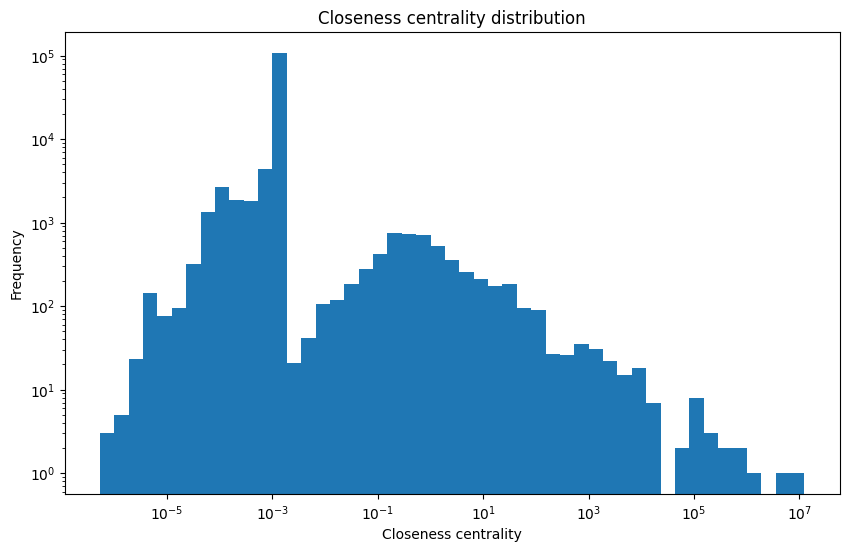

In [100]:
log_bins = np.logspace(np.log10(min(G_aave_count_igraph_closeness2.values())), np.log10(max(G_aave_count_igraph_closeness2.values())), 50)

plt.figure(figsize=(10, 6))
plt.hist(G_aave_count_igraph_closeness2.values(), bins=log_bins)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Closeness centrality')
plt.ylabel('Frequency')
plt.title('Closeness centrality distribution')
plt.yscale('log')
plt.show()

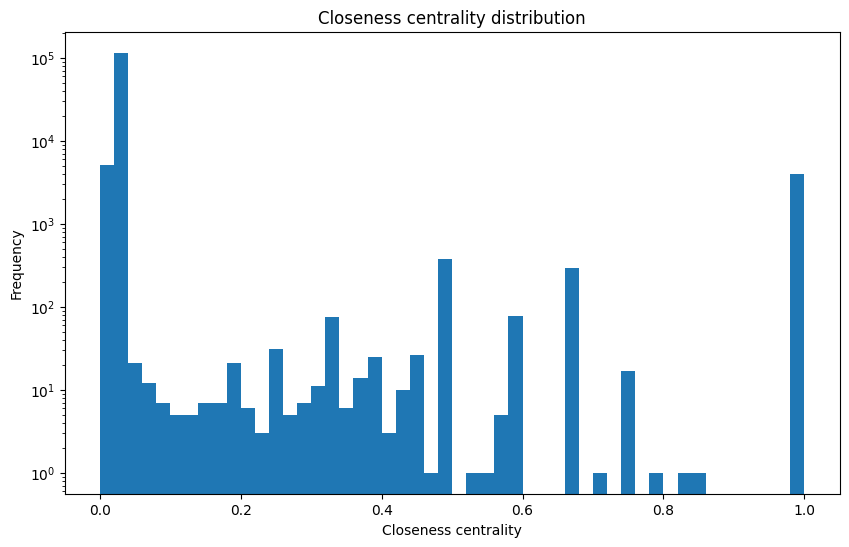

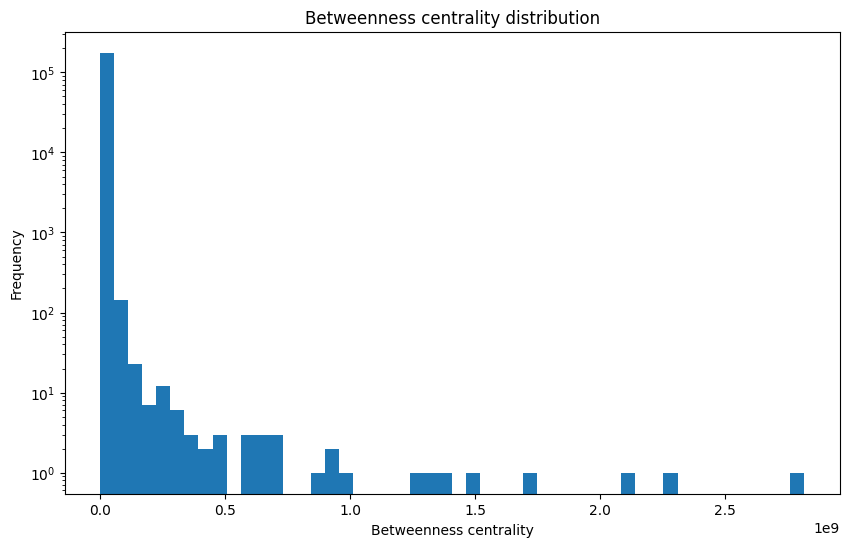

In [44]:
def plot_centrality_distribution(centrality_scores, title, xlabel):
    plt.figure(figsize=(10, 6))
    plt.hist(centrality_scores.values(), bins=50)#, edgecolor='black')
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.title(title)
    plt.yscale('log')
    plt.show()

plot_centrality_distribution(G_aave_count_igraph_closeness2, 
                              'Closeness centrality distribution', 
                              'Closeness centrality')

plot_centrality_distribution(G_aave_count_igraph_betweenness2, 
                              'Betweenness centrality distribution', 
                              'Betweenness centrality')

## Correlation analysis

### Comparing only the overlapping nodes

In [21]:
all_AAVE_transfers = aave_df.melt(value_vars=['from', 'to'], id_vars=['value'], value_name='address')
average_AAVE_tokens = all_AAVE_transfers.groupby('address')['value'].mean().to_dict()
AAVE_transfer_counts = all_AAVE_transfers['address'].value_counts().to_dict()

all_aToken_transfers = aToken_df.melt(value_vars=['from', 'to'], id_vars=['value'], value_name='address')
average_aWETH_tokens = all_aToken_transfers.groupby('address')['value'].mean().to_dict()
aWETH_transfer_counts = all_aToken_transfers['address'].value_counts().to_dict()

In [22]:
all_AAVE_users = pd.concat([aave_df[['from', 'value']].rename(columns={'from': 'user'}), aave_df[['to', 'value']].rename(columns={'to': 'user'})])

avg_all_AAVE_transfers = all_AAVE_users.groupby('user')['value'].mean().to_dict()
avg_outgoing_AAVE = aave_df.groupby('from')['value'].mean().to_dict()
avg_incoming_AAVE = aave_df.groupby('to')['value'].mean().to_dict()


all_aWETH_users = pd.concat([aToken_df[['from', 'value']].rename(columns={'from': 'user'}), aToken_df[['to', 'value']].rename(columns={'to': 'user'})])

avg_all_aWETH_transfers = all_aWETH_users.groupby('user')['value'].mean().to_dict()
avg_outgoing_aWETH = aToken_df.groupby('from')['value'].mean().to_dict()
avg_incoming_aWETH = aToken_df.groupby('to')['value'].mean().to_dict()

In [23]:
proposals_mapping = {}

for proposer, count in proposal_counts.items():
    proposals_mapping[proposer] = count

In [24]:
average_from_AAVE_transferred_mapping = avg_outgoing_AAVE
average_to_AAVE_transferred_mapping = avg_incoming_AAVE

average_from_aWETH_transferred_mapping = avg_outgoing_aWETH
average_to_aWETH_transferred_mapping = avg_incoming_aWETH

In [25]:
vote_weights = {}
for votes in aave_v2_votes:
    for vote in votes['votes']:
        voter = vote['id'].split('-')[0]
        weight = vote['weight']
        if voter in vote_weights:
            vote_weights[voter] += float(weight)
        else:
            vote_weights[voter] = float(weight)
            
for votes in aave_v3_votes:
    for vote in votes['votes']:
        voter = vote['voter'].lower()
        weight = vote['weight']
        if voter in vote_weights:
            vote_weights[voter] += float(weight)
        else:
            vote_weights[voter] = float(weight)

In [26]:
total_AAVE_transferred_mapping = {}
# from_AAVE_transferred_mapping = {}
# to_AAVE_transferred_mapping = {}
average_AAVE_transferred_mapping = avg_all_AAVE_transfers
# average_from_AAVE_transferred_mapping = avg_outgoing_AAVE
# average_to_AAVE_transferred_mapping = avg_incoming_AAVE
number_of_AAVE_transfers_mapping = AAVE_transfer_counts

proposals_mapping = {}
votes_casted_mapping = {}
from_delegations_mapping = {}
to_delegations_mapping = {}
average_vote_weights_mapping = {}

total_aWETH_transferred_mapping = {}
# from_aWETH_transferred_mapping = {}
# to_aWETH_transferred_mapping = {}
average_aWETH_transferred_mapping = avg_all_aWETH_transfers
# average_from_aWETH_transferred_mapping = avg_outgoing_aWETH
# average_to_aWETH_transferred_mapping = avg_incoming_aWETH
number_of_aWETH_transfers_mapping = aWETH_transfer_counts

for _, row in aave_df.iterrows():
    from_address = row['from'].lower()
    to_address = row['to'].lower()
    value = row['value']
    
    if from_address in total_AAVE_transferred_mapping:
        total_AAVE_transferred_mapping[from_address] += value
    else:
        total_AAVE_transferred_mapping[from_address] = value
        
    # if from_address in from_AAVE_transferred_mapping:
    #     from_AAVE_transferred_mapping[from_address] += value
    # else:
    #     from_AAVE_transferred_mapping[from_address] = value
    
    if to_address in total_AAVE_transferred_mapping:
        total_AAVE_transferred_mapping[to_address] += value
    else:
        total_AAVE_transferred_mapping[to_address] = value
        
    # if to_address in to_AAVE_transferred_mapping:
    #     to_AAVE_transferred_mapping[to_address] += value
    # else:
    #     to_AAVE_transferred_mapping[to_address] = value
        
        
for user, average in average_AAVE_tokens.items():
    if user in average_AAVE_transferred_mapping:
        average_AAVE_transferred_mapping[user] = average
        
# for user, count in AAVE_transfer_counts.items():
#     if user in number_of_AAVE_transfers_mapping:
#         number_of_AAVE_transfers_mapping[user] = count

for proposer, count in proposal_counts.items():
    proposals_mapping[proposer] = count

for voter, count in vote_counts.items():
    votes_casted_mapping[voter] = count

for delegator, count in from_delegations.items():
    from_delegations_mapping[delegator] = count

for delegate, count in to_delegations.items():
    to_delegations_mapping[delegate] = count

for voter, weight in vote_weights.items():
    average_vote_weights_mapping[voter] = weight


for _, row in aToken_df.iterrows():
    from_address = row['from'].lower()
    to_address = row['to'].lower()
    value = row['value']
    
    if from_address in total_aWETH_transferred_mapping:
        total_aWETH_transferred_mapping[from_address] += value
    else:
        total_aWETH_transferred_mapping[from_address] = value
        
    # if from_address in from_aWETH_transferred_mapping:
    #     from_aWETH_transferred_mapping[from_address] += value
    # else:
    #     from_aWETH_transferred_mapping[from_address] = value
        
    if to_address in total_aWETH_transferred_mapping:
        total_aWETH_transferred_mapping[to_address] += value
    else:
        total_aWETH_transferred_mapping[to_address] = value
        
    # if to_address in to_aWETH_transferred_mapping:
    #     to_aWETH_transferred_mapping[to_address] += value
    # else:
    #     to_aWETH_transferred_mapping[to_address] = value

for user, average in average_aWETH_tokens.items():
    if user in average_aWETH_transferred_mapping:
        average_aWETH_transferred_mapping[user] = average
        
# for user, count in aWETH_transfer_counts.items():
#     if user in number_of_aWETH_transfers_mapping:
#         number_of_aWETH_transfers_mapping[user] = count

# addresses = sorted(average_AAVE_transferred_mapping.keys())

In [27]:
def compute_overlapping_correlations(x_name, x_map, y_name, y_map, results):
    valid_addresses = [address for address in x_map.keys() & y_map.keys()]
    
    scores_x = [x_map[address] for address in valid_addresses]
    scores_y = [y_map[address] for address in valid_addresses]
    
    spearman = spearmanr(scores_x, scores_y)
    kendall = kendalltau(scores_x, scores_y)
    
    results.append({
        'x_name': x_name,
        'y_name': y_name,
        'spearman': spearman,
        'kendall': kendall,
        'valid_addresses': valid_addresses
    })

In [28]:
# USING THE SCORES AND METRICS WITH OWN COMPUTATIONS INSTEAD OF BUILT-IN FUNCTIONS
AAVE_mappings = [
    ('AAVE In-Degree Centrality', aave_igraph_in_dc),
    ('AAVE Out-Degree Centrality', aave_igraph_out_dc),
    ('AAVE Eigenvector Centrality', aave_igraph_ec),
    ('AAVE Clustering Coefficient', aave_igraph_cc),
    # ('Total AAVE transferred', total_AAVE_transferred_mapping),
    # ('Total AAVE sent', from_AAVE_transferred_mapping),
    # ('Total AAVE received', to_AAVE_transferred_mapping),
    ('AAVE Avg. per Transfer', average_AAVE_transferred_mapping),
    # ('Average AAVE sent per transfer', average_from_AAVE_transferred_mapping),
    # ('Average AAVE received per transfer', average_to_AAVE_transferred_mapping),
    ('AAVE Transfer Count', number_of_AAVE_transfers_mapping),
    ('AAVE 2-Hop Weight Sum', aave_igraph_2_hop_weights),
    ('AAVE Burstiness', aave_burstiness_total)
]

gov_mappings = [
    # ('Proposals Made', proposals_mapping),
    ('Votes Cast', votes_casted_mapping),
    # ('Delegations Given', from_delegations_mapping),
    ('Delegations Received', to_delegations_mapping),
    ('Avg. Vote Weight', average_vote_weights_mapping)
]    

aWETH_mappings = [
    ('aWETH In-Degree Centrality', aWETH_igraph_in_dc),
    ('aWETH Out-Degree Centrality', aWETH_igraph_out_dc),
    # ('aWETH Eigenvector Centrality', aWETH_igraph_ec),
    # ('aWETH Clustering Coefficient', aWETH_igraph_cc),
    # ('Total aWETH transferred', total_aWETH_transferred_mapping),
    # ('Total aWETH sent', from_aWETH_transferred_mapping),
    # ('Total aWETH received', to_aWETH_transferred_mapping),
    ('aWETH Avg. per Transfer', average_aWETH_transferred_mapping),
    # ('Average aWETH sent per transfer', average_from_aWETH_transferred_mapping),
    # ('Average aWETH received per transfer', average_to_aWETH_transferred_mapping),
    ('aWETH Transfer Count', number_of_aWETH_transfers_mapping),
    ('aWETH Burstiness', aWETH_burstiness_total)
]

mapping_dict = dict(AAVE_mappings) | dict(gov_mappings) | dict(aWETH_mappings)

# nonzero_results = []

# for (x_name, x_map), (y_name, y_map) in itertools.product(AAVE_mappings, gov_mappings):
#     compute_overlapping_correlations(x_name, x_map, y_name, y_map, nonzero_results)

# for (x_name, x_map), (y_name, y_map) in itertools.product(AAVE_mappings, aWETH_mappings):
#     compute_overlapping_correlations(x_name, x_map, y_name, y_map, nonzero_results)

# for (x_name, x_map), (y_name, y_map) in itertools.product(aWETH_mappings, gov_mappings):
#     compute_overlapping_correlations(x_name, x_map, y_name, y_map, nonzero_results)

# #####

aave_gov_results = []
aave_aWETH_results = []
aWETH_gov_results = []

for (x_name, x_map), (y_name, y_map) in itertools.product(AAVE_mappings, gov_mappings):
    compute_overlapping_correlations(x_name, x_map, y_name, y_map, aave_gov_results)

for (x_name, x_map), (y_name, y_map) in itertools.product(AAVE_mappings, aWETH_mappings):
    compute_overlapping_correlations(x_name, x_map, y_name, y_map, aave_aWETH_results)

for (x_name, x_map), (y_name, y_map) in itertools.product(aWETH_mappings, gov_mappings):
    compute_overlapping_correlations(x_name, x_map, y_name, y_map, aWETH_gov_results)


# threshold = 0.75

# for res in nonzero_results:
#     kendall = res['kendall']
    
#     if kendall.statistic > threshold:
#         valid_addresses = res['valid_addresses']
#         percentage_of_addresses = (len(valid_addresses)/len(G_aave_nodes)) * 100
        
#         print(f'{res["x_name"]} vs {res["y_name"]} -> Kendall: {kendall.statistic:.3f}, number of addresses: {len(valid_addresses)}, percentage of addresses: {percentage_of_addresses:.2f}%')
#         print()
        
#         x_map = mapping_dict.get(res['x_name'])
#         y_map = mapping_dict.get(res['y_name'])

#         x_vals = [x_map[address] for address in valid_addresses]
#         y_vals = [y_map[address] for address in valid_addresses]
        
#         fig, axes = plt.subplots(1, 2, figsize=(14, 6))

#         axes[0].scatter(x_vals, y_vals, alpha=0.6)
#         axes[0].set_xlabel(res['x_name'])
#         axes[0].set_ylabel(res['y_name'])
#         axes[0].set_title('Original scale')

#         # log_x = np.log(x_vals)
#         # log_y = np.log(y_vals)
#         # sns.regplot(x=log_x, y=log_y, ax=axes[1])
#         # axes[1].set_xlabel(f'Log({res["x_name"]})')
#         # axes[1].set_ylabel(f'Log({res["y_name"]})')
#         # axes[1].set_title('Log-Log Scale')
#         ####
#         axes[1].scatter(x_vals, y_vals, alpha=0.6)
#         axes[1].set_xscale('log')
#         axes[1].set_yscale('log')
#         axes[1].set_xlabel(res['x_name'])
#         axes[1].set_ylabel(res['y_name'])
#         axes[1].set_title('Log-scaled axes')

#         plt.tight_layout()
#         plt.show()

In [ ]:
with open('data/AAVE_mappings.json', 'w') as f:
    json.dump({name: mapping for name, mapping in AAVE_mappings}, f)

with open('data/gov_mappings.json', 'w') as f:
    json.dump({name: mapping for name, mapping in gov_mappings}, f)

with open('data/aWETH_mappings.json', 'w') as f:
    json.dump({name: mapping for name, mapping in aWETH_mappings}, f)

In [ ]:
with open('data/AAVE_mappings.json', 'r') as f:
    AAVE_mappings = [(name, mapping) for name, mapping in json.load(f).items()]

with open('data/gov_mappings.json', 'r') as f:
    gov_mappings = [(name, mapping) for name, mapping in json.load(f).items()]

with open('data/aWETH_mappings.json', 'r') as f:
    aWETH_mappings = [(name, mapping) for name, mapping in json.load(f).items()]

In [ ]:
with open('data/SI/aave/SI_5_extracted_seeds_avg_infected.pkl', 'rb') as f:
    SI_5_extracted = pickle.load(f)

with open('data/SI/aave/SI_2_extracted_seeds_avg_infected.pkl', 'rb') as f:
    SI_2_extracted = pickle.load(f)

with open('data/SI/aave/SI_1_extracted_seeds_avg_infected.pkl', 'rb') as f:
    SI_1_extracted = pickle.load(f)
    
with open('data/SI/aave/SI_05_extracted_seeds_avg_infected.pkl', 'rb') as f:
    SI_05_extracted = pickle.load(f)
    
with open('data/SI/aave/SI_01_extracted_seeds_avg_infected.pkl', 'rb') as f:
    SI_01_extracted = pickle.load(f)
    
with open('data/SI/aave/SI_001_extracted_seeds_avg_infected.pkl', 'rb') as f:
    SI_001_extracted = pickle.load(f)
    
SI_001_mapping = {i['seed']: i['avg_infected'] for i in SI_001_extracted}
SI_01_mapping = {i['seed']: i['avg_infected'] for i in SI_01_extracted}
SI_05_mapping = {i['seed']: i['avg_infected'] for i in SI_05_extracted}
SI_1_mapping = {i['seed']: i['avg_infected'] for i in SI_1_extracted}
SI_2_mapping = {i['seed']: i['avg_infected'] for i in SI_2_extracted}
SI_5_mapping = {i['seed']: i['avg_infected'] for i in SI_5_extracted}

SI_mappings = [
    ('SI 0.001', SI_001_mapping),
    ('SI 0.01', SI_01_mapping),
    ('SI 0.05', SI_05_mapping),
    ('SI 1', SI_1_mapping),
    ('SI 2', SI_2_mapping),
    ('SI 5', SI_5_mapping)
]

In [188]:
gov_si_results = []

for (x_name, x_map), (y_name, y_map) in itertools.product(gov_mappings, SI_mappings):
    compute_overlapping_correlations(x_name, x_map, y_name, y_map, gov_si_results)

In [ ]:
# COMPUTING CORRELATIONS WITHIN THE DATASETS
AAVE_mappings = [
    ('AAVE In-Degree Centrality', aave_igraph_in_dc),
    ('AAVE Out-Degree Centrality', aave_igraph_out_dc),
    ('AAVE Eigenvector Centrality', aave_igraph_ec),
    ('AAVE Clustering Coefficient', aave_igraph_cc),
    # ('Total AAVE transferred', total_AAVE_transferred_mapping),
    # ('Total AAVE sent', from_AAVE_transferred_mapping),
    # ('Total AAVE received', to_AAVE_transferred_mapping),
    ('AAVE Avg. per Transfer', average_AAVE_transferred_mapping),
    # ('Average AAVE sent per transfer', average_from_AAVE_transferred_mapping),
    # ('Average AAVE received per transfer', average_to_AAVE_transferred_mapping),
    ('AAVE Transfer Count', number_of_AAVE_transfers_mapping),
    ('AAVE 2-Hop Weight Sum', aave_igraph_2_hop_weights),
    ('AAVE Burstiness', aave_burstiness_total)
]

gov_mappings = [
    ('Votes Cast', votes_casted_mapping),
    ('Delegations Given', from_delegations_mapping),
    ('Delegations Received', to_delegations_mapping),
    ('Avg. Vote Weight', average_vote_weights_mapping)
]    

aWETH_mappings = [
    ('aWETH In-Degree Centrality', aWETH_igraph_in_dc),
    ('aWETH Out-Degree Centrality', aWETH_igraph_out_dc),
    # ('aWETH Eigenvector Centrality', aWETH_igraph_ec),
    # ('aWETH Clustering Coefficient', aWETH_igraph_cc),
    # ('Total aWETH transferred', total_aWETH_transferred_mapping),
    # ('Total aWETH sent', from_aWETH_transferred_mapping),
    # ('Total aWETH received', to_aWETH_transferred_mapping),
    ('aWETH Avg. per Transfer', average_aWETH_transferred_mapping),
    # ('Average aWETH sent per transfer', average_from_aWETH_transferred_mapping),
    # ('Average aWETH received per transfer', average_to_aWETH_transferred_mapping),
    ('aWETH Transfer Count', number_of_aWETH_transfers_mapping),
    ('aWETH Burstiness', aWETH_burstiness_total)
]

mapping_dict = dict(AAVE_mappings) | dict(gov_mappings) | dict(aWETH_mappings)

# nonzero_results = []

# for (x_name, x_map), (y_name, y_map) in list(combinations(AAVE_mappings, 2)):
#     compute_overlapping_correlations(x_name, x_map, y_name, y_map, nonzero_results)
    
# for (x_name, x_map), (y_name, y_map) in list(combinations(aWETH_mappings, 2)):
#     compute_overlapping_correlations(x_name, x_map, y_name, y_map, nonzero_results)
    
# for (x_name, x_map), (y_name, y_map) in list(combinations(gov_mappings, 2)):
#     compute_overlapping_correlations(x_name, x_map, y_name, y_map, nonzero_results)

#####

aave_results = []
aWETH_results = []
gov_results = []

for (x_name, x_map), (y_name, y_map) in list(combinations(AAVE_mappings, 2)):
    compute_overlapping_correlations(x_name, x_map, y_name, y_map, aave_results)
    
# for (x_name, x_map), (y_name, y_map) in list(combinations(aWETH_mappings, 2)):
#     compute_overlapping_correlations(x_name, x_map, y_name, y_map, aWETH_results)
    
# for (x_name, x_map), (y_name, y_map) in list(combinations(gov_mappings, 2)):
#     compute_overlapping_correlations(x_name, x_map, y_name, y_map, gov_results)

# threshold = 0.9

# for res in nonzero_results:
#     kendall = res['kendall']
    
#     if kendall.statistic > threshold:
#         valid_addresses = res['valid_addresses']
        
#         print(f'{res["x_name"]} vs {res["y_name"]} -> Kendall: {kendall.statistic:.3f}, number of addresses: {len(valid_addresses)}')
#         # print()
        
#         # x_map = mapping_dict.get(res['x_name'])
#         # y_map = mapping_dict.get(res['y_name'])
        
#         # plt.figure(figsize=(10, 6))
#         # plt.scatter([x_map[address] for address in valid_addresses], [y_map[address] for address in valid_addresses], alpha=0.6)
#         # plt.xlabel(res['x_name'])
#         # plt.ylabel(res['y_name'])
#         # plt.show()
        
#         # log_x = np.log1p([x_map[address] for address in valid_addresses])
#         # log_y = np.log1p([y_map[address] for address in valid_addresses])

#         # sns.regplot(x=log_x, y=log_y)
#         # plt.xlabel(f'Log({res["x_name"]})')
#         # plt.ylabel(f'Log({res["y_name"]})')
#         # plt.show()

### Correlation heatmaps

In [29]:
def create_heatmap(results):
    def unique_ordered(items):
        seen = set()
        ordered = []
        for item in items:
            if item not in seen:
                seen.add(item)
                ordered.append(item)
        return ordered

    x_datasets = unique_ordered([entry['x_name'] for entry in results])
    y_datasets = unique_ordered([entry['y_name'] for entry in results])

    # spearman_corr_matrix = np.zeros((len(x_datasets), len(y_datasets)))
    kendall_corr_matrix = np.zeros((len(x_datasets), len(y_datasets)))

    for entry in results:
        x_idx = x_datasets.index(entry['x_name'])
        y_idx = y_datasets.index(entry['y_name'])
        # spearman_corr_matrix[x_idx, y_idx] = entry['spearman'].statistic
        kendall_corr_matrix[x_idx, y_idx] = entry['kendall'].statistic

    # spearman_corr_df = pd.DataFrame(spearman_corr_matrix, index=x_datasets, columns=y_datasets)
    kendall_corr_df = pd.DataFrame(kendall_corr_matrix, index=x_datasets, columns=y_datasets)

    # plt.figure(figsize=(8, 6))
    # sns.heatmap(spearman_corr_df, annot=True, cmap='coolwarm', cbar=True, fmt='.2f', vmin=-1, vmax=1)
    # plt.title("Spearman correlation")
    # plt.show()

    plt.figure(figsize=(8, 6))
    sns.heatmap(kendall_corr_df, annot=True, cmap='coolwarm', cbar=True, fmt='.2f', vmin=-1, vmax=1)
    # plt.title("Kendall correlation")
    plt.show()

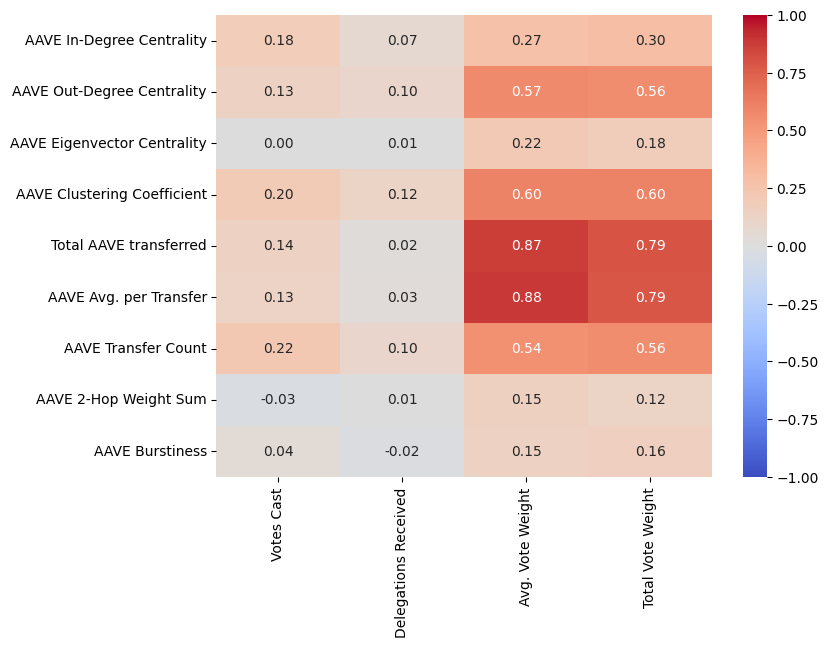

In [189]:
create_heatmap(aave_gov_results)

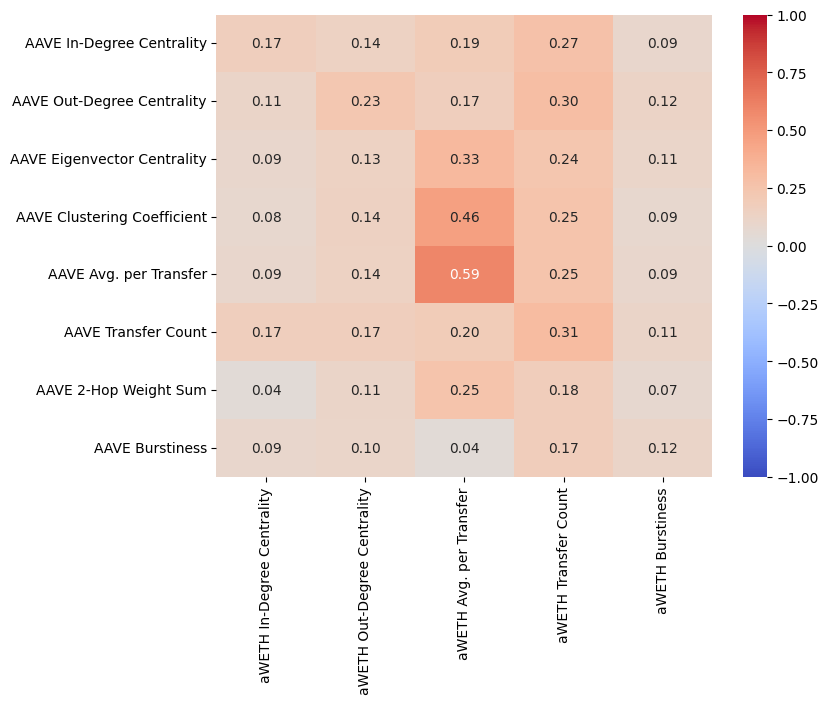

In [30]:
create_heatmap(aave_aWETH_results)

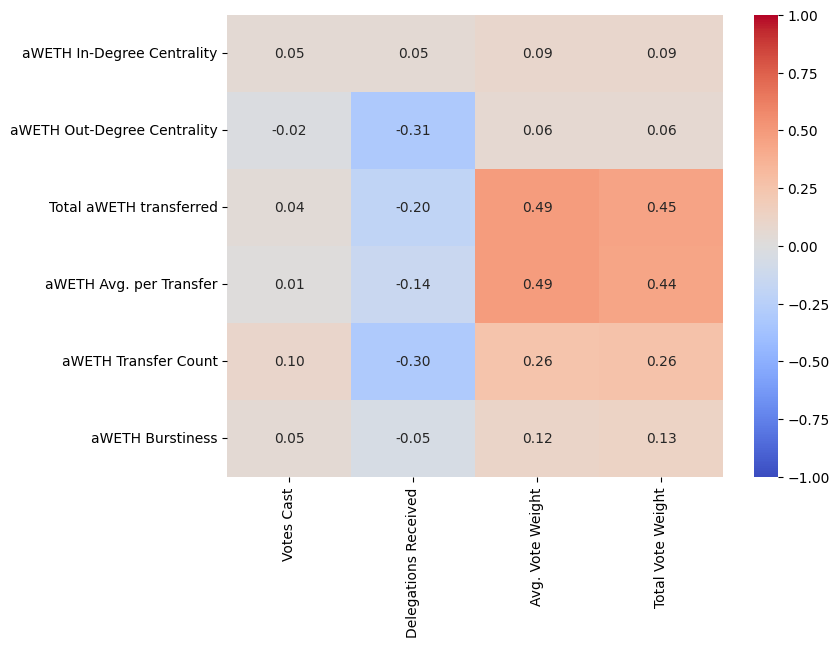

In [191]:
create_heatmap(aWETH_gov_results)

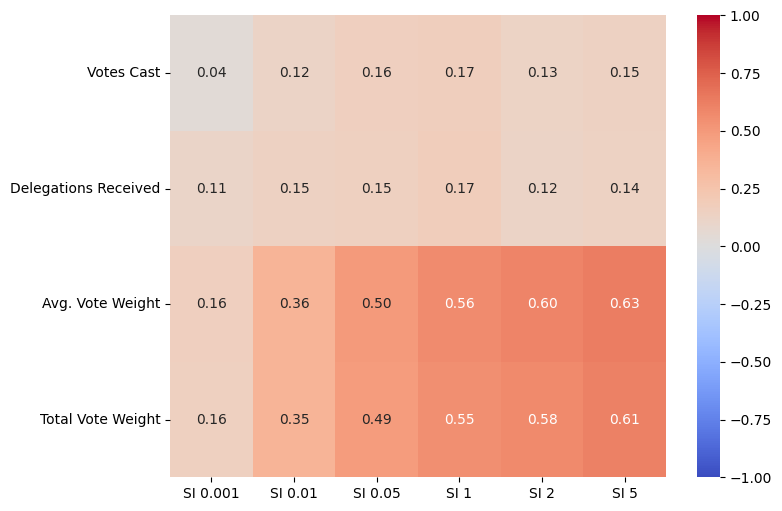

In [192]:
create_heatmap(gov_si_results)

In [100]:
def create_lower_triangle_heatmap(results):
    def unique_ordered(items):
        seen = set()
        ordered = []
        for item in items:
            if item not in seen:
                seen.add(item)
                ordered.append(item)
        return ordered

    feature_names = unique_ordered(
        [entry['x_name'] for entry in results] + [entry['y_name'] for entry in results]
    )

    n = len(feature_names)
    spearman_corr_matrix = np.zeros((n, n))
    kendall_corr_matrix = np.zeros((n, n))

    for entry in results:
        x_idx = feature_names.index(entry['x_name'])
        y_idx = feature_names.index(entry['y_name'])
        spearman = entry['spearman'].statistic
        kendall = entry['kendall'].statistic

        spearman_corr_matrix[x_idx, y_idx] = spearman
        spearman_corr_matrix[y_idx, x_idx] = spearman
        kendall_corr_matrix[x_idx, y_idx] = kendall
        kendall_corr_matrix[y_idx, x_idx] = kendall

    mask = np.triu(np.ones_like(spearman_corr_matrix, dtype=bool), k=0)

    trimmed_feature_names_y = feature_names[1:]
    trimmed_feature_names_x = feature_names[:-1]
    spearman_corr_trimmed = spearman_corr_matrix[1:, :-1]
    kendall_corr_trimmed = kendall_corr_matrix[1:, :-1]
    mask_trimmed = mask[1:, :-1]

    spearman_corr_df = pd.DataFrame(spearman_corr_trimmed, index=trimmed_feature_names_y, columns=trimmed_feature_names_x)
    kendall_corr_df = pd.DataFrame(kendall_corr_trimmed, index=trimmed_feature_names_y, columns=trimmed_feature_names_x)

    plt.figure(figsize=(8, 6))
    # sns.heatmap(spearman_corr_df, annot=True, cmap='coolwarm', cbar=True, fmt='.2f', vmin=-1, vmax=1, square=True)
    sns.heatmap(spearman_corr_df, mask=mask_trimmed, annot=True, cmap='coolwarm', cbar=True, fmt='.2f', vmin=-1, vmax=1)
    plt.title("Spearman correlation")
    plt.show()

    plt.figure(figsize=(8,6))
    # sns.heatmap(kendall_corr_df, annot=True, cmap='coolwarm', cbar=True, fmt='.2f', vmin=-1, vmax=1, square=True)
    sns.heatmap(kendall_corr_df, mask=mask_trimmed, annot=True, cmap='coolwarm', cbar=True, fmt='.2f', vmin=-1, vmax=1)
    # plt.title("Kendall correlation")
    plt.show()

In [ ]:
create_lower_triangle_heatmap(aave_results)

In [129]:
def compute_overlapping_correlations_twice(x_name, x_map, y_name, y_map, results_gov, results_non_gov, results_CEX, results_CA):
    valid_addresses_gov = [address for address in x_map.keys() & y_map.keys() if address in EOA and address in all_proposers_voters_delegators_in_G_aave]
    valid_addresses_non_gov = [address for address in x_map.keys() & y_map.keys() if address in EOA and address not in all_proposers_voters_delegators_in_G_aave and address not in CEX]
    valid_addresses_CEX = [address for address in x_map.keys() & y_map.keys() if address in CEX]
    valid_addresses_CA = [address for address in x_map.keys() & y_map.keys() if address in CA]
    
    scores_x_gov = [x_map[address] for address in valid_addresses_gov]
    scores_y_gov = [y_map[address] for address in valid_addresses_gov]
    
    scores_x_non_gov = [x_map[address] for address in valid_addresses_non_gov]
    scores_y_non_gov = [y_map[address] for address in valid_addresses_non_gov]
    
    scores_x_CEX = [x_map[address] for address in valid_addresses_CEX]
    scores_y_CEX = [y_map[address] for address in valid_addresses_CEX]
    
    scores_x_CA = [x_map[address] for address in valid_addresses_CA]
    scores_y_CA = [y_map[address] for address in valid_addresses_CA]
        
    spearman_gov = spearmanr(scores_x_gov, scores_y_gov)
    kendall_gov = kendalltau(scores_x_gov, scores_y_gov)
    
    spearman_non_gov = spearmanr(scores_x_non_gov, scores_y_non_gov)
    kendall_non_gov = kendalltau(scores_x_non_gov, scores_y_non_gov)
    
    spearman_CEX = spearmanr(scores_x_CEX, scores_y_CEX)
    kendall_CEX = kendalltau(scores_x_CEX, scores_y_CEX)
    
    spearman_CA = spearmanr(scores_x_CA, scores_y_CA)
    kendall_CA = kendalltau(scores_x_CA, scores_y_CA)
    
    results_gov.append({
        'x_name': x_name,
        'y_name': y_name,
        'spearman': spearman_gov,
        'kendall': kendall_gov,
        'valid_addresses': valid_addresses_gov
    })
    
    results_non_gov.append({
        'x_name': x_name,
        'y_name': y_name,
        'spearman': spearman_non_gov,
        'kendall': kendall_non_gov,
        'valid_addresses': valid_addresses_non_gov
    })
    
    results_CEX.append({
        'x_name': x_name,
        'y_name': y_name,
        'spearman': spearman_CEX,
        'kendall': kendall_CEX,
        'valid_addresses': valid_addresses_CEX
    })
    
    results_CA.append({
        'x_name': x_name,
        'y_name': y_name,
        'spearman': spearman_CA,
        'kendall': kendall_CA,
        'valid_addresses': valid_addresses_CA
    })
    
aave_results_gov = []
aave_results_non_gov = []
aave_results_CEX = []
aave_results_CA = []
# aWETH_results_gov = []
# aWETH_results_non_gov = []
# gov_results_gov = []
# gov_results_non_gov = []

for (x_name, x_map), (y_name, y_map) in list(combinations(AAVE_mappings, 2)):
    compute_overlapping_correlations_twice(x_name, x_map, y_name, y_map, aave_results_gov, aave_results_non_gov, aave_results_CEX, aave_results_CA)
    
# for (x_name, x_map), (y_name, y_map) in list(combinations(aWETH_mappings, 2)):
#     compute_overlapping_correlations_twice(x_name, x_map, y_name, y_map, aWETH_results_gov, aWETH_results_non_gov)
    
# for (x_name, x_map), (y_name, y_map) in list(combinations(gov_mappings, 2)):
#     compute_overlapping_correlations_twice(x_name, x_map, y_name, y_map, gov_results_gov, gov_results_non_gov)
    
def create_heatmap_per_subgroup(results_gov, results_non_gov, results_CEX, results_CA):
    def unique_ordered(items):
        seen = set()
        ordered = []
        for item in items:
            if item not in seen:
                seen.add(item)
                ordered.append(item)
        return ordered

    x_datasets_gov = unique_ordered([entry['x_name'] for entry in results_gov])
    y_datasets_gov = unique_ordered([entry['y_name'] for entry in results_gov])
    
    x_datasets_non_gov = unique_ordered([entry['x_name'] for entry in results_non_gov])
    y_datasets_non_gov = unique_ordered([entry['y_name'] for entry in results_non_gov])
    
    x_datasets_CEX = unique_ordered([entry['x_name'] for entry in results_CEX])
    y_datasets_CEX = unique_ordered([entry['y_name'] for entry in results_CEX])
    
    x_datasets_CA = unique_ordered([entry['x_name'] for entry in results_CA])
    y_datasets_CA = unique_ordered([entry['y_name'] for entry in results_CA])

    spearman_corr_matrix_gov = np.zeros((len(x_datasets_gov), len(y_datasets_gov)))
    kendall_corr_matrix_gov = np.zeros((len(x_datasets_gov), len(y_datasets_gov)))
    
    spearman_corr_matrix_non_gov = np.zeros((len(x_datasets_non_gov), len(y_datasets_non_gov)))
    kendall_corr_matrix_non_gov = np.zeros((len(x_datasets_non_gov), len(y_datasets_non_gov)))
    
    spearman_corr_matrix_CEX = np.zeros((len(x_datasets_CEX), len(y_datasets_CEX)))
    kendall_corr_matrix_CEX = np.zeros((len(x_datasets_CEX), len(y_datasets_CEX)))
    
    spearman_corr_matrix_CA = np.zeros((len(x_datasets_CA), len(y_datasets_CA)))
    kendall_corr_matrix_CA = np.zeros((len(x_datasets_CA), len(y_datasets_CA)))

    for entry in results_gov:
        x_idx = x_datasets_gov.index(entry['x_name'])
        y_idx = y_datasets_gov.index(entry['y_name'])
        spearman_corr_matrix_gov[x_idx, y_idx] = entry['spearman'].statistic
        kendall_corr_matrix_gov[x_idx, y_idx] = entry['kendall'].statistic
        
    for entry in results_non_gov:
        x_idx = x_datasets_non_gov.index(entry['x_name'])
        y_idx = y_datasets_non_gov.index(entry['y_name'])
        spearman_corr_matrix_non_gov[x_idx, y_idx] = entry['spearman'].statistic
        kendall_corr_matrix_non_gov[x_idx, y_idx] = entry['kendall'].statistic
        
    for entry in results_CEX:
        x_idx = x_datasets_CEX.index(entry['x_name'])
        y_idx = y_datasets_CEX.index(entry['y_name'])
        spearman_corr_matrix_CEX[x_idx, y_idx] = entry['spearman'].statistic
        kendall_corr_matrix_CEX[x_idx, y_idx] = entry['kendall'].statistic
    
    for entry in results_CA:
        x_idx = x_datasets_CA.index(entry['x_name'])
        y_idx = y_datasets_CA.index(entry['y_name'])
        spearman_corr_matrix_CA[x_idx, y_idx] = entry['spearman'].statistic
        kendall_corr_matrix_CA[x_idx, y_idx] = entry['kendall'].statistic

    spearman_corr_df_gov = pd.DataFrame(spearman_corr_matrix_gov, index=x_datasets_gov, columns=y_datasets_gov)
    kendall_corr_df_gov = pd.DataFrame(kendall_corr_matrix_gov, index=x_datasets_gov, columns=y_datasets_gov)
    
    spearman_corr_df_non_gov = pd.DataFrame(spearman_corr_matrix_non_gov, index=x_datasets_non_gov, columns=y_datasets_non_gov)
    kendall_corr_df_non_gov = pd.DataFrame(kendall_corr_matrix_non_gov, index=x_datasets_non_gov, columns=y_datasets_non_gov)
    
    spearman_corr_df_CEX = pd.DataFrame(spearman_corr_matrix_CEX, index=x_datasets_CEX, columns=y_datasets_CEX)
    kendall_corr_df_CEX = pd.DataFrame(kendall_corr_matrix_CEX, index=x_datasets_CEX, columns=y_datasets_CEX)
    
    spearman_corr_df_CA = pd.DataFrame(spearman_corr_matrix_CA, index=x_datasets_CA, columns=y_datasets_CA)
    kendall_corr_df_CA = pd.DataFrame(kendall_corr_matrix_CA, index=x_datasets_CA, columns=y_datasets_CA)
    
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))

    sns.heatmap(spearman_corr_df_gov, ax=axs[0, 0], annot=True, cmap='coolwarm', cbar=True, fmt='.2f', vmin=-1, vmax=1)
    axs[0, 0].set_title("Spearman correlation gov")

    sns.heatmap(spearman_corr_df_non_gov, ax=axs[0, 1], annot=True, cmap='coolwarm', cbar=True, fmt='.2f', vmin=-1, vmax=1)
    axs[0, 1].set_title("Spearman correlation non gov")

    sns.heatmap(spearman_corr_df_CEX, ax=axs[1, 0], annot=True, cmap='coolwarm', cbar=True, fmt='.2f', vmin=-1, vmax=1)
    axs[1, 0].set_title("Spearman correlation CEX")

    sns.heatmap(spearman_corr_df_CA, ax=axs[1, 1], annot=True, cmap='coolwarm', cbar=True, fmt='.2f', vmin=-1, vmax=1)
    axs[1, 1].set_title("Spearman correlation CA")

    plt.tight_layout()
    plt.show()
    
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))

    sns.heatmap(kendall_corr_df_gov, ax=axs[0, 0], annot=True, cmap='coolwarm', cbar=True, fmt='.2f', vmin=-1, vmax=1)
    axs[0, 0].set_title("Kendall correlation gov")

    sns.heatmap(kendall_corr_df_non_gov, ax=axs[0, 1], annot=True, cmap='coolwarm', cbar=True, fmt='.2f', vmin=-1, vmax=1)
    axs[0, 1].set_title("Kendall correlation non gov")

    sns.heatmap(kendall_corr_df_CEX, ax=axs[1, 0], annot=True, cmap='coolwarm', cbar=True, fmt='.2f', vmin=-1, vmax=1)
    axs[1, 0].set_title("Kendall correlation CEX")

    sns.heatmap(kendall_corr_df_CA, ax=axs[1, 1], annot=True, cmap='coolwarm', cbar=True, fmt='.2f', vmin=-1, vmax=1)
    axs[1, 1].set_title("Kendall correlation CA")

    plt.tight_layout()
    plt.show()

In [ ]:
create_heatmap_per_subgroup(aave_results_gov, aave_results_non_gov, aave_results_CEX, aave_results_CA)
# create_heatmap_per_subgroup(aWETH_results_gov, aWETH_results_non_gov)
# create_heatmap_per_subgroup(gov_results_gov, gov_results_non_gov)

### Subset comparison per feature

In [29]:
def plot_feature_vs_governance_scores(feature_mapping, feature_name):
    valid_addresses_votes = feature_mapping.keys() & votes_casted_mapping.keys()
    valid_addresses_weights = feature_mapping.keys() & vote_weights.keys()

    x_votes = [votes_casted_mapping[address] for address in valid_addresses_votes]
    y_votes = [feature_mapping[address] for address in valid_addresses_votes]

    x_weights = [vote_weights[address] for address in valid_addresses_weights]
    y_weights = [feature_mapping[address] for address in valid_addresses_weights]

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    axes[0].scatter(x_votes, y_votes, alpha=0.6)
    axes[0].set_xlabel('Number of Votes')
    axes[0].set_ylabel(feature_name)
    axes[0].set_title(f'{feature_name} vs Number of Votes')
    axes[0].set_xscale('log')
    # axes[0].set_yscale('log')

    axes[1].scatter(x_weights, y_weights, alpha=0.6, color='orange')
    axes[1].set_xlabel('Average Vote Weight')
    axes[1].set_ylabel(feature_name)
    axes[1].set_title(f'{feature_name} vs Average Vote Weight')
    axes[1].set_xscale('log')
    # axes[1].set_yscale('log')

    plt.tight_layout()
    plt.show()

In [ ]:
with open('data/SI/aave/SI_1_extracted_seeds_avg_infected.pkl', 'rb') as f:
    SI_1_extracted = pickle.load(f)
    
with open('data/SI/aave/SI_05_extracted_seeds_avg_infected.pkl', 'rb') as f:
    SI_05_extracted = pickle.load(f)
    
with open('data/SI/aave/SI_01_extracted_seeds_avg_infected.pkl', 'rb') as f:
    SI_01_extracted = pickle.load(f)
    
with open('data/SI/aave/SI_001_extracted_seeds_avg_infected.pkl', 'rb') as f:
    SI_001_extracted = pickle.load(f)

In [35]:
SI_1_dict = {i['seed']: i['avg_infected'] for i in SI_1_extracted}
SI_05_dict = {i['seed']: i['avg_infected'] for i in SI_05_extracted}
SI_01_dict = {i['seed']: i['avg_infected'] for i in SI_01_extracted}
SI_001_dict = {i['seed']: i['avg_infected'] for i in SI_001_extracted}

In [45]:
def compute_correlations(feature_mapping):
    valid_addresses_votes = feature_mapping.keys() & votes_casted_mapping.keys()
    valid_addresses_weights = feature_mapping.keys() & vote_weights.keys()
    
    x_votes = [votes_casted_mapping[address] for address in valid_addresses_votes]
    y_votes = [feature_mapping[address] for address in valid_addresses_votes]

    x_weights = [vote_weights[address] for address in valid_addresses_weights]
    y_weights = [feature_mapping[address] for address in valid_addresses_weights]
    
    spearman_weights = spearmanr(x_weights, y_weights)
    kendall_weights = kendalltau(x_weights, y_weights)
    
    # spearman_votes = spearmanr(x_votes, y_votes)
    # kendall_votes = kendalltau(x_votes, y_votes)
    
    return spearman_weights.statistic, kendall_weights.statistic#, spearman_votes.statistic, kendall_votes.statistic

In [46]:
print(compute_correlations(SI_1_dict))
print(compute_correlations(SI_05_dict))
print(compute_correlations(SI_01_dict))
print(compute_correlations(SI_001_dict))

(0.6972800465493725, 0.5646721314810255)
(0.6190752744302981, 0.49787319637925065)
(0.4471955297582099, 0.35796913345689835)
(0.1946711648840097, 0.15846526163132682)


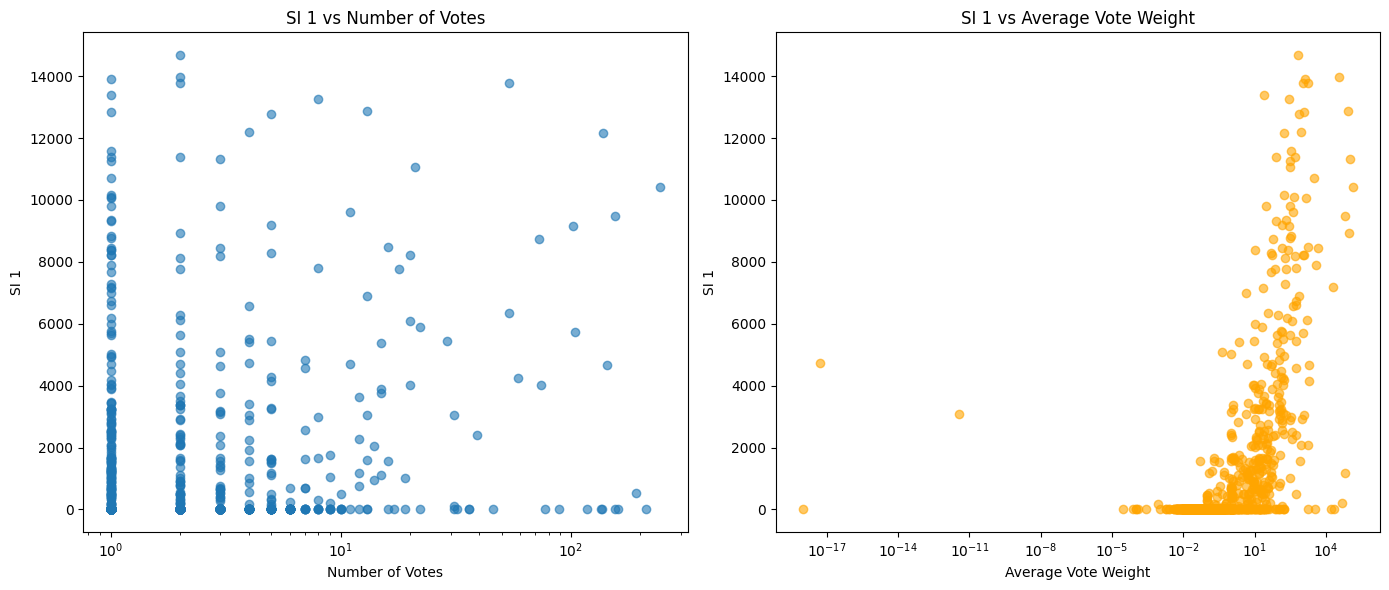

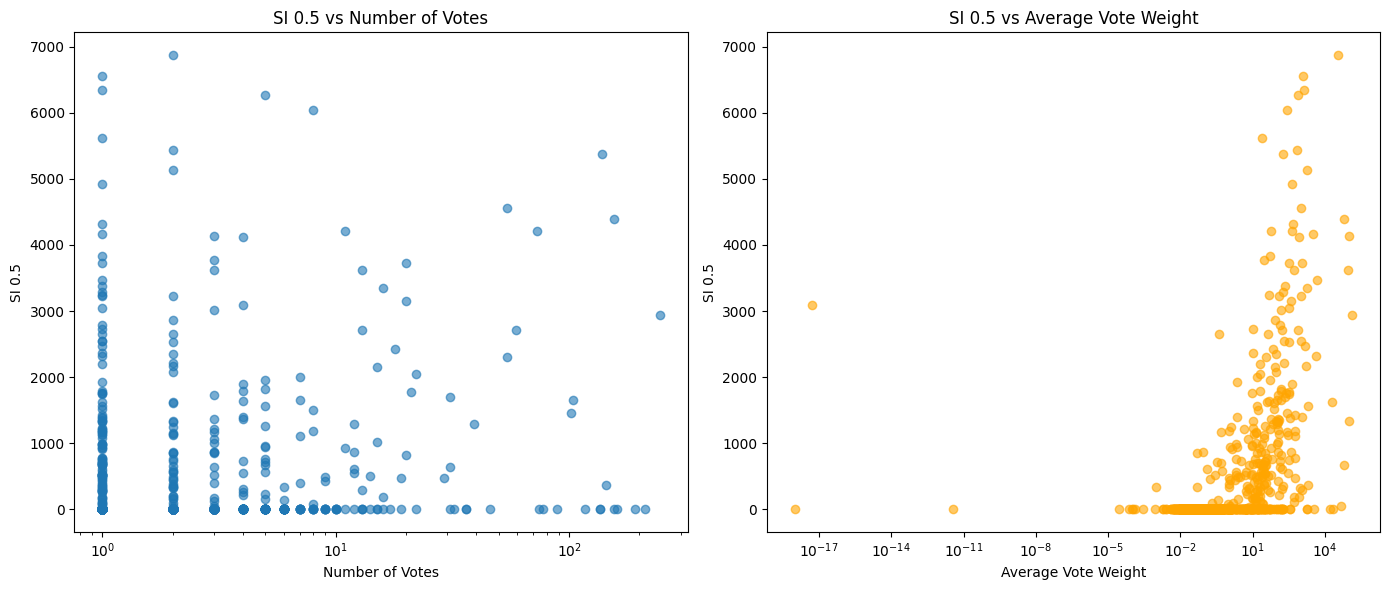

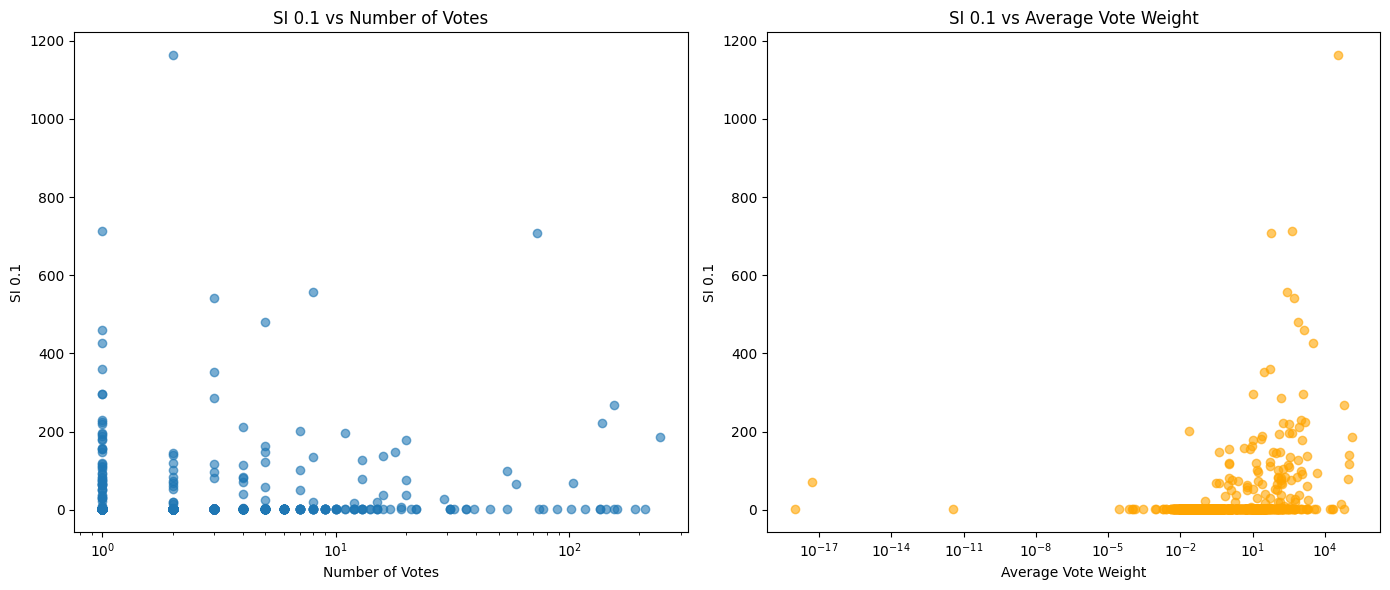

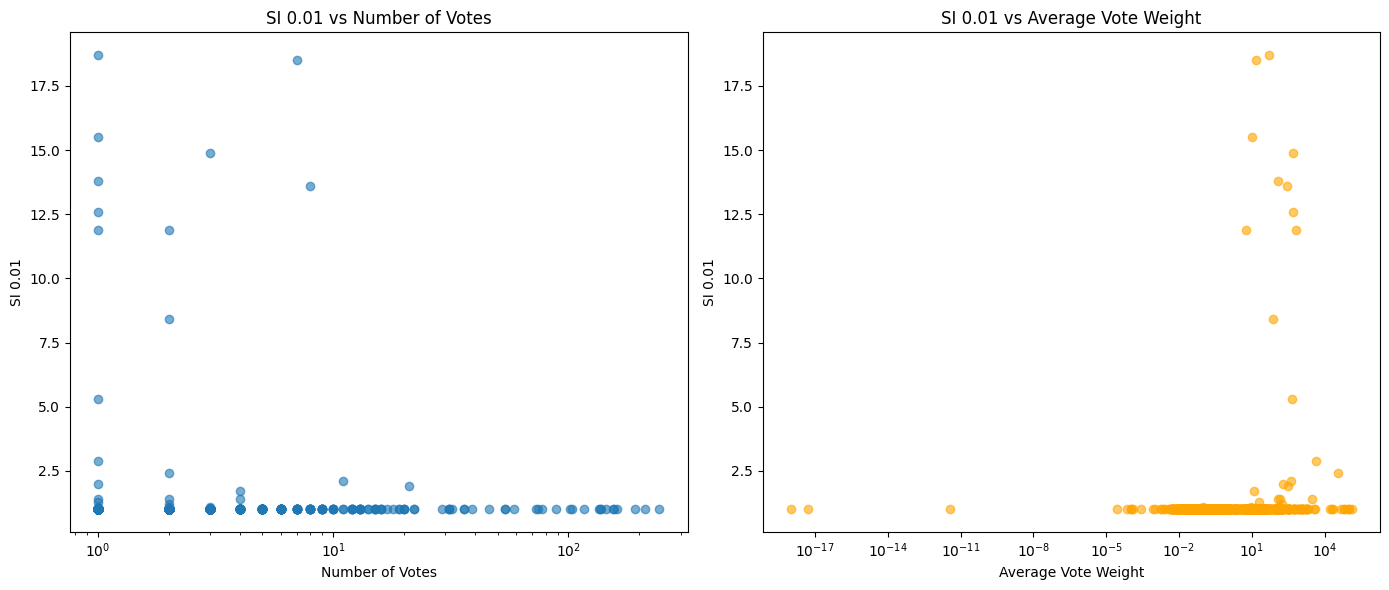

In [37]:
plot_feature_vs_governance_scores(SI_1_dict, 'SI 1')
plot_feature_vs_governance_scores(SI_05_dict, 'SI 0.5')
plot_feature_vs_governance_scores(SI_01_dict, 'SI 0.1')
plot_feature_vs_governance_scores(SI_001_dict, 'SI 0.01')

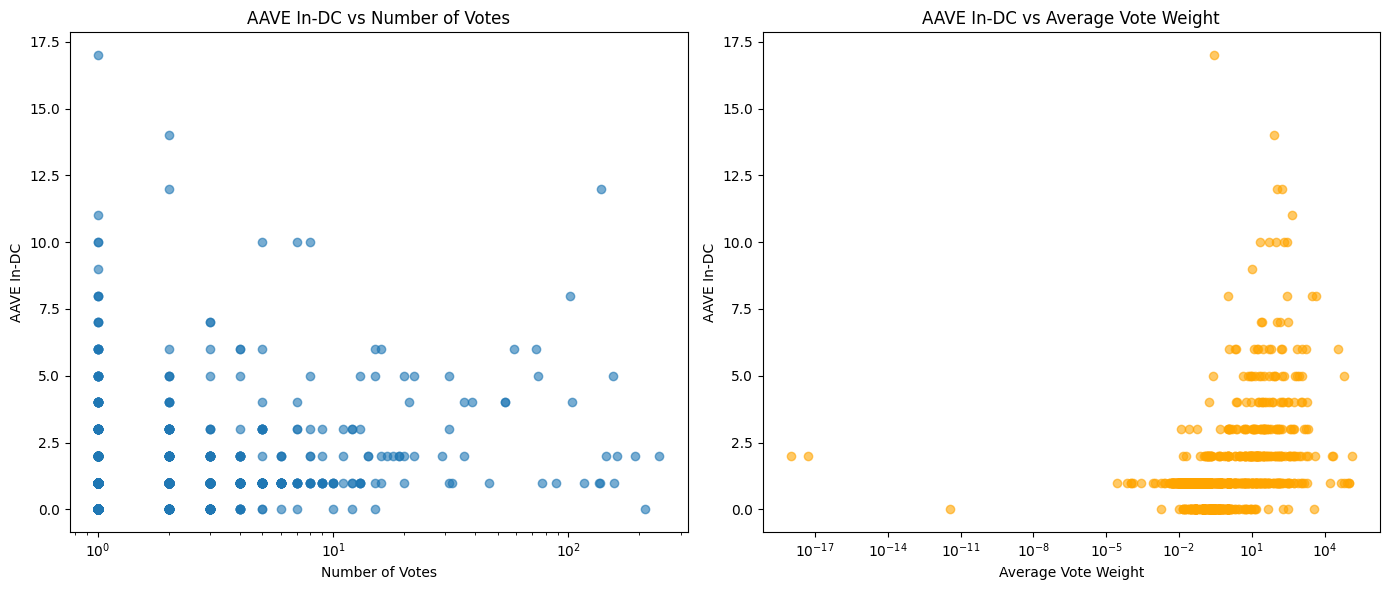

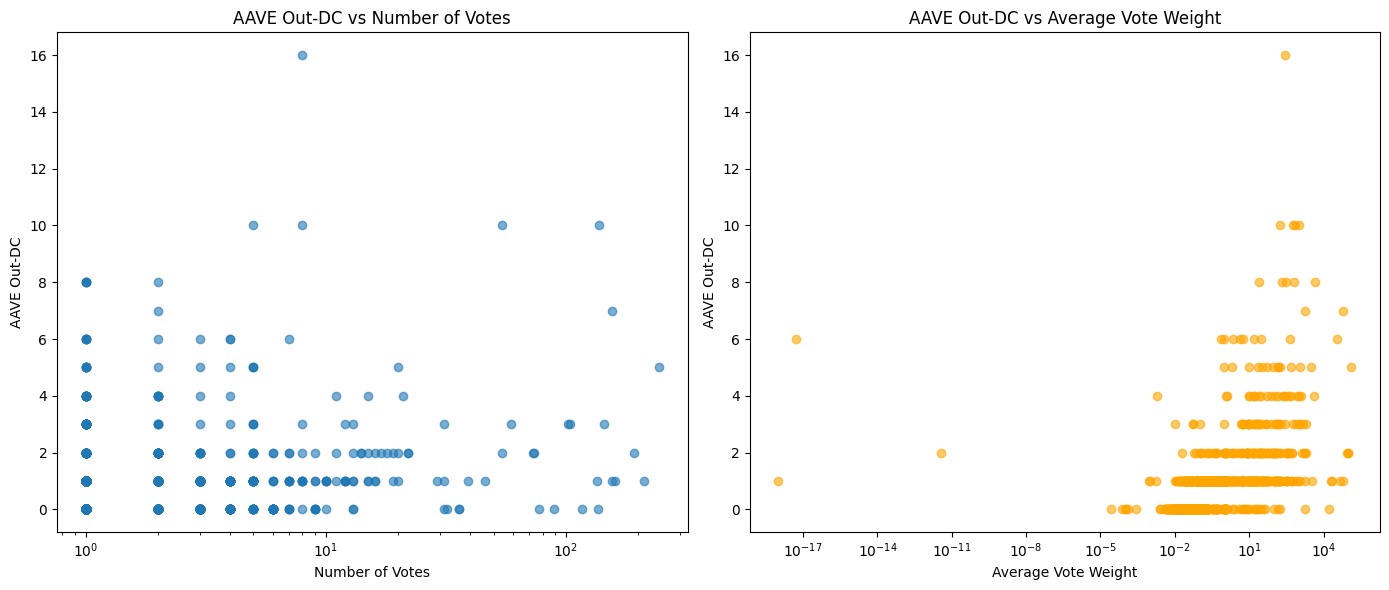

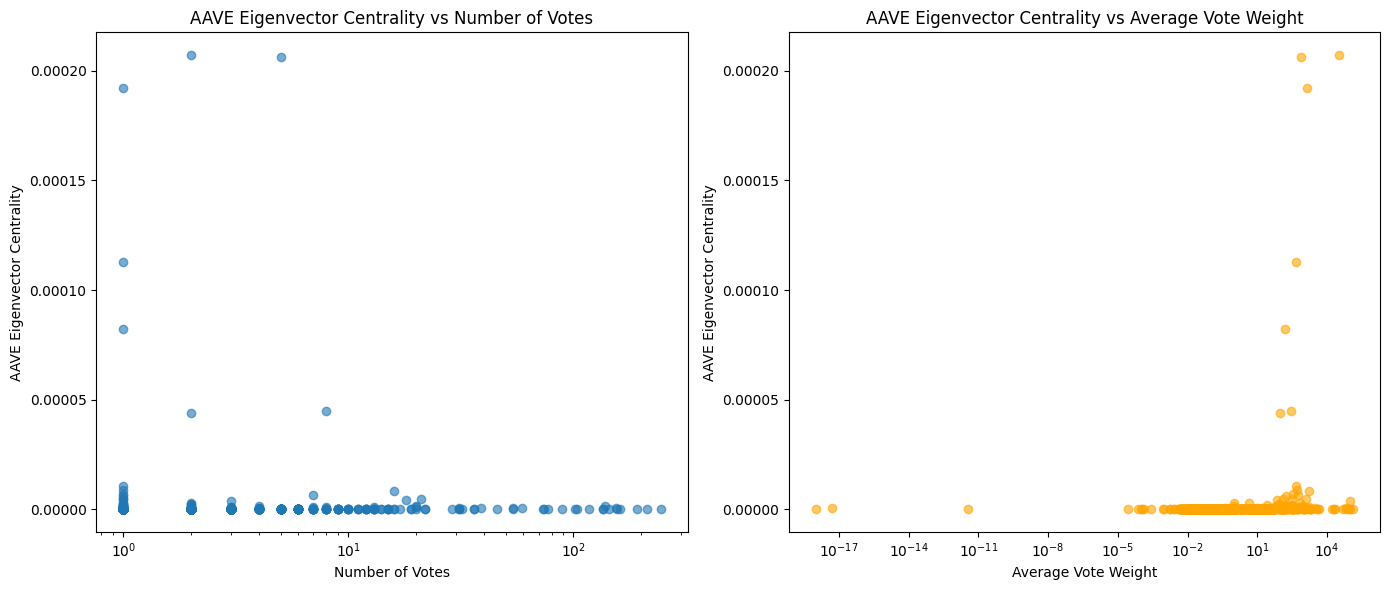

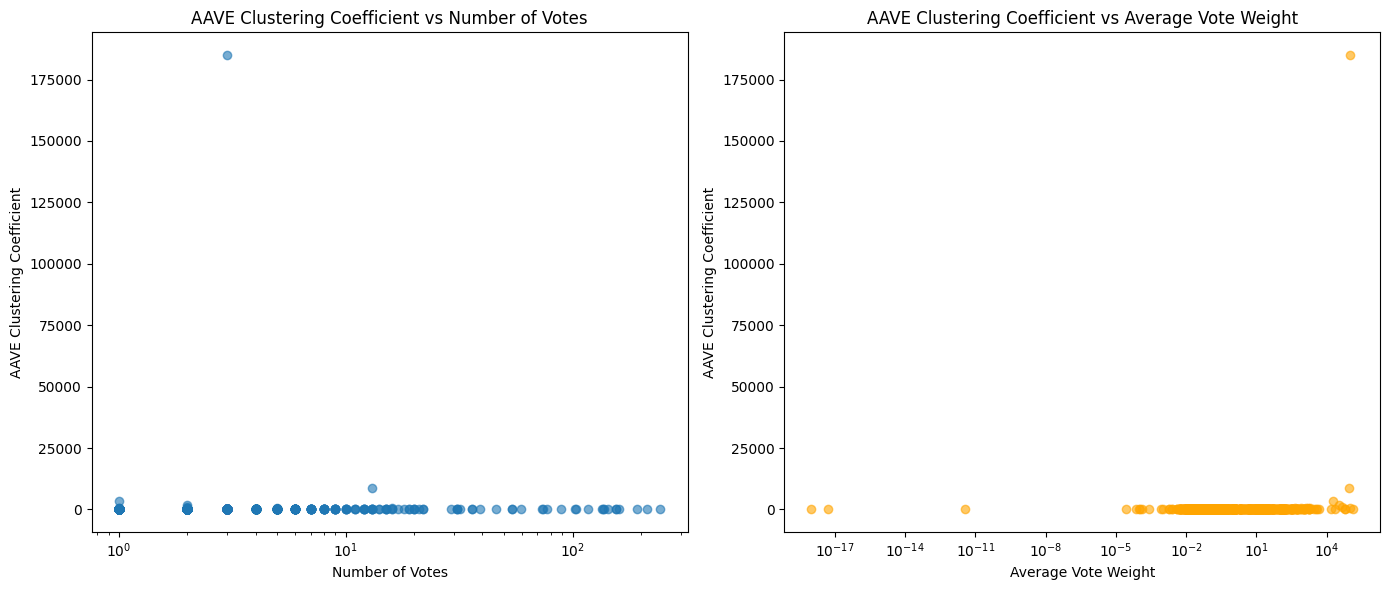

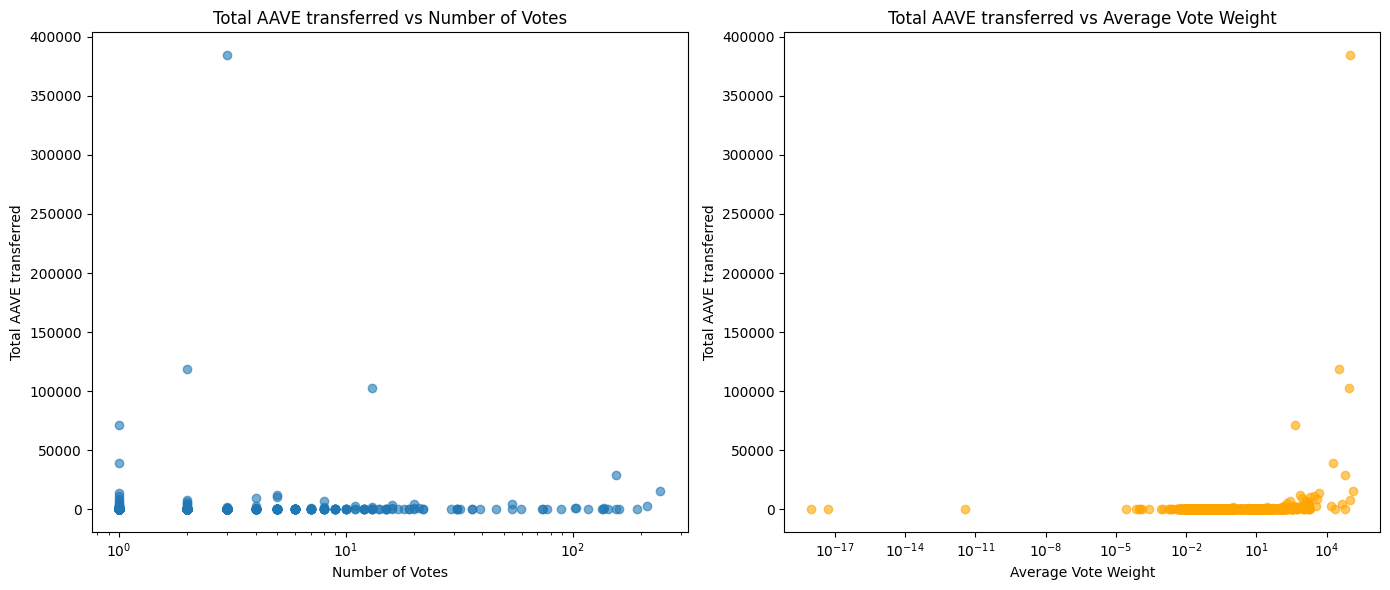

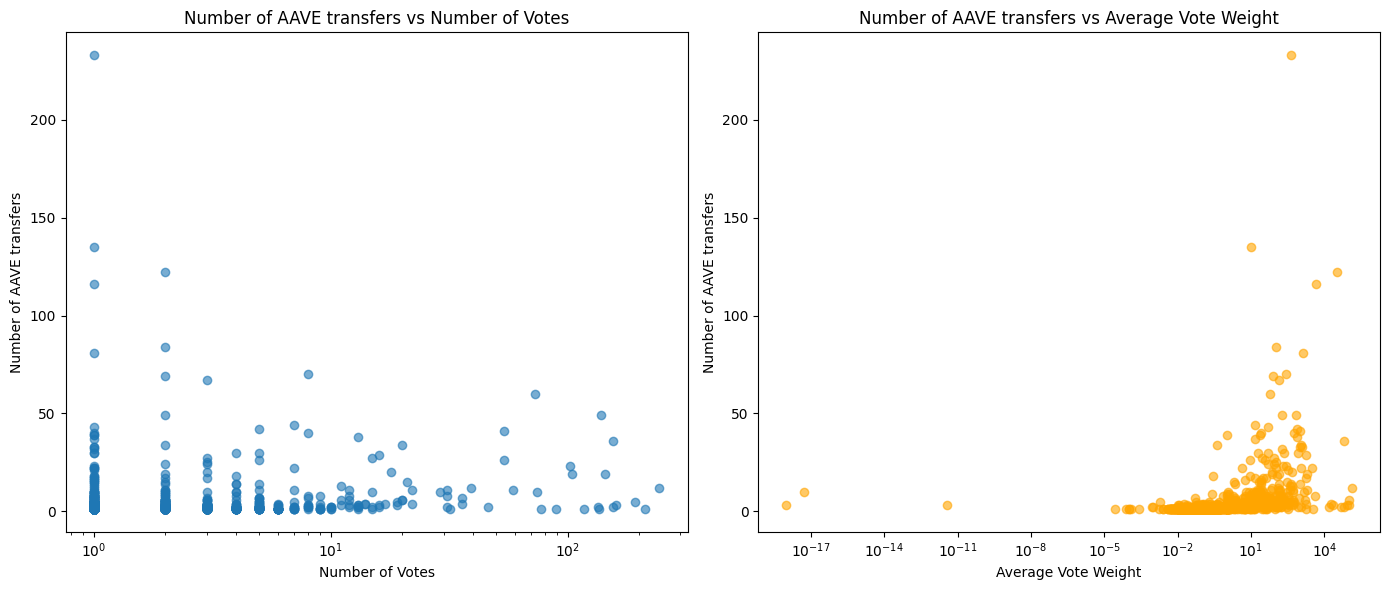

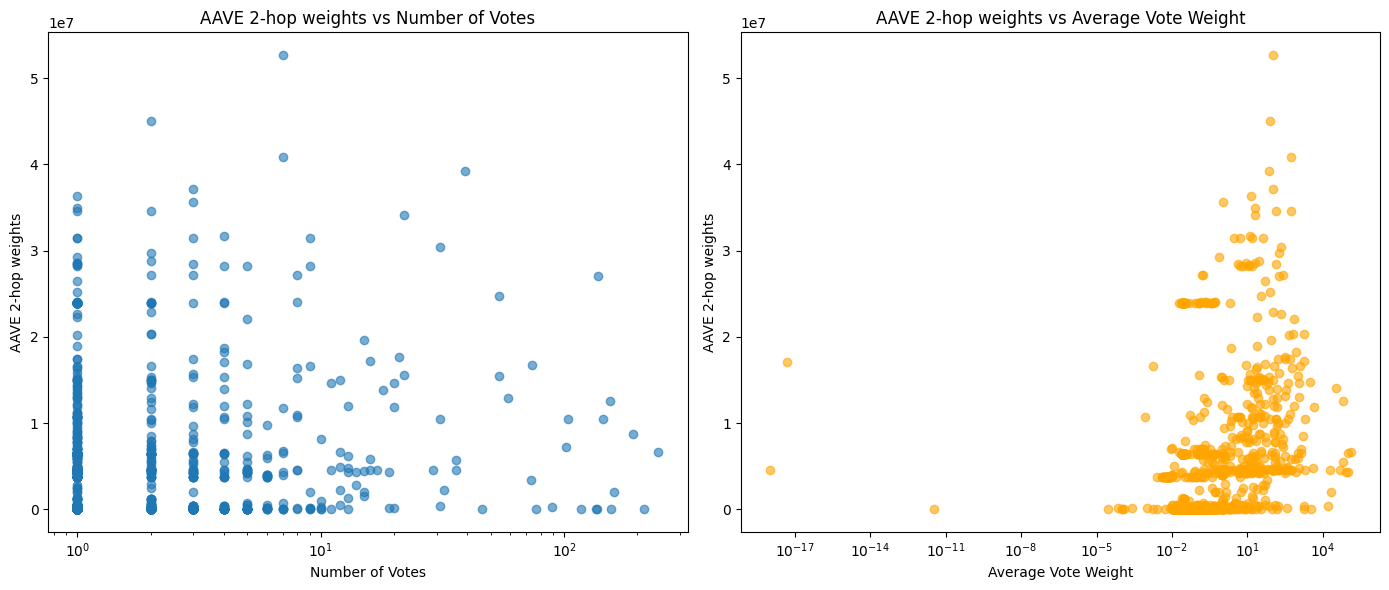

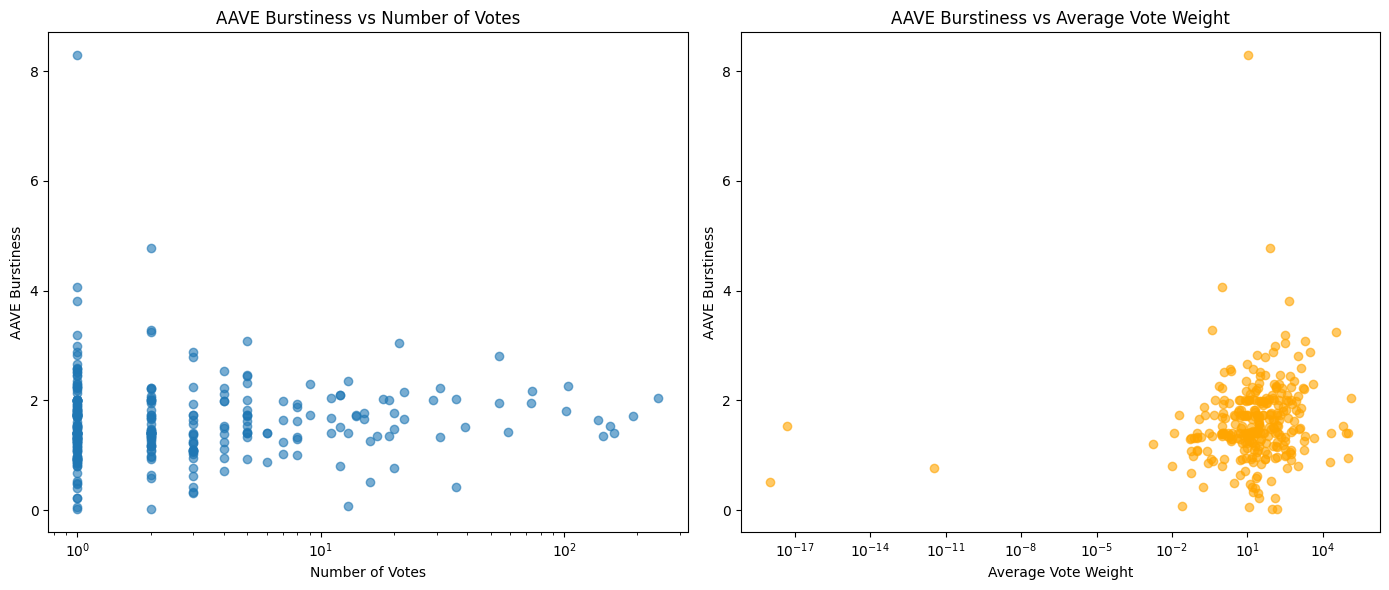

In [ ]:
for feature_name, feature_mapping in AAVE_mappings:
    plot_feature_vs_governance_scores(feature_mapping, feature_name)

In [ ]:
aWETH_users = (set(aToken_df['from'].unique()) | set(aToken_df['to'].unique()))
AAVE_users = (set(aave_df['from'].unique()) | set(aave_df['to'].unique()))

In [ ]:
aWETH_users_in_AAVE = aWETH_users & AAVE_users
governance_users_in_AAVE = (v2_proposers | v3_proposers | v2_voters | v3_voters | delegators) & AAVE_users

In [102]:
def plot_subset_vs_rest(feature_mapping, feature_name, use_kde=True):
    subsets = {
        'Financial users': aWETH_users_in_AAVE,
        'Governance users': governance_users_in_AAVE
    }

    for subset_name, subset in subsets.items():
        in_subset = [feature_mapping[node] for node in subset if node in feature_mapping]
        out_subset = [feature_mapping[node] for node in AAVE_users - subset if node in feature_mapping]

        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        if use_kde:
            sns.kdeplot(in_subset, fill=True, alpha=0.6, ax=axes[0])
        else:
            axes[0].hist(in_subset, bins=30, alpha=0.7)
        axes[0].set_title(f'{subset_name}')
        axes[0].set_xlabel(feature_name)
        axes[0].set_ylabel('Density' if use_kde else 'Frequency')

        if use_kde:
            sns.kdeplot(out_subset, fill=True, alpha=0.6, ax=axes[1], color='gray')
        else:
            axes[1].hist(out_subset, bins=30, alpha=0.7, color='gray')
        axes[1].set_title(f'Not {subset_name}')
        axes[1].set_xlabel(feature_name)
        axes[1].set_ylabel('Density' if use_kde else 'Frequency')

        fig.suptitle(f'{feature_name} — {subset_name} vs Rest', fontsize=14)
        plt.tight_layout()
        plt.show()

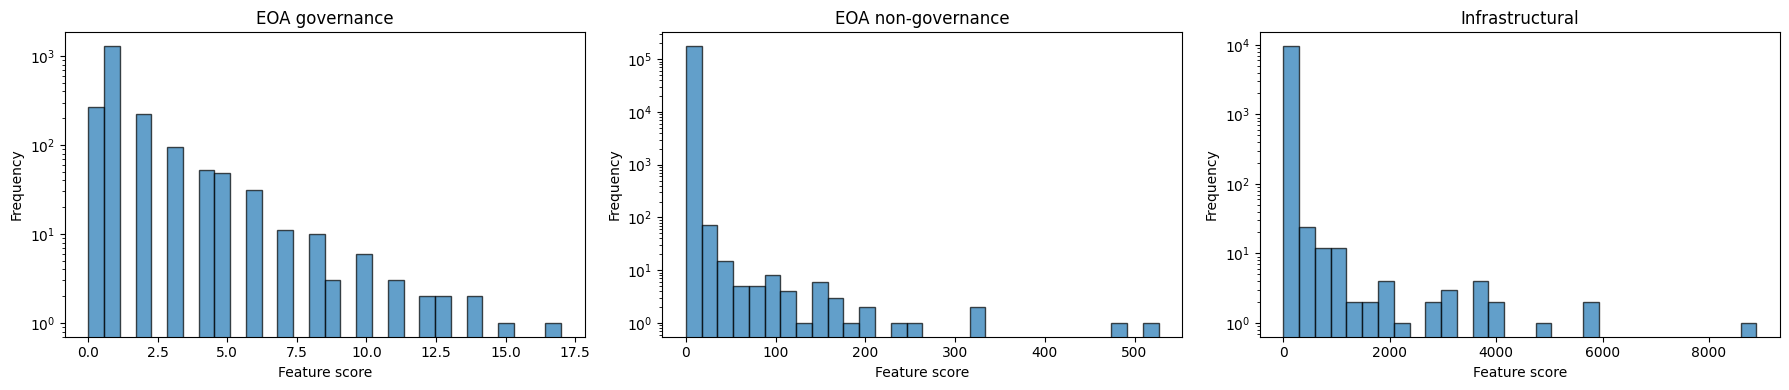

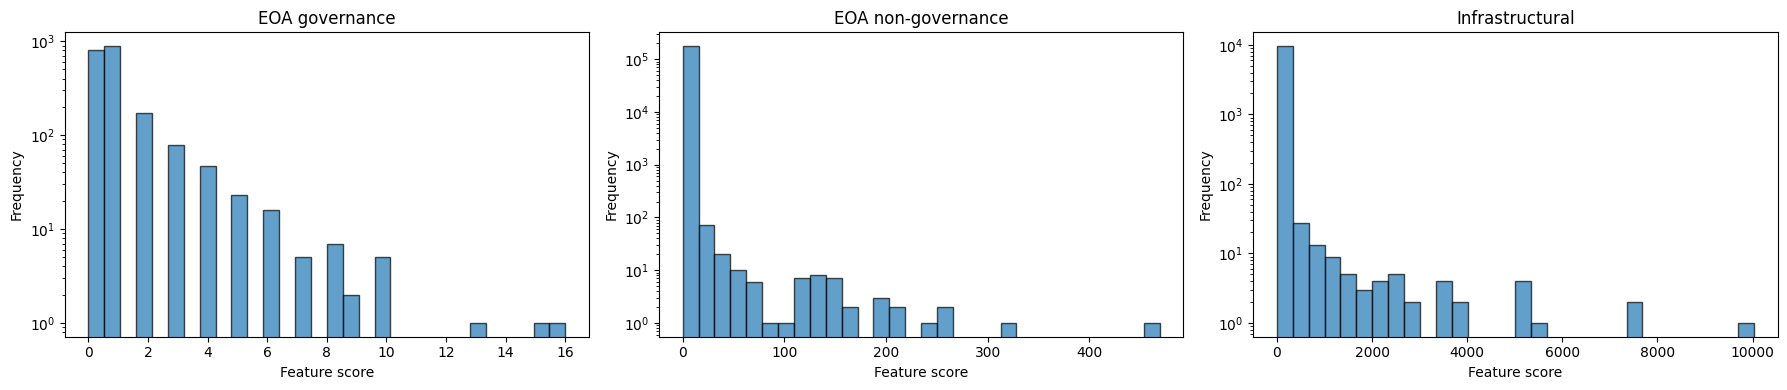

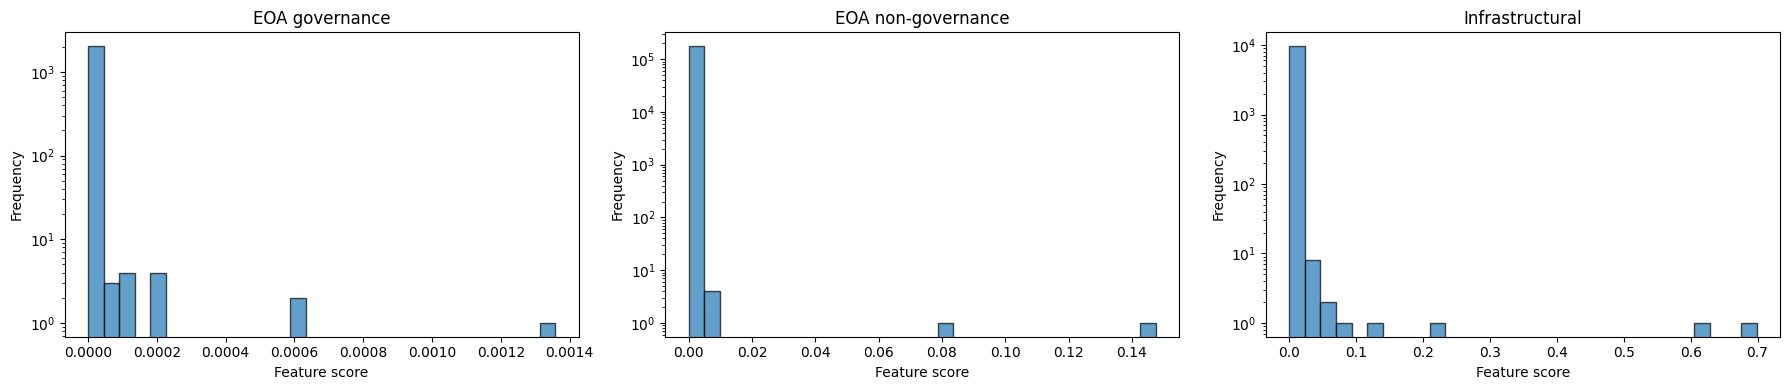

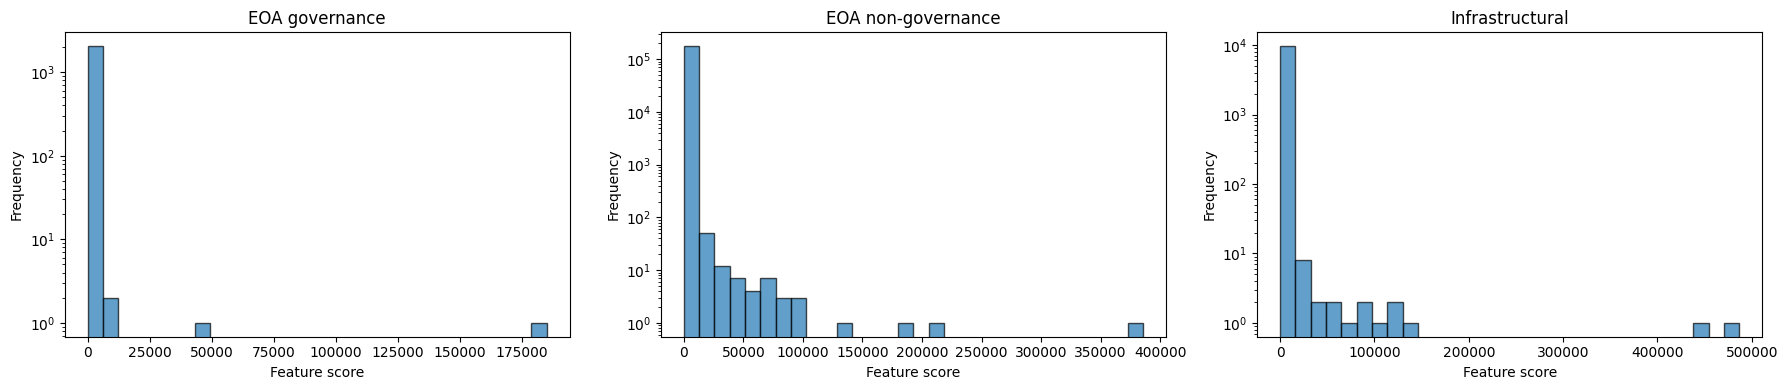

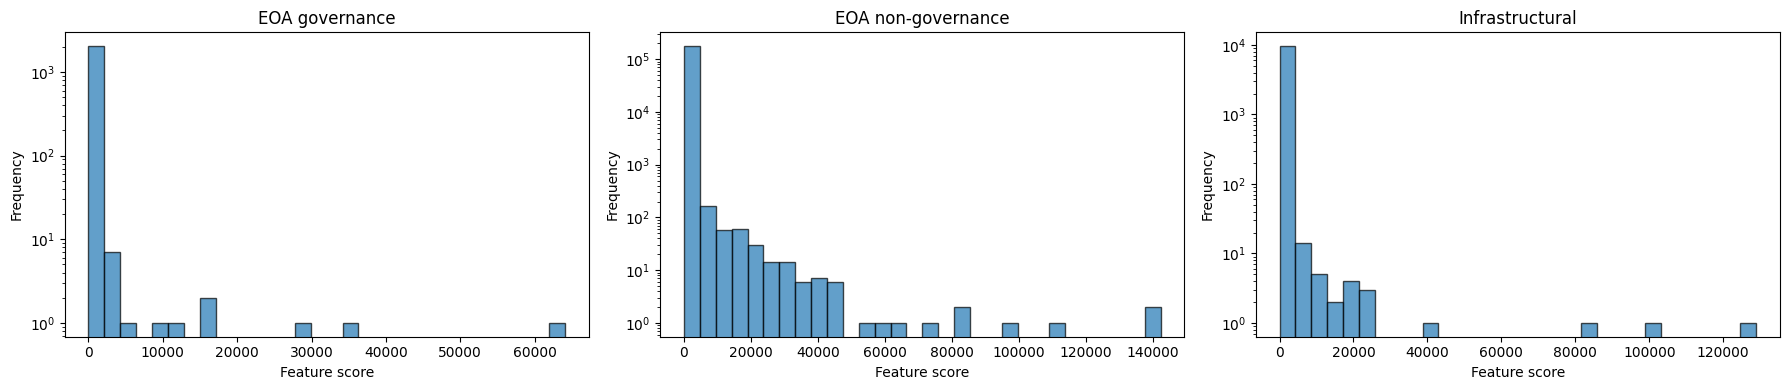

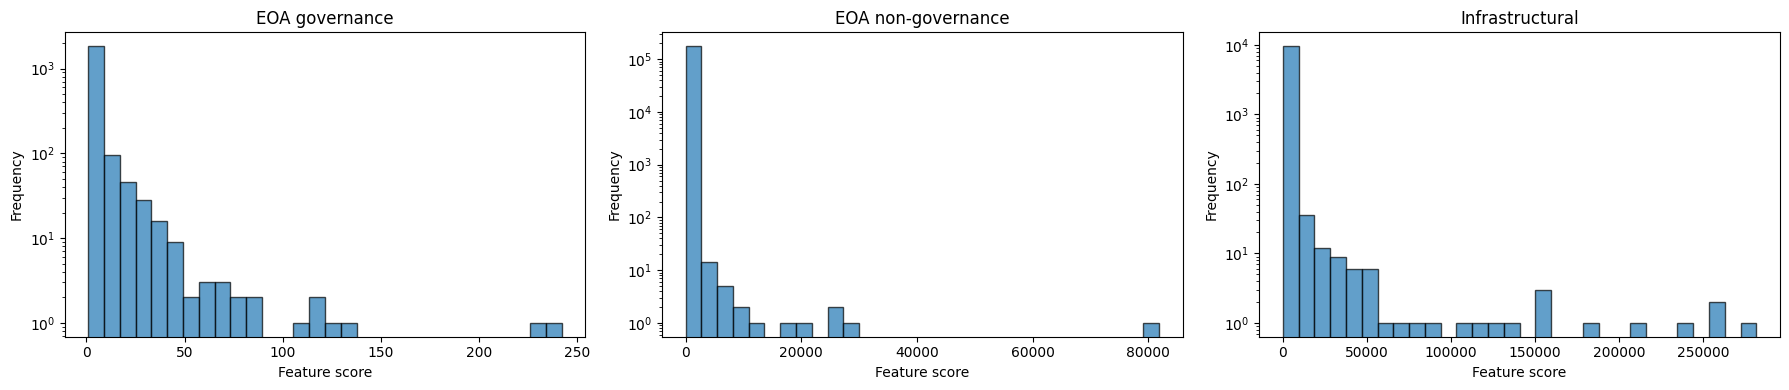

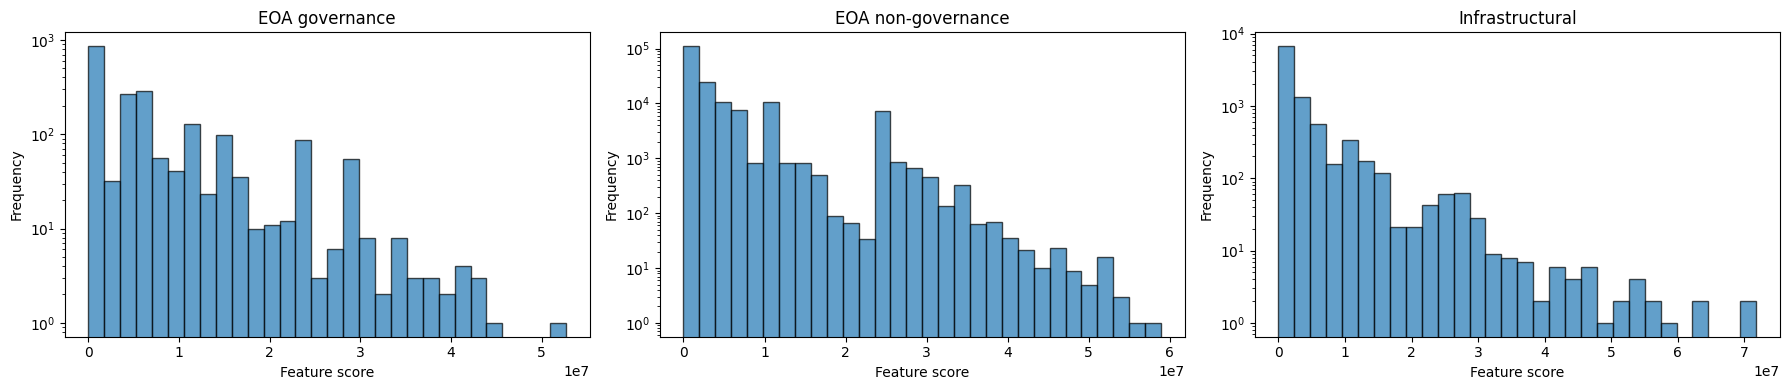

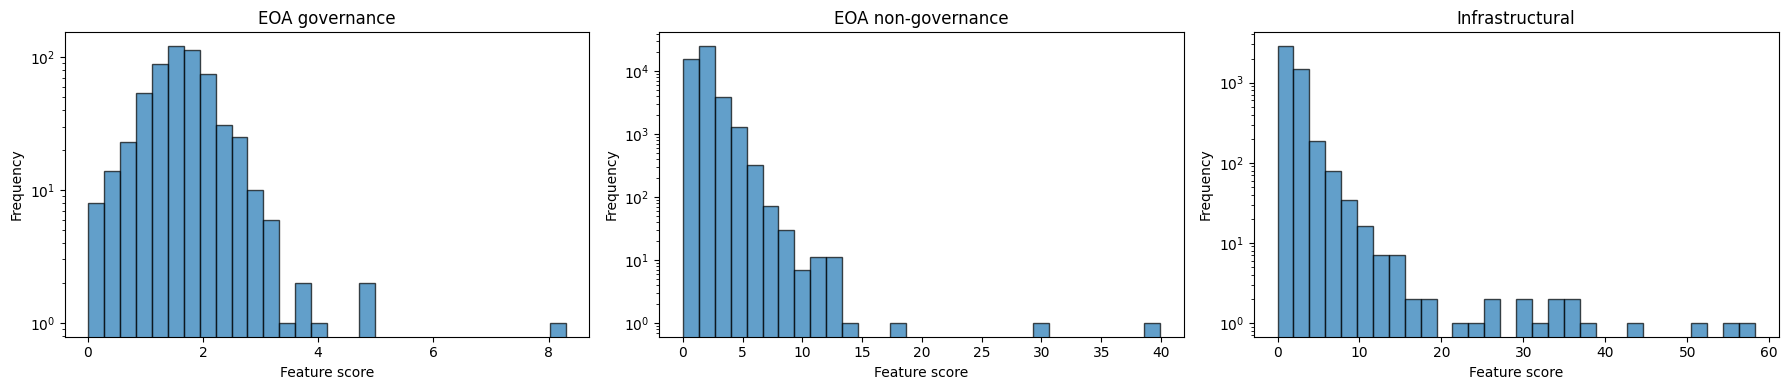

In [39]:
def plot_subset_vs_rest(feature_mapping, feature_name):
    EOA_gov_subset = [feature_mapping[node] for node in feature_mapping if node in EOA and node in governance_users_in_AAVE and node not in CEX]
    EOA_non_gov_subset = [feature_mapping[node] for node in feature_mapping if node in EOA and node not in governance_users_in_AAVE and node not in CEX]
    # CA_subset = [feature_mapping[node] for node in feature_mapping if node in CA]
    # CEX_subset = [feature_mapping[node] for node in feature_mapping if node in CEX]
    CA_CEX_subset = [feature_mapping[node] for node in feature_mapping if node in CEX or node in CA]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    # fig, axes = plt.subplots(1, 4, figsize=(24, 4))

    axes[0].hist(EOA_gov_subset, bins=30, alpha=0.7, edgecolor='black', log=True)
    axes[0].set_title('EOA governance')
    axes[0].set_xlabel('Feature score')
    axes[0].set_ylabel('Frequency')

    axes[1].hist(EOA_non_gov_subset, bins=30, alpha=0.7, edgecolor='black', log=True)
    axes[1].set_title('EOA non-governance')
    axes[1].set_xlabel('Feature score')
    axes[1].set_ylabel('Frequency')
    
    axes[2].hist(CA_CEX_subset, bins=30, alpha=0.7, edgecolor='black', log=True)
    axes[2].set_title('Infrastructural')
    axes[2].set_xlabel('Feature score')
    axes[2].set_ylabel('Frequency')
    
    # axes[2].hist(CEX_subset, bins=30, alpha=0.7, color='green', log=True)
    # axes[2].set_title(f'CEX')
    # axes[2].set_xlabel(feature_name)
    # axes[2].set_ylabel('Frequency')
    
    # axes[3].hist(CA_subset, bins=30, alpha=0.7, color='orange', log=True)
    # axes[3].set_title(f'CA')
    # axes[3].set_xlabel(feature_name)
    # axes[3].set_ylabel('Frequency')

    # fig.suptitle(f'{feature_name}', fontsize=14)
    plt.tight_layout()
    plt.show()

temp_mapping = [
    ('AAVE In-Degree Centrality', aave_igraph_in_dc),
    ('AAVE Out-Degree Centrality', aave_igraph_out_dc),
    ('AAVE Eigenvector Centrality', aave_igraph_ec),
    ('AAVE Clustering Coefficient', aave_igraph_cc),
    ('AAVE Avg. per Transfer', average_AAVE_transferred_mapping),
    # ('Total transferred', total_AAVE_transferred_mapping),
    ('AAVE Transfer Count', number_of_AAVE_transfers_mapping),
    ('AAVE 2-Hop Weight Sum', aave_igraph_2_hop_weights),
    ('AAVE Burstiness', aave_burstiness_total)
]

for feature_name, feature_mapping in temp_mapping:
    plot_subset_vs_rest(feature_mapping, feature_name)

### SI comparison

In [ ]:
with open('data/SI/aave/SI_5_extracted_seeds_avg_infected.pkl', 'rb') as f:
    SI_5_extracted = pickle.load(f)
    
with open('data/SI/aave/SI_2_extracted_seeds_avg_infected.pkl', 'rb') as f:
    SI_2_extracted = pickle.load(f)

with open('data/SI/aave/SI_1_extracted_seeds_avg_infected.pkl', 'rb') as f:
    SI_1_extracted = pickle.load(f)
    
with open('data/SI/aave/SI_05_extracted_seeds_avg_infected.pkl', 'rb') as f:
    SI_05_extracted = pickle.load(f)
    
with open('data/SI/aave/SI_01_extracted_seeds_avg_infected.pkl', 'rb') as f:
    SI_01_extracted = pickle.load(f)
    
with open('data/SI/aave/SI_001_extracted_seeds_avg_infected.pkl', 'rb') as f:
    SI_001_extracted = pickle.load(f)

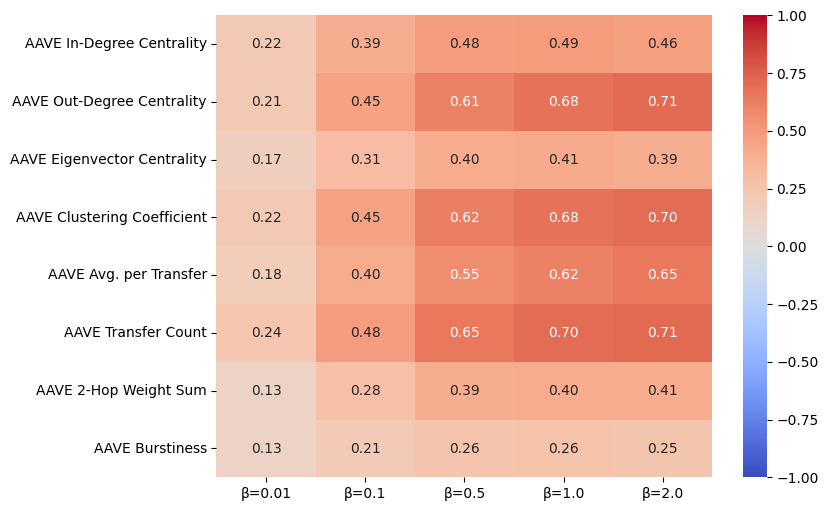

In [215]:
def compute_si_correlations(aave_mappings, si_data_list, si_labels):
    spearman_results = []
    kendall_results = []
    pearson_results = []

    for si_data, si_label in zip(si_data_list, si_labels):
        si_scores = {entry['seed']: entry['avg_infected'] for entry in si_data if entry['seed'] in all_proposers_voters_delegators_in_G_aave}

        for feature_name, feature_mapping in aave_mappings:
            valid_addresses = {address for address in feature_mapping.keys() & si_scores.keys()}# if address in EOA}

            if valid_addresses:
                feature_values = [feature_mapping[address] for address in valid_addresses]
                si_values = [si_scores[address] for address in valid_addresses]

                # spearman_corr = spearmanr(feature_values, si_values).statistic
                kendall_corr = kendalltau(feature_values, si_values).statistic
                # pearson_corr = pearsonr(feature_values, si_values).statistic

                # spearman_results.append((feature_name, si_label, spearman_corr))
                kendall_results.append((feature_name, si_label, kendall_corr))
                # pearson_results.append((feature_name, si_label, pearson_corr))

    return spearman_results, kendall_results, pearson_results

def create_correlation_heatmap(correlation_results, aave_mappings, si_labels, title):
    feature_names = [feature_name for feature_name, _ in aave_mappings]
    correlation_matrix = np.zeros((len(feature_names), len(si_labels)))

    for feature_name, si_label, correlation in correlation_results:
        feature_idx = feature_names.index(feature_name)
        si_idx = si_labels.index(si_label)
        correlation_matrix[feature_idx, si_idx] = correlation

    correlation_df = pd.DataFrame(correlation_matrix, index=feature_names, columns=si_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_df, annot=True, cmap='coolwarm', cbar=True, fmt='.2f', vmin=-1, vmax=1)
    # plt.title(title)
    # plt.xlabel('SI configuration')
    # plt.ylabel('AAVE features')
    plt.show()


si_data_list = [SI_001_extracted, SI_01_extracted, SI_05_extracted, SI_1_extracted, SI_2_extracted]#, SI_5_extracted]
si_labels = ['β=0.01', 'β=0.1', 'β=0.5', 'β=1.0', 'β=2.0']#, 'β=5.0']

spearman_results, kendall_results, pearson_results = compute_si_correlations(AAVE_mappings, si_data_list, si_labels)

# create_correlation_heatmap(spearman_results, AAVE_mappings, si_labels, "Spearman correlation")
create_correlation_heatmap(kendall_results, AAVE_mappings, si_labels, "Kendall correlation")
# create_correlation_heatmap(pearson_results, AAVE_mappings, si_labels, "Pearson correlation")

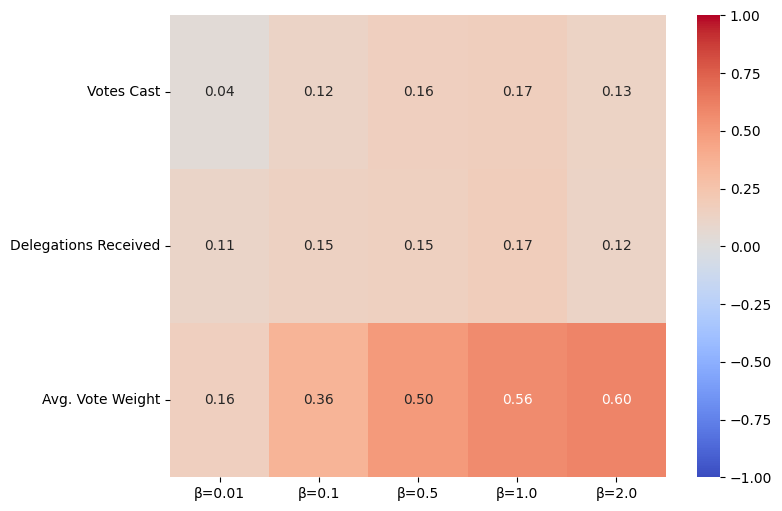

In [218]:
si_data_list = [SI_001_extracted, SI_01_extracted, SI_05_extracted, SI_1_extracted, SI_2_extracted]#, SI_5_extracted]
si_labels = ['β=0.01', 'β=0.1', 'β=0.5', 'β=1.0', 'β=2.0']#, 'β=5.0']

def compute_gov_si_correlations(gov_mappings, si_data_list, si_labels):
    kendall_results = []
    for si_data, si_label in zip(si_data_list, si_labels):
        si_scores = {entry['seed']: entry['avg_infected'] for entry in si_data}
        for feature_name, feature_mapping in gov_mappings:
            valid_addresses = feature_mapping.keys() & si_scores.keys()
            if valid_addresses:
                feature_values = [feature_mapping[address] for address in valid_addresses]
                si_values = [si_scores[address] for address in valid_addresses]
                kendall_corr = kendalltau(feature_values, si_values).statistic
                kendall_results.append((feature_name, si_label, kendall_corr))
    return kendall_results

def create_gov_si_heatmap(correlation_results, gov_mappings, si_labels, title):
    feature_names = [feature_name for feature_name, _ in gov_mappings]
    correlation_matrix = np.zeros((len(feature_names), len(si_labels)))
    for feature_name, si_label, correlation in correlation_results:
        feature_idx = feature_names.index(feature_name)
        si_idx = si_labels.index(si_label)
        correlation_matrix[feature_idx, si_idx] = correlation
    correlation_df = pd.DataFrame(correlation_matrix, index=feature_names, columns=si_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_df, annot=True, cmap='coolwarm', cbar=True, fmt='.2f', vmin=-1, vmax=1)
    # plt.title(title)
    plt.yticks(rotation=0)
    plt.show()

gov_si_kendall_results = compute_gov_si_correlations(gov_mappings, si_data_list, si_labels)
create_gov_si_heatmap(gov_si_kendall_results, gov_mappings, si_labels, "Kendall correlation (Governance vs SI)")

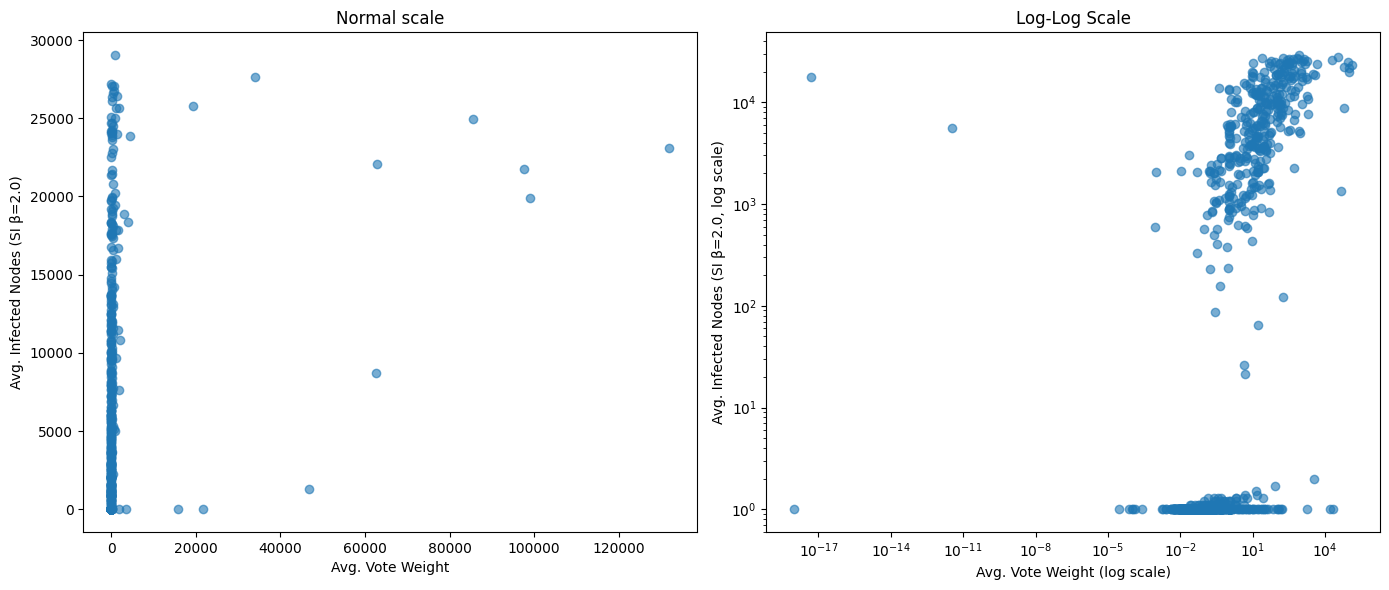

In [198]:
SI_2_mapping = {entry['seed']: entry['avg_infected'] for entry in SI_2_extracted}

valid_addresses = set(SI_2_mapping.keys()) & set(average_vote_weights_mapping.keys())

si2_vals = [SI_2_mapping[address] for address in valid_addresses]
votes_vals = [average_vote_weights_mapping[address] for address in valid_addresses]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(votes_vals, si2_vals, alpha=0.6)
axes[0].set_xlabel('Avg. Vote Weight')
axes[0].set_ylabel('Avg. Infected Nodes (SI β=2.0)')
axes[0].set_title('Normal scale')

axes[1].scatter(votes_vals, si2_vals, alpha=0.6)
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('Avg. Vote Weight (log scale)')
axes[1].set_ylabel('Avg. Infected Nodes (SI β=2.0, log scale)')
axes[1].set_title('Log-Log Scale')

plt.tight_layout()
plt.show()

In [224]:
from sklearn.metrics import ndcg_score
from scipy.stats import rankdata

def compute_ndcg(si_scores, si_label, other_feature_scores, other_feature_label, k=None):
    si_mapping = {entry['seed']: entry['avg_infected'] for entry in si_scores}
    common_addresses = set(si_mapping.keys()) & set(other_feature_scores.keys())

    si_scores = [si_mapping[addr] for addr in common_addresses]
    vote_weight_scores = [other_feature_scores[addr] for addr in common_addresses]

    si_ranks = rankdata(si_scores, method="average")
    vote_ranks = rankdata(vote_weight_scores, method="average")
    print(si_label)
    # ndcg = ndcg_score([vote_ranks], [si_ranks])
    # print(f'Ranked: {ndcg}')
    # ndcg = ndcg_score([si_ranks], [vote_ranks])
    # print(ndcg)

    ndcg = ndcg_score([vote_weight_scores], [si_scores])
    print(f'Raw: {ndcg}')
    # ndcg = ndcg_score([si_scores], [vote_weight_scores])
    # print(ndcg)

In [226]:
si_data_list = [SI_001_extracted, SI_01_extracted, SI_05_extracted, SI_1_extracted, SI_2_extracted]#, SI_5_extracted]
si_labels = ['β=0.01', 'β=0.1', 'β=0.5', 'β=1.0', 'β=2.0']#, 'β=5.0']

for si_data, si_label in zip(si_data_list, si_labels):
    compute_ndcg(si_data, si_label, average_vote_weights_mapping, 'Avg. Vote Weight')

β=0.01
Raw: 0.2381694364830766
β=0.1
Raw: 0.4185548106573398
β=0.5
Raw: 0.43835317116082434
β=1.0
Raw: 0.4411026077795252
β=2.0
Raw: 0.40294394306740206


In [203]:
def dcg(relevance_scores, k):
    relevance_scores = np.asfarray(relevance_scores)[:k]
    return np.sum(relevance_scores / np.log2(np.arange(2, k + 2)))

def ndcg(si_outcome: list, vote_weights: dict, k: int = None):
    seeds_with_vote = [entry for entry in si_outcome if entry['seed'] in vote_weights]
    
    if not seeds_with_vote:
        return 0
    
    sorted_seeds = sorted(seeds_with_vote, key=lambda x: x['avg_infected'], reverse=True)
    
    rel_pred = [vote_weights[entry['seed']] for entry in sorted_seeds]
    
    ideal_sorted = sorted(seeds_with_vote, key=lambda x: vote_weights[x['seed']], reverse=True)
    rel_ideal = [vote_weights[entry['seed']] for entry in ideal_sorted]

    k = k or len(rel_pred)

    dcg_val = dcg(rel_pred, k)
    idcg_val = dcg(rel_ideal, k)

    return dcg_val / idcg_val if idcg_val > 0 else 0

for si_data in si_data_list:
    print(ndcg(si_data, average_vote_weights_mapping))

0.22349641273513243
0.4172571797095642
0.43837128811122555
0.44109358677965305
0.40245722806226714
0.31734106547104357


## aToken analysis

In [131]:
combined_tokens = {
    'USDC': ['aEthUSDC', 'aPolUSDC', 'aArbUSDC'],
    'USDT': ['aEthUSDT', 'aPolUSDT', 'aArbUSDT'],
    'WETH': ['aEthWETH', 'aPolWETH', 'aArbWETH']
}

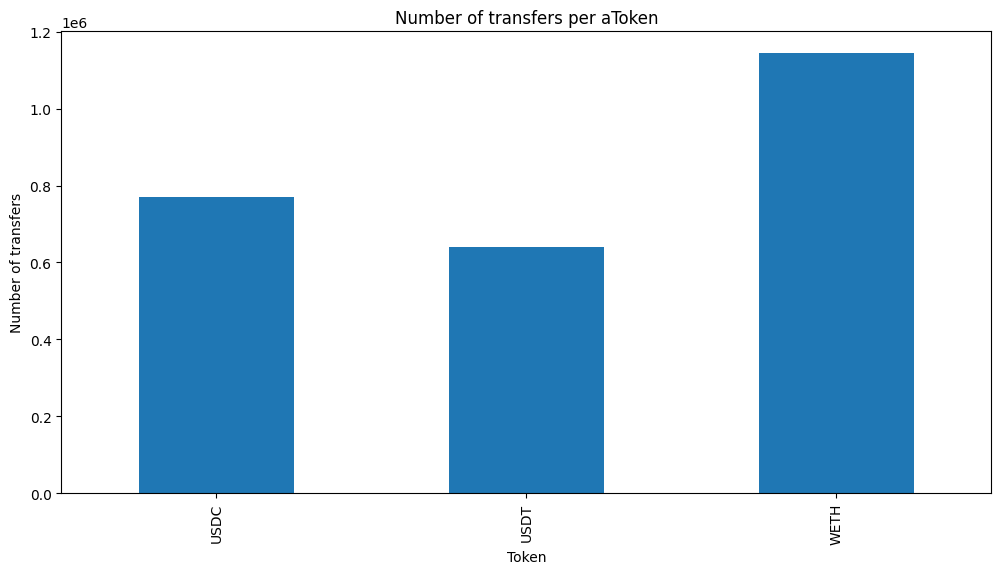

In [134]:
# transfers_per_token = aToken_df.groupby('token').size()

transfers_per_token = pd.Series({token: transfers_per_token.loc[names].sum() for token, names in combined_tokens.items()})

plt.figure(figsize=(12, 6))
transfers_per_token.plot(kind='bar')
plt.xlabel('Token')
plt.ylabel('Number of transfers')
plt.title('Number of transfers per aToken')
plt.show()

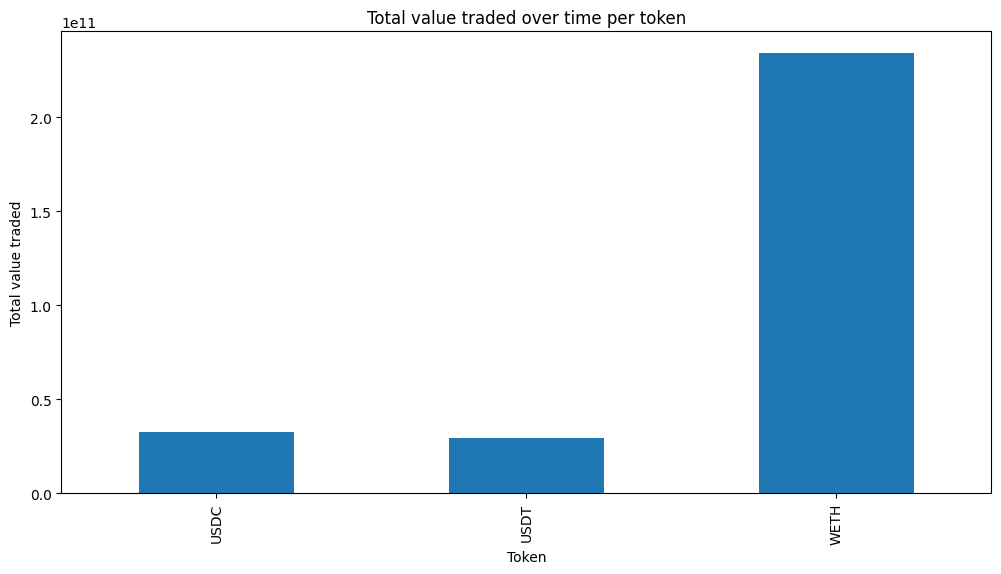

In [132]:
# price_data = pd.read_csv('data/WETH_daily_USD.csv', parse_dates=['snapped_at'])

# price_data['date'] = pd.to_datetime(price_data['snapped_at']).dt.date
# aToken_df['date'] = pd.to_datetime(aToken_df['timestamp'], unit='s')
# aToken_df['date'] = aToken_df['date'].dt.date

# aToken_df2 = aToken_df.merge(price_data[['date', 'price']], on='date', how='left')

# tokens_to_multiply = ['aArbWETH', 'aEthWETH', 'aPolWETH']

# aToken_df2['value_traded'] = aToken_df2.apply(
#     lambda row: row['value'] * row['price'] if row['token'] in tokens_to_multiply else row['value'], axis=1
# )

# transfers_over_time_per_token = aToken_df2.groupby('token')['value_traded'].sum()

transfers_over_time_per_token = pd.Series({token: transfers_over_time_per_token.loc[names].sum() for token, names in combined_tokens.items()})

plt.figure(figsize=(12, 6))
transfers_over_time_per_token.plot(kind='bar')
plt.xlabel('Token')
plt.ylabel('Total value traded')
plt.title('Total value traded over time per token')
plt.show()

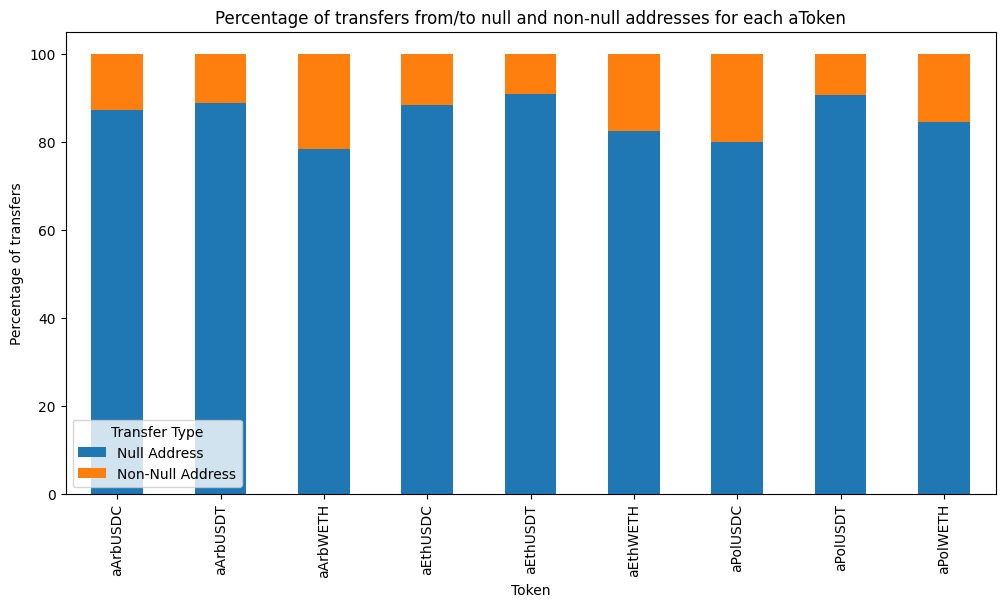

In [ ]:
null_address = '0x0000000000000000000000000000000000000000'

total_transfers_per_token = aToken_df['token'].value_counts()

null_address_transfers_per_token = aToken_df[(aToken_df['from'].str.lower() == null_address) | (aToken_df['to'].str.lower() == null_address)].groupby('token').size()

percentage_null_address_transfers = (null_address_transfers_per_token / total_transfers_per_token) * 100

percentage_non_null_address_transfers = 100 - percentage_null_address_transfers

percentage_transfers_df = pd.DataFrame({
    'Null Address': percentage_null_address_transfers,
    'Non-Null Address': percentage_non_null_address_transfers
}).fillna(0)

percentage_transfers_df.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.xlabel('Token')
plt.ylabel('Percentage of transfers')
plt.title('Percentage of transfers from/to null and non-null addresses for each aToken')
plt.legend(title='Transfer Type')
plt.show()

## Venn diagrams

<Axes: >

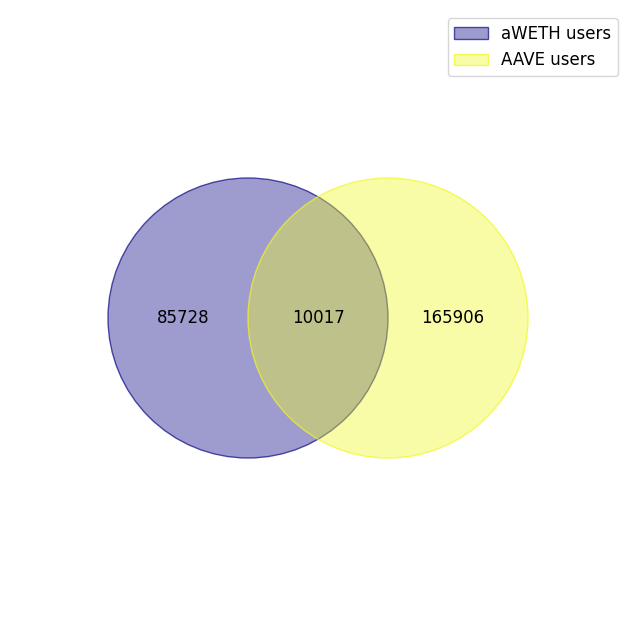

In [ ]:
subsets = {
    'aWETH users': set(G_aToken_nodes),
    'AAVE users': set(G_aave_nodes)
}

venn(subsets, fmt="{size}", cmap='plasma', fontsize=12)

<Axes: >

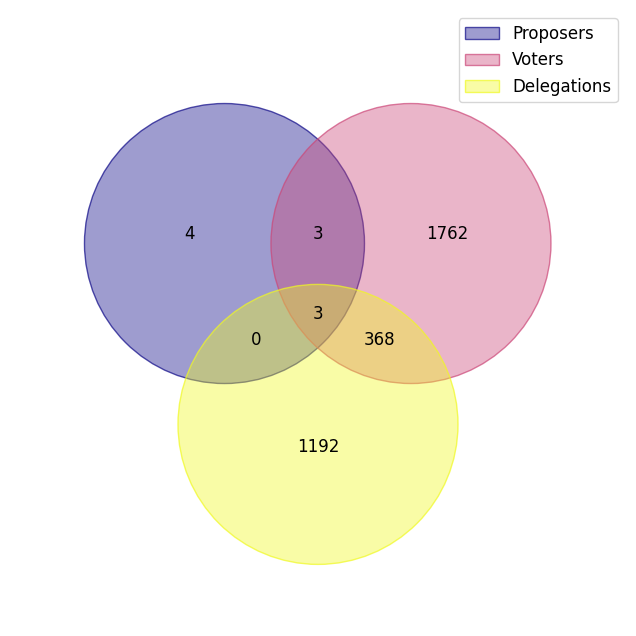

In [34]:
subsets = {
    'Proposers': v2_proposers | v3_proposers,
    'Voters': v2_voters | v3_voters,
    'Delegations': delegators
}

venn(subsets, fmt="{size}", cmap='plasma', fontsize=12)

<Axes: >

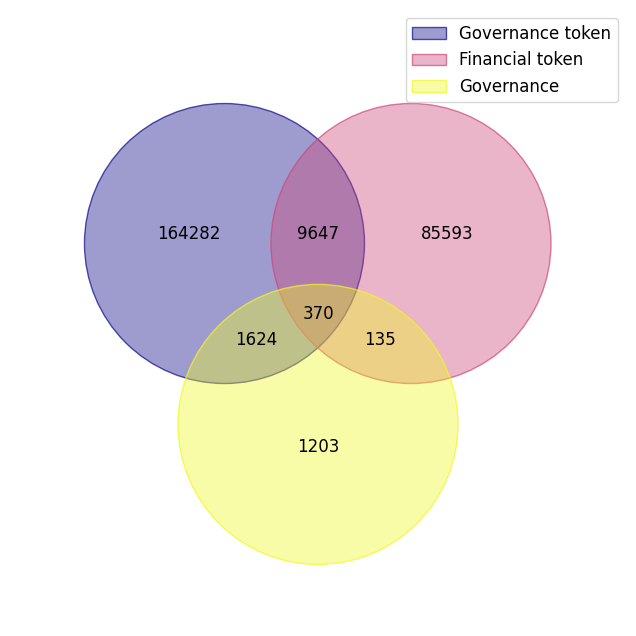

In [35]:
subsets = {
    "Governance token": G_aave_nodes,
    "Financial token": G_aToken_nodes,
    "Governance": (v2_proposers | v3_proposers| v2_voters | v3_voters | delegators)
}

venn(subsets, fmt="{size}", cmap='plasma', fontsize=12)

## Community detection

### VI, NMI, AMI & ARI

In [ ]:
def entropy(labels):
    total = len(labels)
    counts = Counter(labels)
    
    return -sum((count/total) * log2(count/total) for count in counts.values())

def mutual_information(x, y):
    total = len(x)
    counter_x = Counter(x)
    counter_y = Counter(y)
    joint_counter = Counter(zip(x, y))
    mi = 0.0
    
    for (x_val, y_val), joint_count in joint_counter.items():
        px = counter_x[x_val] / total
        py = counter_y[y_val] / total
        pxy = joint_count / total
        mi += pxy * log2(pxy / (px * py))
    
    return mi

def variation_of_information(x, y):
    return entropy(x) + entropy(y) - 2 * mutual_information(x, y)

def run_leiden_iterations(graph, n_iterations=10, resolution=1.0):
    memberships = []
    
    for i in range(n_iterations):
        partition = la.find_partition(
            graph,
            la.ModularityVertexPartition,
            weights='weight'
        )
        print(i, partition.modularity)
        
        memberships.append(partition.membership)
    
    return memberships

def compute_vi_nmi_ami_ari(memberships):
    n = len(memberships)
    vi_scores = np.zeros((n, n))
    nmi_scores = np.zeros((n, n))
    ami_scores = np.zeros((n, n))
    ari_scores = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i, n):
            vi = variation_of_information(memberships[i], memberships[j])
            nmi = normalized_mutual_info_score(memberships[i], memberships[j])
            ami = adjusted_mutual_info_score(memberships[i], memberships[j])
            ari = adjusted_rand_score(memberships[i], memberships[j])
            
            vi_scores[i, j] = vi_scores[j, i] = vi
            nmi_scores[i, j] = nmi_scores[j, i] = nmi
            ami_scores[i, j] = ami_scores[j, i] = ami
            ari_scores[i, j] = ari_scores[j, i] = ari
    return vi_scores, nmi_scores, ami_scores, ari_scores

In [ ]:
G_aave_igraph = ig.Graph.from_networkx(G_aave, vertex_attr_hashable='name')
G_aave_count_igraph = ig.Graph.from_networkx(G_aave_count, vertex_attr_hashable='name')

In [ ]:
n_iterations = 100
resolution = 1.0
memberships = run_leiden_iterations(G_aave_igraph, n_iterations, resolution)

vi_scores, nmi_scores, ami_scores, ari_scores = compute_vi_nmi_ami_ari(memberships)

avg_vi = np.mean(vi_scores[np.triu_indices(n_iterations, k=1)])
avg_nmi = np.mean(nmi_scores[np.triu_indices(n_iterations, k=1)])
avg_ami = np.mean(ami_scores[np.triu_indices(n_iterations, k=1)])
avg_ari = np.mean(ari_scores[np.triu_indices(n_iterations, k=1)])

print(f"Average VI: {avg_vi:.4f}")
print(f"Average NMI: {avg_nmi:.4f}")
print(f"Average AMI: {avg_ami:.4f}")
print(f"Average ARI: {avg_ari:.4f}")

In [ ]:
n_iterations = 100
resolution = 1.0
memberships = run_leiden_iterations(G_aave_count_igraph, n_iterations, resolution)

vi_scores, nmi_scores, ami_scores, ari_scores = compute_vi_nmi_ami_ari(memberships)

avg_vi = np.mean(vi_scores[np.triu_indices(n_iterations, k=1)])
avg_nmi = np.mean(nmi_scores[np.triu_indices(n_iterations, k=1)])
avg_ami = np.mean(ami_scores[np.triu_indices(n_iterations, k=1)])
avg_ari = np.mean(ari_scores[np.triu_indices(n_iterations, k=1)])

print(f"Average VI: {avg_vi:.4f}")
print(f"Average NMI: {avg_nmi:.4f}")
print(f"Average AMI: {avg_ami:.4f}")
print(f"Average ARI: {avg_ari:.4f}")

### Regular Leiden

#### Basic analysis

In [23]:
G_aave_count_igraph = ig.Graph.from_networkx(G_aave_count, vertex_attr_hashable='name')

G_aave_count_igraph_components = G_aave_count_igraph.connected_components(mode="weak")
G_aave_count_igraph_largest_wcc = G_aave_count_igraph_components.giant()

partition = la.find_partition(G_aave_count_igraph_largest_wcc, la.ModularityVertexPartition, weights='weight')

print(len(partition), partition.modularity)

129 0.6283457506083547


In [39]:
print(len(G_aave_count_igraph.vs), len(G_aave_count_igraph_largest_wcc.vs))

175923 175923


In [33]:
non_WCC_nodes = set(G_aave_count_igraph.vs['name']) - set(G_aave_count_igraph_largest_wcc.vs['name'])

In [35]:
print(len(non_WCC_nodes))
print(len(non_WCC_nodes & CEX))
print(len(non_WCC_nodes & CA))
print(len(non_WCC_nodes & EOA & all_proposers_voters_delegators_in_G_aave))
print(len(non_WCC_nodes & (EOA - all_proposers_voters_delegators_in_G_aave - CEX)))

12546
13
335
92
12106


In [ ]:
G_W_communities = 0
G_C_communities = 0

G_W_modularity = 0
G_C_modularity = 0

for i in range(100):
    print(i)
    
    p1 = la.find_partition(G_aave_igraph, la.ModularityVertexPartition, weights='weight')
    p2 = la.find_partition(G_aave_count_igraph, la.ModularityVertexPartition, weights='weight')
    
    G_W_communities += len(p1)
    G_C_communities += len(p2)
    
    G_W_modularity += p1.modularity
    G_C_modularity += p2.modularity
    
average_G_W_size = G_W_communities / 100
average_G_C_size = G_C_communities / 100

average_G_W_mod = G_W_modularity / 100
average_G_C_mod = G_C_modularity / 100

print(f'Communities: G_W: {average_G_W_size}, G_C: {average_G_C_size}')
print(f'Modularity: G_W: {average_G_W_mod}, G_C: {average_G_C_mod}')

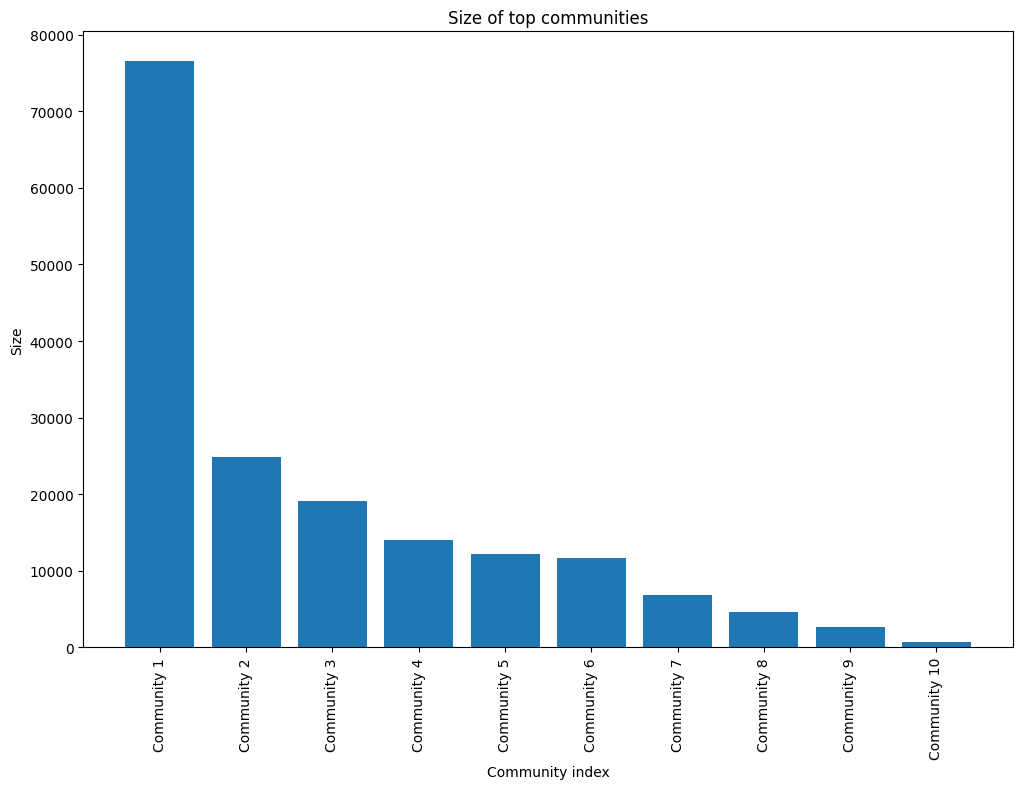

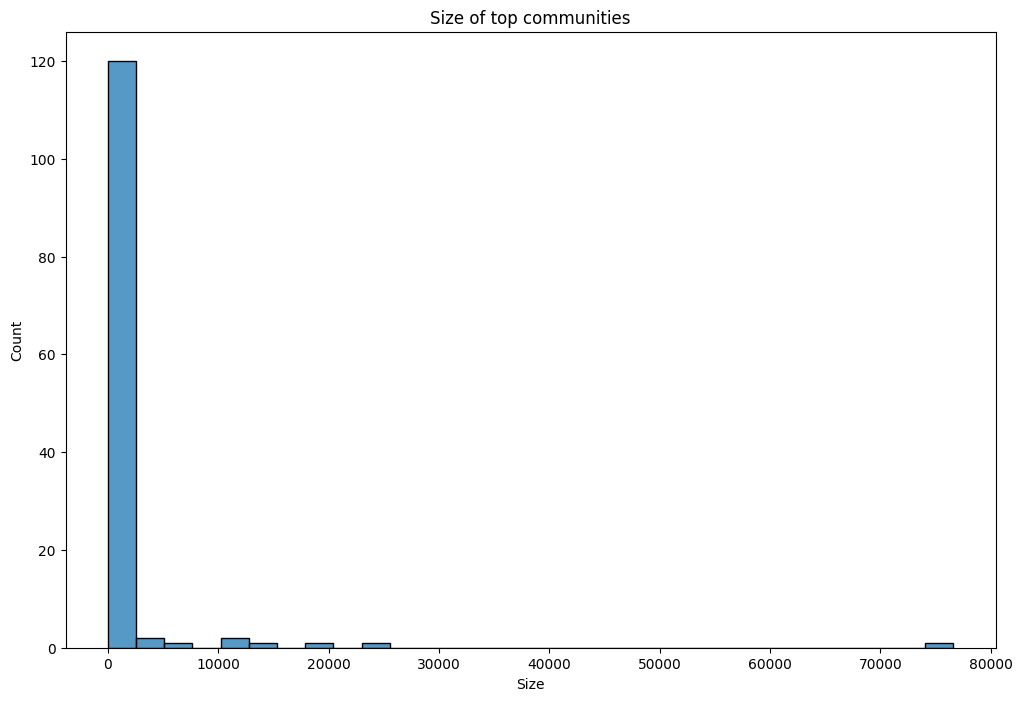

In [24]:
community_sizes = [len(c) for c in partition]

sorted_indices = sorted(range(len(community_sizes)), key=lambda i: community_sizes[i], reverse=True)

sorted_communities = [partition[i] for i in sorted_indices]

top_communities = sorted_communities[:10]

top_communities_sizes = [len(community) for community in top_communities]

plt.figure(figsize=(12, 8))
plt.bar(range(len(top_communities)), top_communities_sizes)
plt.xlabel('Community index')
plt.ylabel('Size')
plt.title('Size of top communities')
plt.xticks(range(len(top_communities)), [f'Community {i+1}' for i in range(len(top_communities))], rotation=90)
plt.show()

all_communities_sizes = [len(community) for community in sorted_communities]
log_bins = np.logspace(np.log10(min(all_communities_sizes)), np.log10(max(all_communities_sizes)), 30)

plt.figure(figsize=(12, 8))
sns.histplot(all_communities_sizes, bins=30)
# plt.yscale('log')
# sns.histplot(all_communities_sizes, bins=log_bins)
# plt.xscale('log')
plt.xlabel('Size')
plt.ylabel('Count')
plt.title('Size of top communities')
plt.show()

communities_with_ids = [
    {G_aave_count_igraph_largest_wcc.vs[idx]["name"] for idx in community} for community in top_communities
]

In [17]:
community_distribution = {
    'Economic': [],
    'Governance': [],
    'Both': [],
    'None': []
}

only_economic_users_in_G_wcc = only_economic_users_in_G_aave & set(G_aave_count_igraph_largest_wcc.vs["name"])
only_voters_in_G_wcc = only_voters_in_G_aave & set(G_aave_count_igraph_largest_wcc.vs["name"])
both_economic_and_governance_users_in_G_wcc = both_economic_and_governance_users & set(G_aave_count_igraph_largest_wcc.vs["name"])
all_economic_users_in_G_wcc = all_economic_users_in_G_aave & set(G_aave_count_igraph_largest_wcc.vs["name"])
all_voters_in_G_wcc = all_voters_in_G_aave & set(G_aave_count_igraph_largest_wcc.vs["name"])

for community in communities_with_ids:
    economic_count = len(only_economic_users_in_G_wcc & community)
    governance_count = len(only_voters_in_G_wcc & community)
    both_count = len(both_economic_and_governance_users_in_G_wcc & community)
    none_count = len(community) - economic_count - governance_count - both_count
    
    community_distribution['Economic'].append(economic_count)
    community_distribution['Governance'].append(governance_count)
    community_distribution['Both'].append(both_count)
    community_distribution['None'].append(none_count)

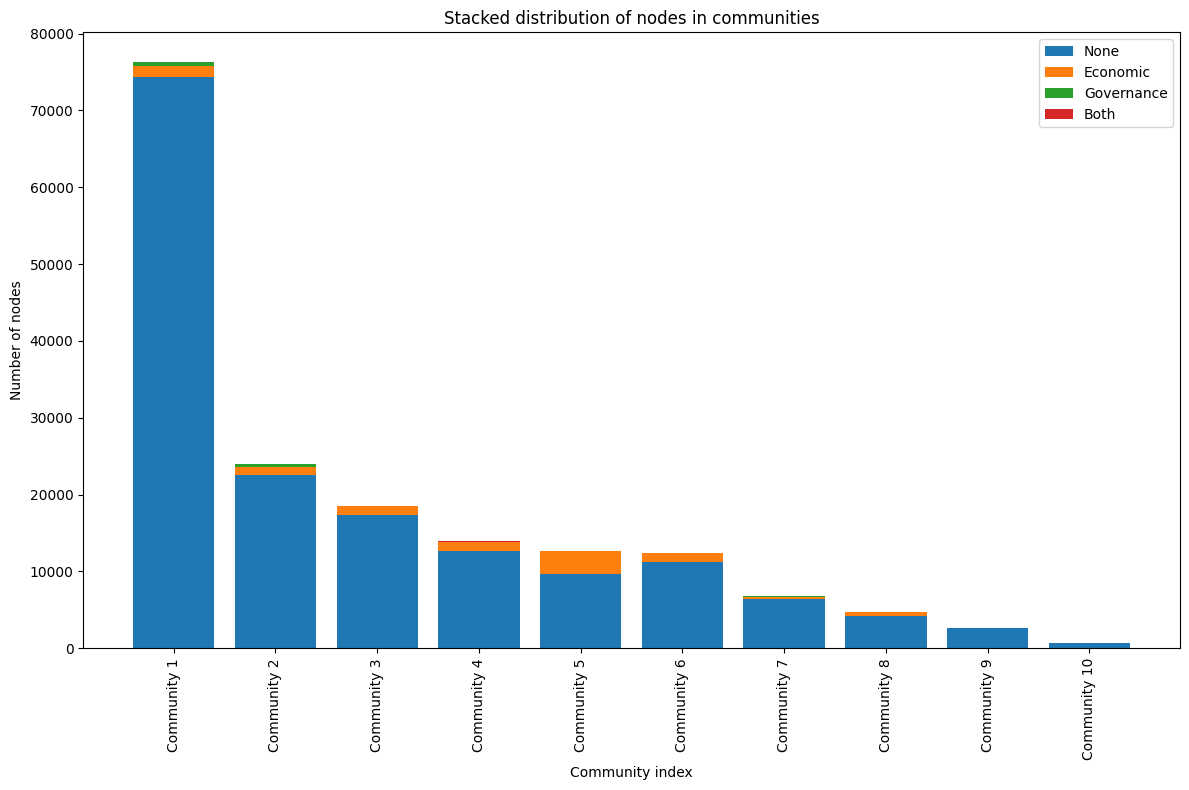

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

bar_width = 0.8
index = np.arange(len(communities_with_ids))

economic_array = np.array(community_distribution['Economic'])
governance_array = np.array(community_distribution['Governance'])
both_array = np.array(community_distribution['Both'])
none_array = np.array(community_distribution['None'])

bar1 = ax.bar(index, none_array, bar_width, label='None')
bar2 = ax.bar(index, economic_array, bar_width, bottom=none_array, label='Economic')
bar3 = ax.bar(index, governance_array, bar_width, bottom=none_array + economic_array, label='Governance')
bar4 = ax.bar(index, both_array, bar_width, bottom=none_array + economic_array + governance_array, label='Both')

ax.set_xlabel('Community index')
ax.set_ylabel('Number of nodes')
ax.set_title('Stacked distribution of nodes in communities')
ax.set_xticks(index)
ax.set_xticklabels([f'Community {i+1}' for i in range(len(communities_with_ids))], rotation=90)
ax.legend()

plt.tight_layout()
plt.show()

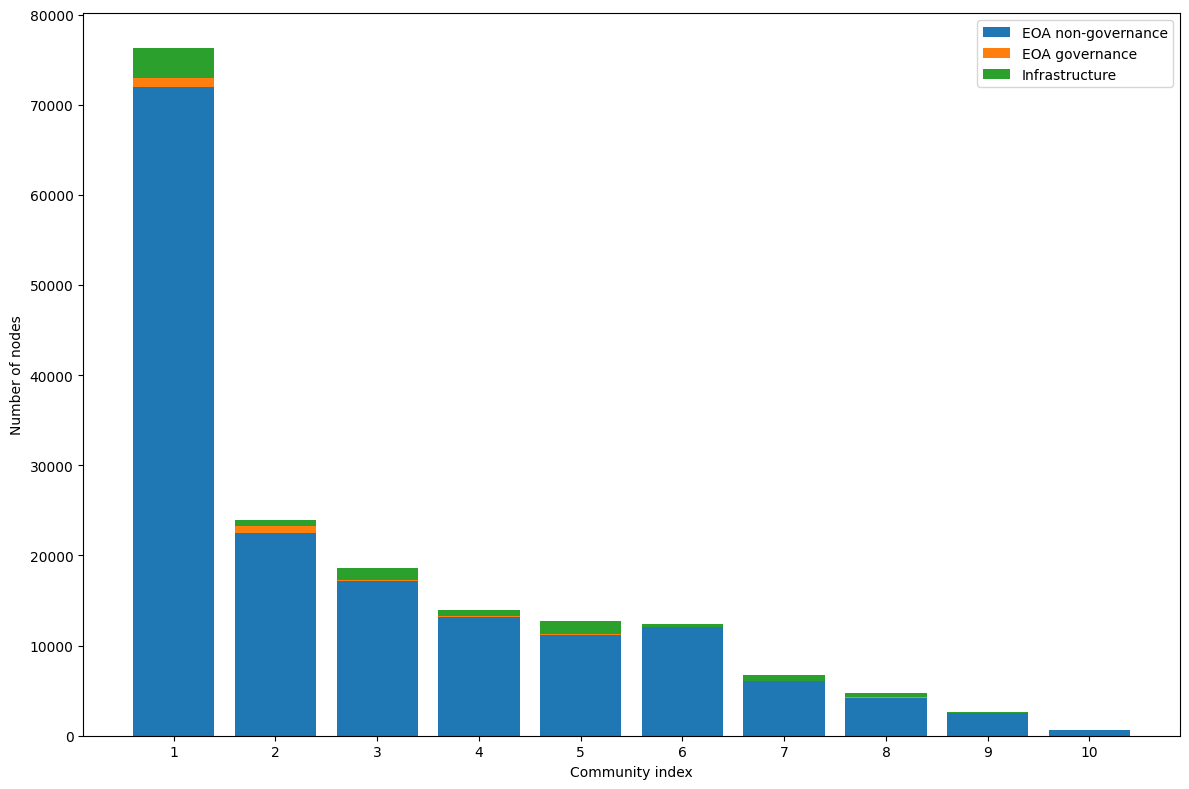

In [19]:
community_distribution_2 = {
    'EOA gov': [],
    'EOA non gov': [],
    'CEX': [],
    'CA': []
}

total_EOA_gov_percentage = 0
total_EOA_non_gov_percentage = 0
total_CEX_percentage = 0
total_CA_percentage = 0

EOA_gov_percentages = []
EOA_non_gov_percentages = []
CEX_percentages = []
CA_percentages = []

id = 1
for community in communities_with_ids:
    EOA_gov_count = len(community & (EOA & all_proposers_voters_delegators_in_G_aave))
    EOA_non_gov_count = len(community & (EOA - all_proposers_voters_delegators_in_G_aave - CEX))
    CEX_count = len(community & CEX)
    CA_count = len(community & CA)
    
    community_distribution_2['EOA gov'].append(EOA_gov_count)
    community_distribution_2['EOA non gov'].append(EOA_non_gov_count)
    community_distribution_2['CEX'].append(CEX_count)
    community_distribution_2['CA'].append(CA_count)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

bar_width = 0.8
index = np.arange(len(communities_with_ids))

EOA_gov_array = np.array(community_distribution_2['EOA gov'])
EOA_non_gov_array = np.array(community_distribution_2['EOA non gov'])
CEX_array = np.array(community_distribution_2['CEX'])
CA_array = np.array(community_distribution_2['CA'])

bar1 = ax.bar(index, EOA_non_gov_array, bar_width, label='EOA non-governance')
bar2 = ax.bar(index, EOA_gov_array, bar_width, bottom=EOA_non_gov_array, label='EOA governance')
bar3 = ax.bar(index, CA_array + CEX_array, bar_width, bottom=EOA_non_gov_array + EOA_gov_array, label='Infrastructure')

ax.set_xlabel('Community index')
ax.set_ylabel('Number of nodes')
# ax.set_title('Distribution of nodes per community')
ax.set_xticks(index)
ax.set_xticklabels([f'{i+1}' for i in range(len(communities_with_ids))])
# ax.set_xticklabels([f'Community {i+1}' for i in range(len(communities_with_ids))], rotation=90)
ax.legend()

plt.tight_layout()
plt.show()

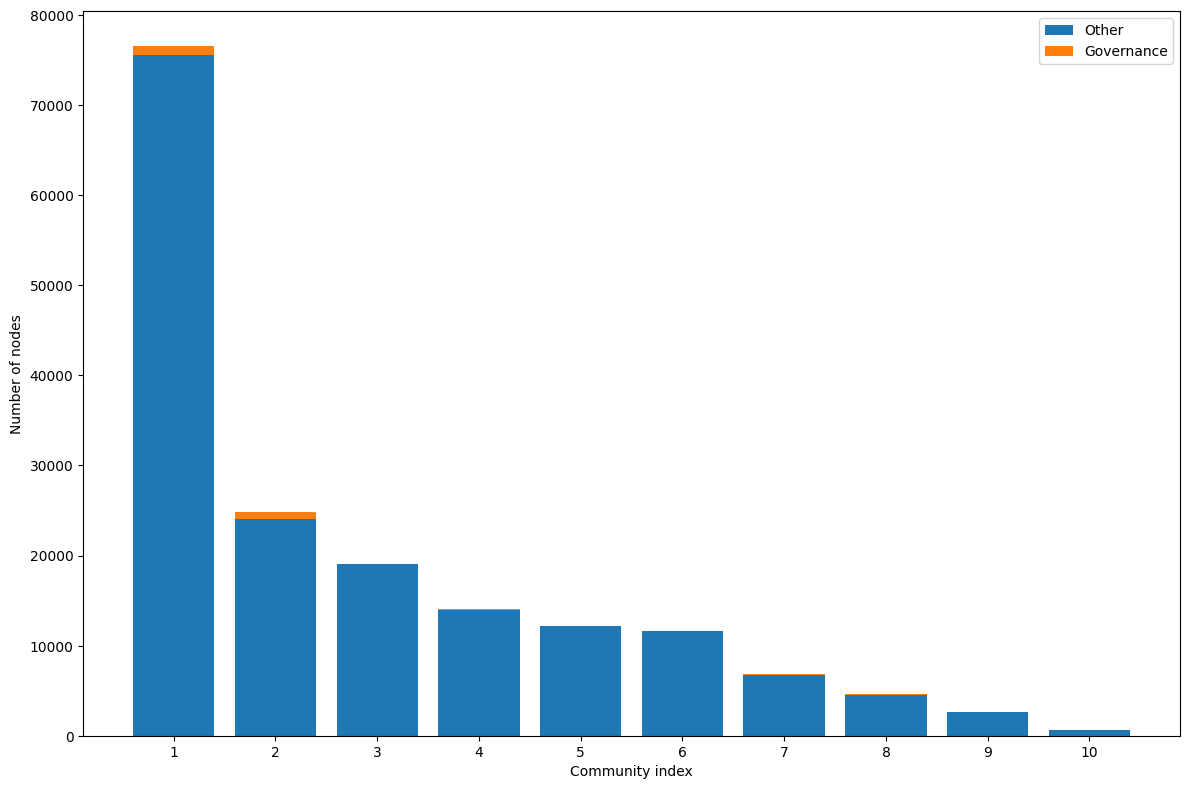

In [25]:
community_distribution_3 = {
    'gov': [],
    'other': []
}

total_gov_percentage = 0
total_other_percentage = 0

gov_percentages = []
other_percentages = []

id = 1
for community in communities_with_ids:
    gov_count = len(community & all_proposers_voters_delegators_in_G_aave)
    other_count = len(community) - gov_count
    
    community_distribution_3['gov'].append(gov_count)
    community_distribution_3['other'].append(other_count)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

bar_width = 0.8
index = np.arange(len(communities_with_ids))

gov_array = np.array(community_distribution_3['gov'])
other_array = np.array(community_distribution_3['other'])

bar1 = ax.bar(index, other_array, bar_width, label='Other')
bar2 = ax.bar(index, gov_array, bar_width, bottom=other_array, label='Governance')

ax.set_xlabel('Community index')
ax.set_ylabel('Number of nodes')
# ax.set_title('Distribution of nodes per community')
ax.set_xticks(index)
ax.set_xticklabels([f'{i+1}' for i in range(len(communities_with_ids))])
# ax.set_xticklabels([f'Community {i+1}' for i in range(len(communities_with_ids))], rotation=90)
ax.legend()

plt.tight_layout()
plt.show()

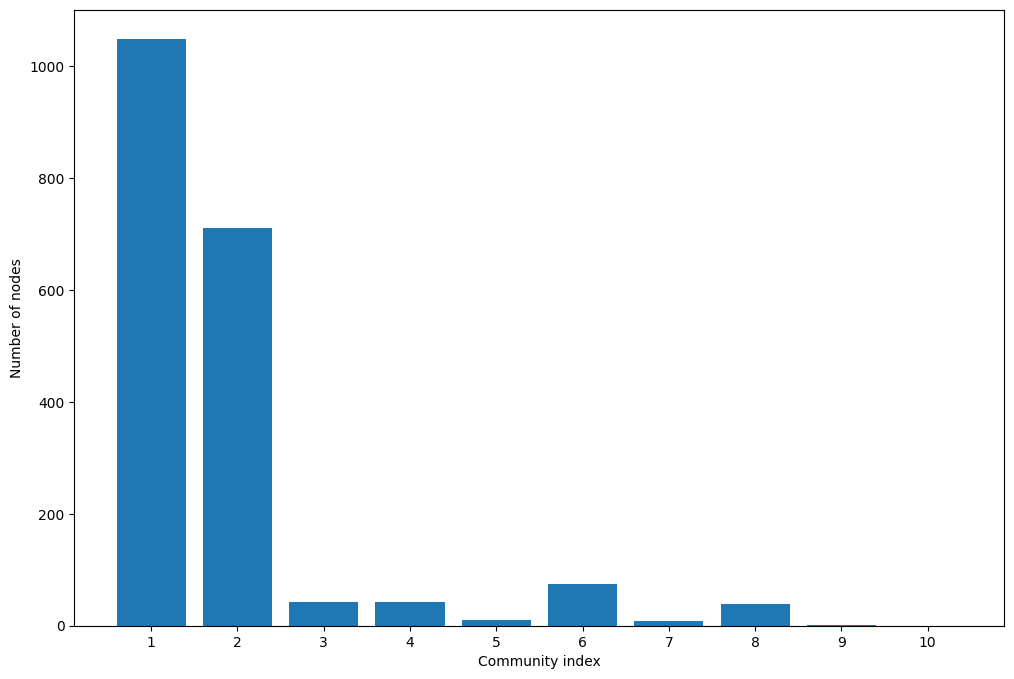

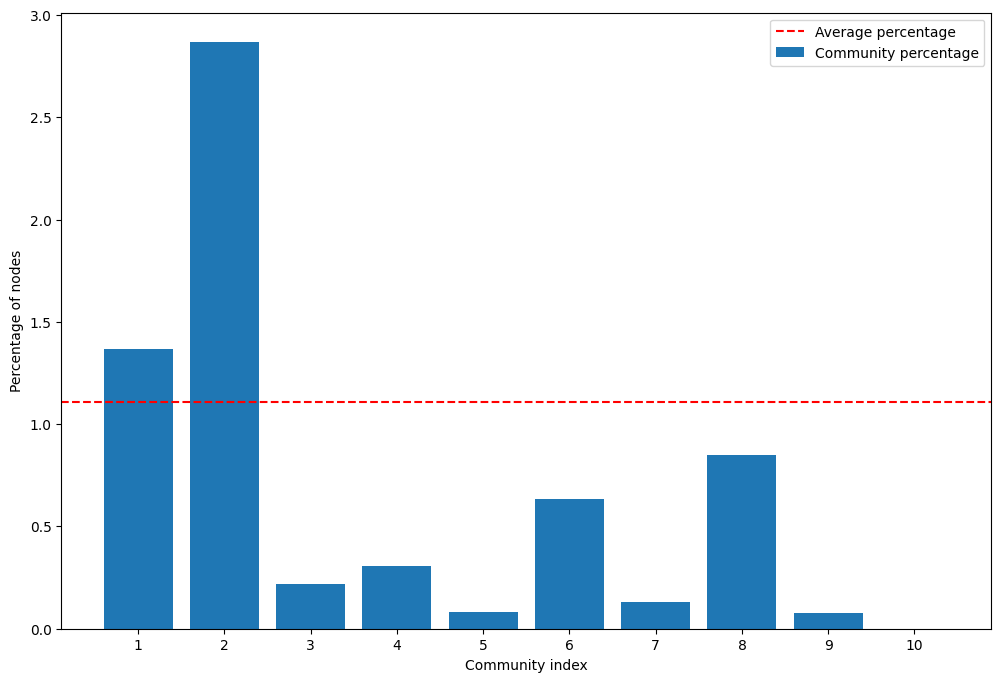

In [26]:
# gov_array = np.array(community_distribution_2['EOA gov'])
# CEX_array = np.array(community_distribution_2['CEX'])
# CA_array = np.array(community_distribution_2['CA'])

total_gov_percentage = (len(all_proposers_voters_delegators_in_G_aave) / len(G_aave_nodes)) * 100

community_gov_percentages = []

for i in range(len(gov_array)):
    gov_percentage = (gov_array[i] / len(communities_with_ids[i])) * 100
    community_gov_percentages.append(gov_percentage)

plt.figure(figsize=(12, 8))
plt.bar(range(len(gov_array)), gov_array)#, color='orange')
plt.xlabel('Community index')
plt.ylabel('Number of nodes')
# plt.title('Percentage of governance nodes per community vs total governance percentage')
# plt.legend()
plt.xticks(range(len(top_communities)), [f'{i+1}' for i in range(len(top_communities))])
plt.show()

plt.figure(figsize=(12, 8))
plt.bar(range(len(top_communities)), community_gov_percentages, label='Community percentage')
plt.axhline(y=total_gov_percentage, color='r', linestyle='--', label='Average percentage')
plt.xlabel('Community index')
plt.ylabel('Percentage of nodes')
# plt.title('Percentage of governance nodes per community vs total governance percentage')
plt.legend()
plt.xticks(range(len(top_communities)), [f'{i+1}' for i in range(len(top_communities))])
plt.show()

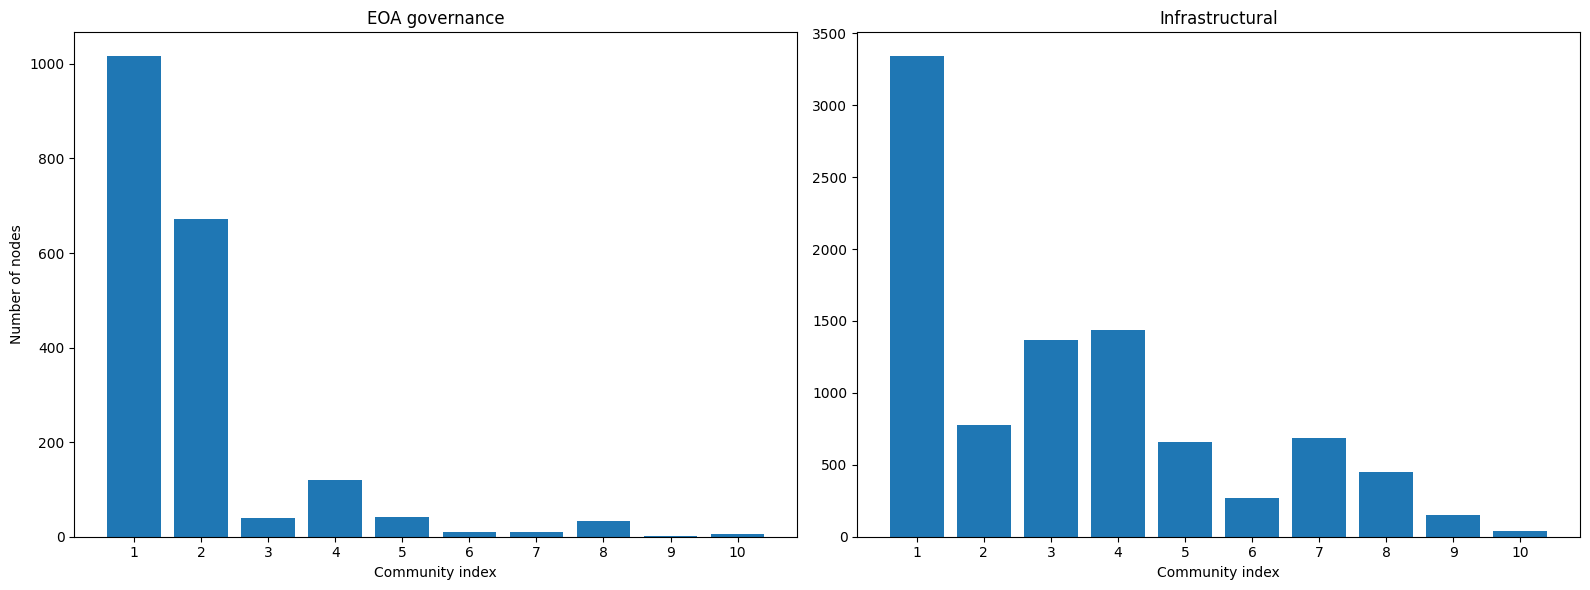

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

axs[0].bar(range(len(EOA_gov_array)), EOA_gov_array)#, color='orange')
# axs[0].axhline(y=total_EOA_gov_percentage, color='r', linestyle='--', label='Total EOA percentage')
axs[0].set_xlabel('Community index')
axs[0].set_ylabel('Number of nodes')
axs[0].set_title('EOA governance')
# axs[0].legend()
axs[0].set_xticks(range(len(top_communities)))
axs[0].set_xticklabels([f'{i+1}' for i in range(len(top_communities))])

infra_array = CA_array + CEX_array
axs[1].bar(range(len(infra_array)), infra_array)#, color='green')
# axs[1].axhline(y=total_CEX_percentage + total_CA_percentage, color='r', linestyle='--', label='Total percentage')
axs[1].set_xlabel('Community index')
axs[1].set_title('Infrastructural')
# axs[1].legend()
axs[1].set_xticks(range(len(top_communities)))
axs[1].set_xticklabels([f'{i+1}' for i in range(len(top_communities))])

plt.tight_layout()
plt.show()

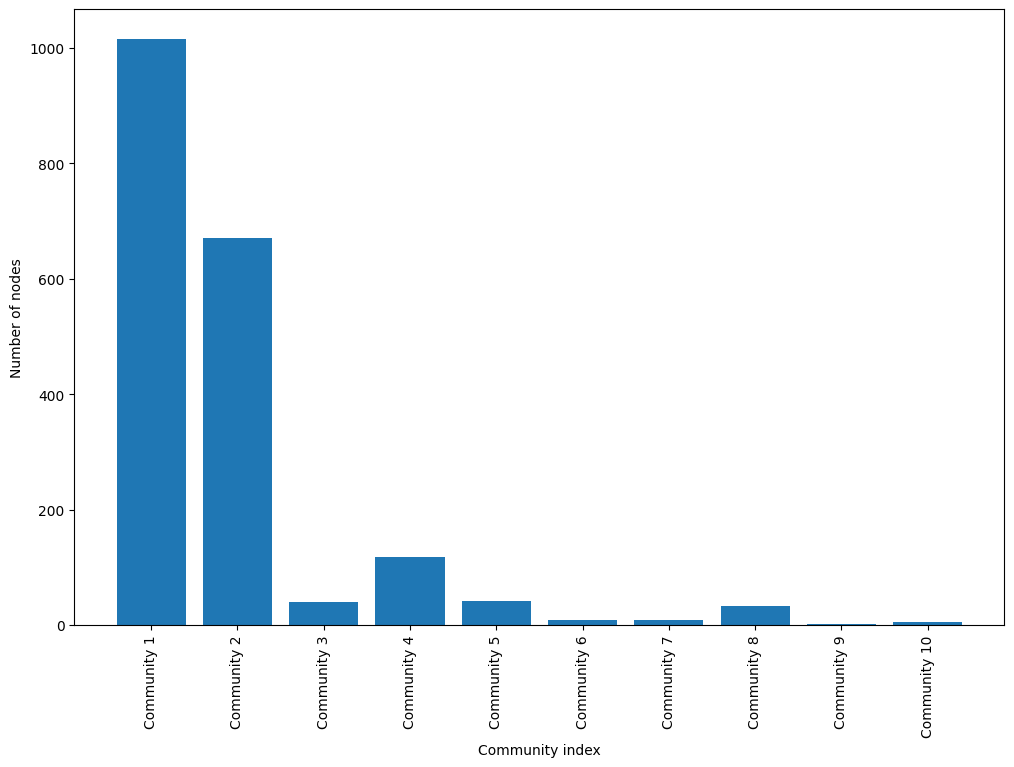

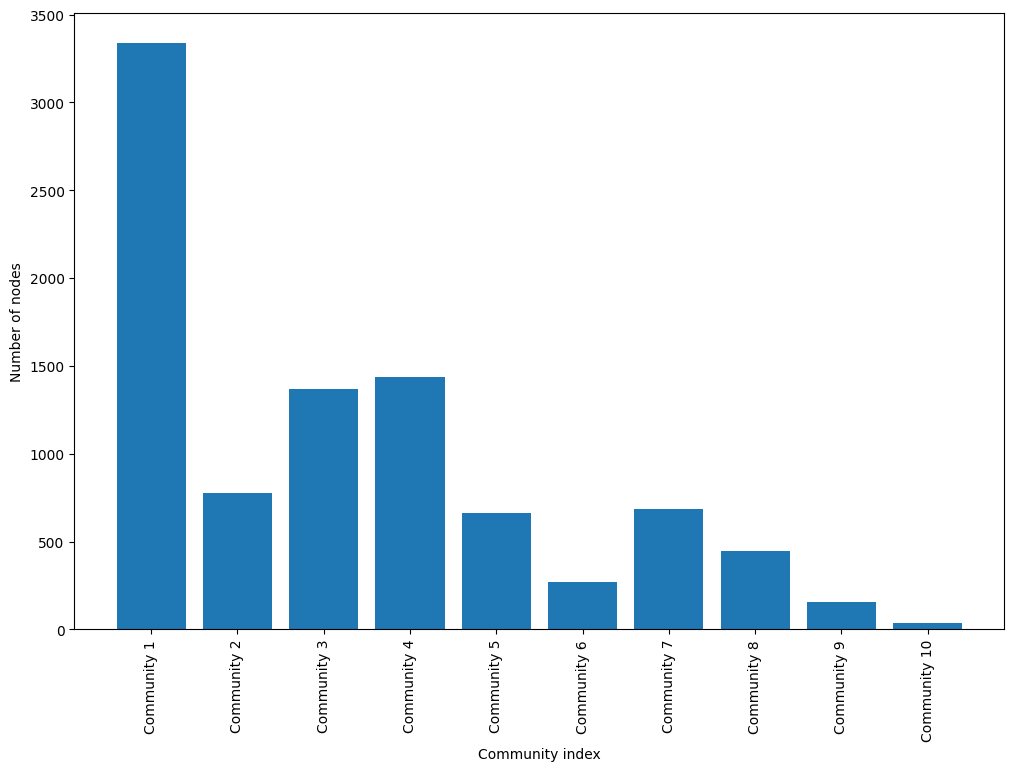

In [26]:
plt.figure(figsize=(12, 8))
plt.bar(range(len(EOA_gov_array)), EOA_gov_array)#, color='orange')
plt.xlabel('Community index')
plt.ylabel('Number of nodes')
# plt.title('Percentage of governance nodes per community vs total governance percentage')
# plt.legend()
plt.xticks(range(len(top_communities)), [f'Community {i+1}' for i in range(len(top_communities))], rotation=90)
plt.show()

plt.figure(figsize=(12, 8))
plt.bar(range(len(infra_array)), infra_array)#, color='green')
plt.xlabel('Community index')
plt.ylabel('Number of nodes')
# plt.title('Percentage of economic nodes per community vs total economic percentage')
# plt.legend()
plt.xticks(range(len(top_communities)), [f'Community {i+1}' for i in range(len(top_communities))], rotation=90)
plt.show()

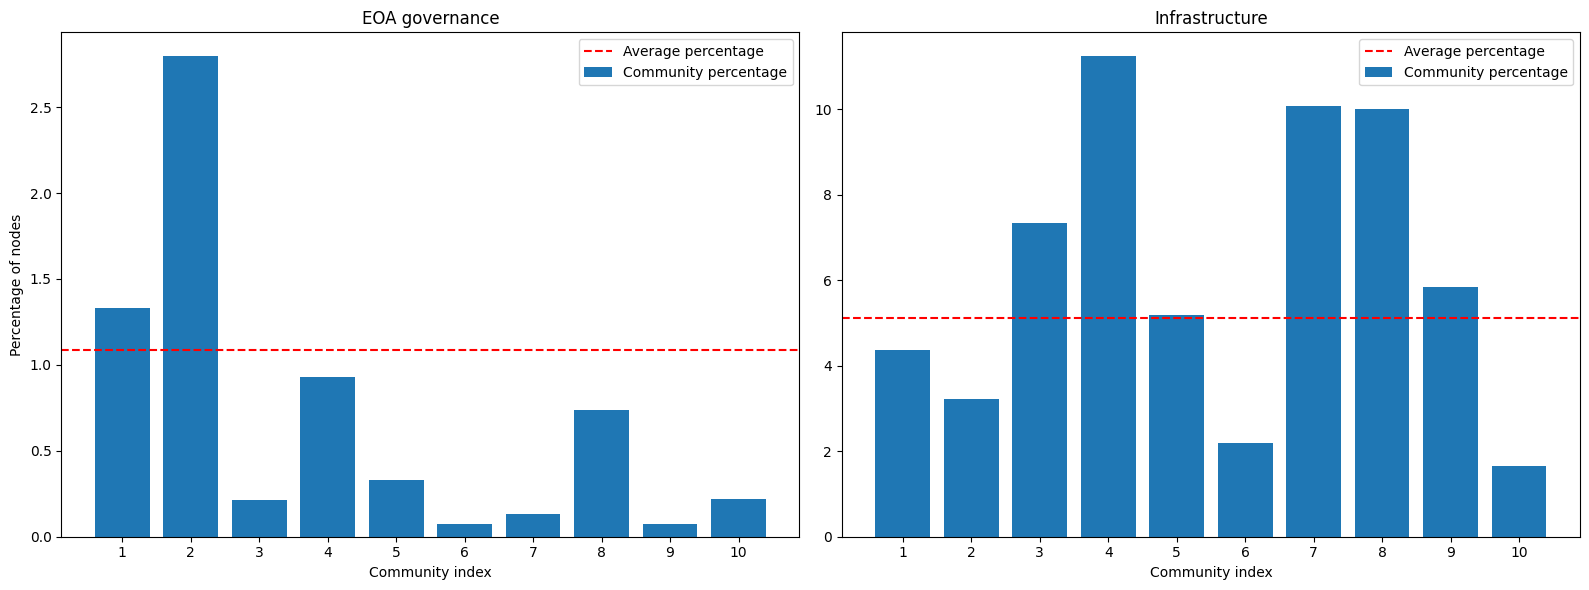

In [31]:
EOA_gov_array = np.array(community_distribution_2['EOA gov'])
CEX_array = np.array(community_distribution_2['CEX'])
CA_array = np.array(community_distribution_2['CA'])

total_EOA_gov_percentage = (len(EOA & all_proposers_voters_delegators_in_G_aave) / len(G_aave_nodes)) * 100
total_CEX_percentage = (len(CEX & G_aave_nodes) / len(G_aave_nodes)) * 100
total_CA_percentage = (len(CA & G_aave_nodes) / len(G_aave_nodes)) * 100

community_EOA_gov_percentages = []
community_CEX_percentages = []
community_CA_percentages = []

for i in range(len(EOA_gov_array)):
    EOA_gov_percentage = (EOA_gov_array[i] / len(communities_with_ids[i])) * 100
    community_EOA_gov_percentages.append(EOA_gov_percentage)
    
    CEX_percentage = (CEX_array[i] / len(communities_with_ids[i])) * 100
    community_CEX_percentages.append(CEX_percentage)
    
    CA_percentage = (CA_array[i] / len(communities_with_ids[i])) * 100
    community_CA_percentages.append(CA_percentage)

fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharex=True)
# fig, axs = plt.subplots(1, 3, figsize=(20, 6), sharex=True)

axs[0].bar(range(len(top_communities)), community_EOA_gov_percentages, label='Community percentage')
axs[0].axhline(y=total_EOA_gov_percentage, color='r', linestyle='--', label='Average percentage')
axs[0].set_xlabel('Community index')
axs[0].set_ylabel('Percentage of nodes')
axs[0].set_title('EOA governance')
axs[0].legend()
axs[0].set_xticks(range(len(top_communities)))
axs[0].set_xticklabels([f'{i+1}' for i in range(len(top_communities))])
# axs[0].set_xticklabels([f'Community {i+1}' for i in range(len(top_communities))], rotation=90)

CEX_CA_percentages = [community_CA_percentages[i] + community_CEX_percentages[i] for i in range(len(community_CEX_percentages))]
axs[1].bar(range(len(top_communities)), CEX_CA_percentages, label='Community percentage')
axs[1].axhline(y=total_CEX_percentage + total_CA_percentage, color='r', linestyle='--', label='Average percentage')
axs[1].set_xlabel('Community index')
axs[1].set_title('Infrastructure')
axs[1].legend()
axs[1].set_xticks(range(len(top_communities)))
axs[0].set_xticklabels([f'{i+1}' for i in range(len(top_communities))])
# axs[1].set_xticklabels([f'Community {i+1}' for i in range(len(top_communities))], rotation=90)

# axs[1].bar(range(len(top_communities)), community_CEX_percentages, label='Community CEX percentage')
# axs[1].axhline(y=total_CEX_percentage, color='r', linestyle='--', label='Total CEX percentage')
# axs[1].set_xlabel('Community index')
# axs[1].set_title('CEX')
# axs[1].legend()
# axs[1].set_xticks(range(len(top_communities)))
# axs[1].set_xticklabels([f'Community {i+1}' for i in range(len(top_communities))], rotation=90)

# axs[2].bar(range(len(top_communities)), community_CA_percentages, label='Community CA percentage')
# axs[2].axhline(y=total_CA_percentage, color='r', linestyle='--', label='Total CA percentage')
# axs[2].set_xlabel('Community index')
# axs[2].set_title('CA')
# axs[2].legend()
# axs[2].set_xticklabels([f'Community {i+1}' for i in range(len(top_communities))], rotation=90)

plt.tight_layout()
plt.show()

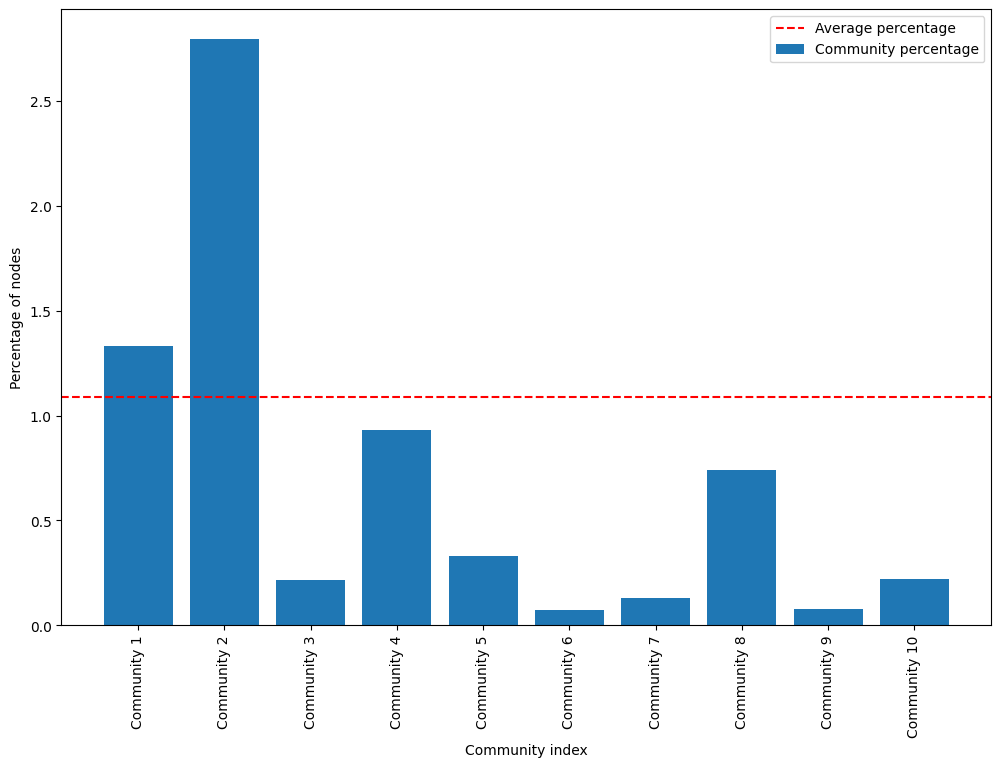

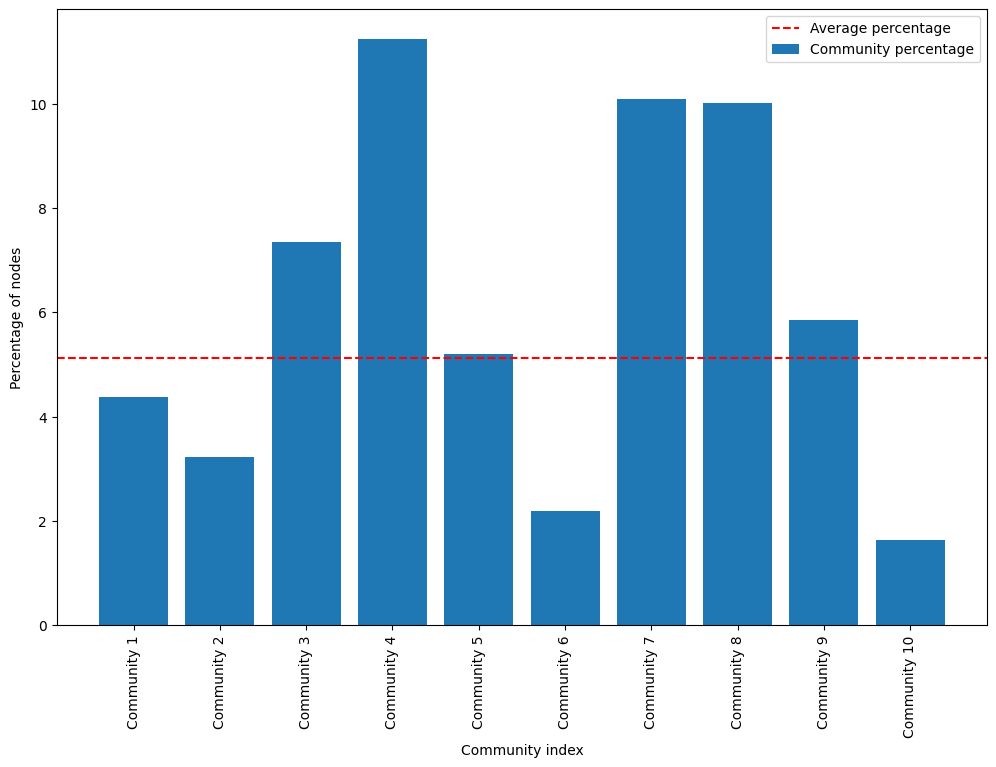

In [32]:
plt.figure(figsize=(12, 8))
plt.bar(range(len(top_communities)), community_EOA_gov_percentages, label='Community percentage')
plt.axhline(y=total_EOA_gov_percentage, color='r', linestyle='--', label='Average percentage')
plt.xlabel('Community index')
plt.ylabel('Percentage of nodes')
# plt.title('Percentage of governance nodes per community vs total governance percentage')
plt.legend()
plt.xticks(range(len(top_communities)), [f'Community {i+1}' for i in range(len(top_communities))], rotation=90)
plt.show()

plt.figure(figsize=(12, 8))
plt.bar(range(len(top_communities)), CEX_CA_percentages, label='Community percentage')
plt.axhline(y=total_CEX_percentage + total_CA_percentage, color='r', linestyle='--', label='Average percentage')
plt.xlabel('Community index')
plt.ylabel('Percentage of nodes')
# plt.title('Percentage of economic nodes per community vs total economic percentage')
plt.legend()
plt.xticks(range(len(top_communities)), [f'Community {i+1}' for i in range(len(top_communities))], rotation=90)
plt.show()

#### Feature averages per community

In [20]:
def plot_per_community(mapping):
    community_averages = {feature_name: [] for feature_name, _ in mapping}
    community_distributions = {feature_name: [] for feature_name, _ in mapping}

    for community in top_communities:
        community_node_ids = {G_aave_count_igraph_largest_wcc.vs[idx]["name"] for idx in community}

        for feature_name, feature_mapping in mapping:
            feature_values = [feature_mapping[node_id] for node_id in community_node_ids if node_id in feature_mapping]
            average_value = sum(feature_values) / len(feature_values) if feature_values else 0
            
            community_averages[feature_name].append(average_value)
            community_distributions[feature_name].append(feature_values)
    
    num_features = len(mapping)
    cols = 3
    rows = (num_features + cols - 1) // cols
    
    fig, axs = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    axs = axs.flatten()
    
    for i, (feature_name, averages) in enumerate(community_averages.items()):
        axs[i].plot(range(len(top_communities)), averages, marker='o')
        axs[i].set_title(feature_name)
        axs[i].set_xlabel("Community index")
        axs[i].set_ylabel("Average feature score")
        axs[i].set_xticks(range(len(top_communities)))
        axs[i].set_xticklabels([f"{i+1}" for i in range(len(top_communities))])
    
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')
    
    plt.tight_layout()
    plt.show()

In [21]:
def plot_per_community_2(mapping):
    feature_stats = {}
    for feature_name, feature_mapping in mapping:
        values = list(feature_mapping.values())
        mean = np.mean(values)
        std = np.std(values)
        feature_stats[feature_name] = (mean, std)

    community_averages = {feature_name: [] for feature_name, _ in mapping}
    community_distributions = {feature_name: [] for feature_name, _ in mapping}

    for community in top_communities:
        community_node_ids = {G_aave_count_igraph_largest_wcc.vs[idx]["name"] for idx in community}

        for feature_name, feature_mapping in mapping:
            feature_values = [feature_mapping[node_id] for node_id in community_node_ids if node_id in feature_mapping]

            if feature_values:
                avg_val = sum(feature_values) / len(feature_values)
                mean, std = feature_stats[feature_name]
                z_score = (avg_val - mean) / std if std > 0 else 0
            else:
                z_score = 0

            community_averages[feature_name].append(z_score)
            community_distributions[feature_name].append(feature_values)

    num_features = len(mapping)
    cols = 3
    rows = (num_features + cols - 1) // cols

    fig, axs = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    axs = axs.flatten()

    for i, (feature_name, averages) in enumerate(community_averages.items()):
        axs[i].plot(range(len(top_communities)), averages, marker='o')
        axs[i].set_title(f'{feature_name} (z-score)')
        axs[i].set_xlabel('Community index')
        axs[i].set_ylabel('Z-score')
        axs[i].set_xticks(range(len(top_communities)))
        axs[i].set_xticklabels([f"{i+1}" for i in range(len(top_communities))])

    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

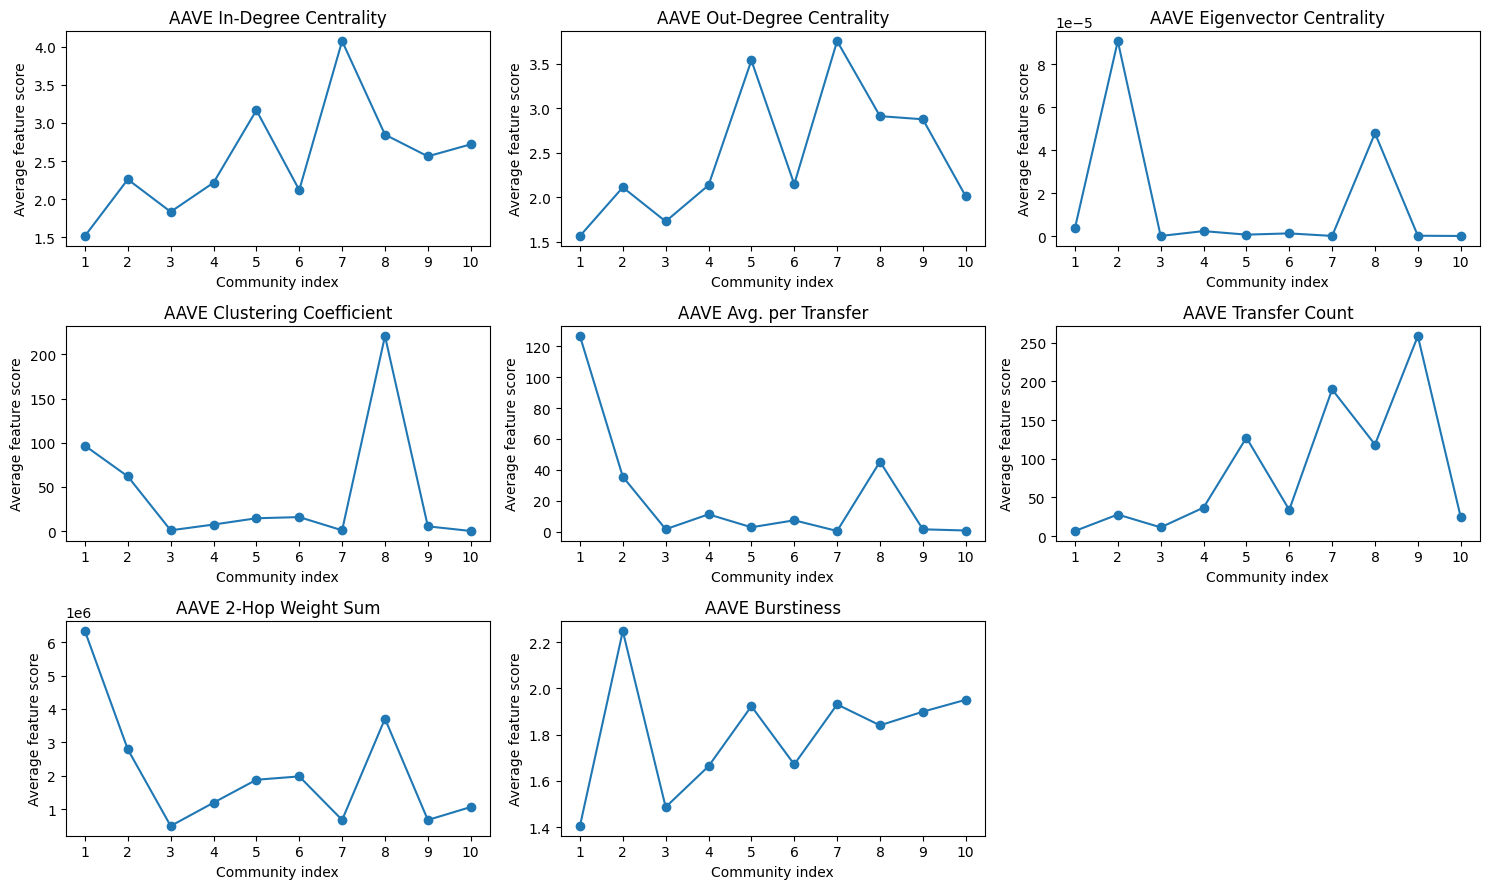

In [46]:
plot_per_community(AAVE_mappings)

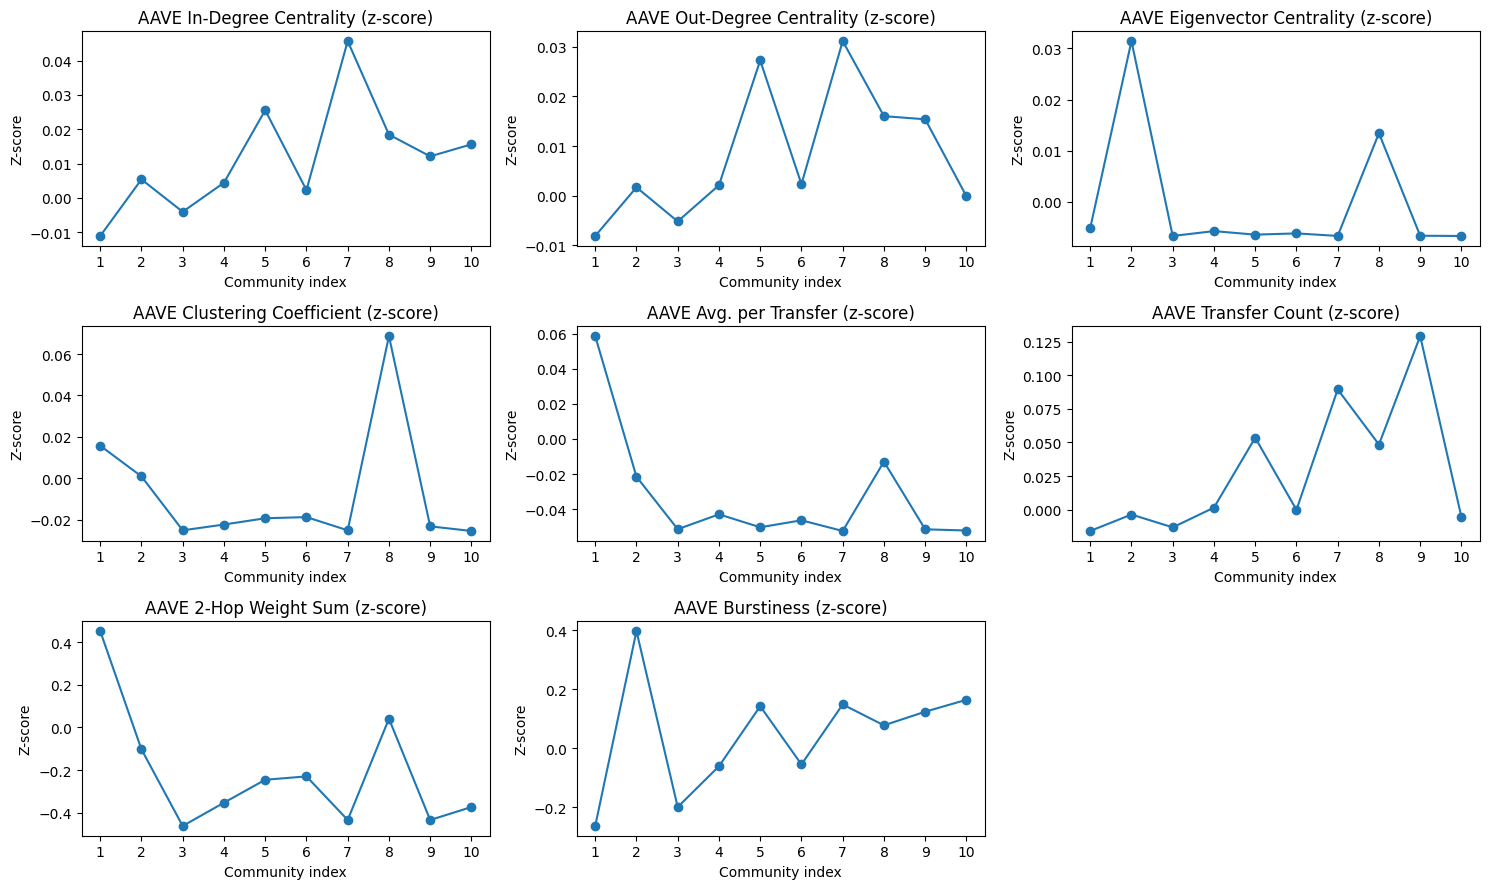

In [47]:
plot_per_community_2(AAVE_mappings)

In [ ]:
plot_per_community(aWETH_mappings)

In [ ]:
plot_per_community_2(aWETH_mappings)

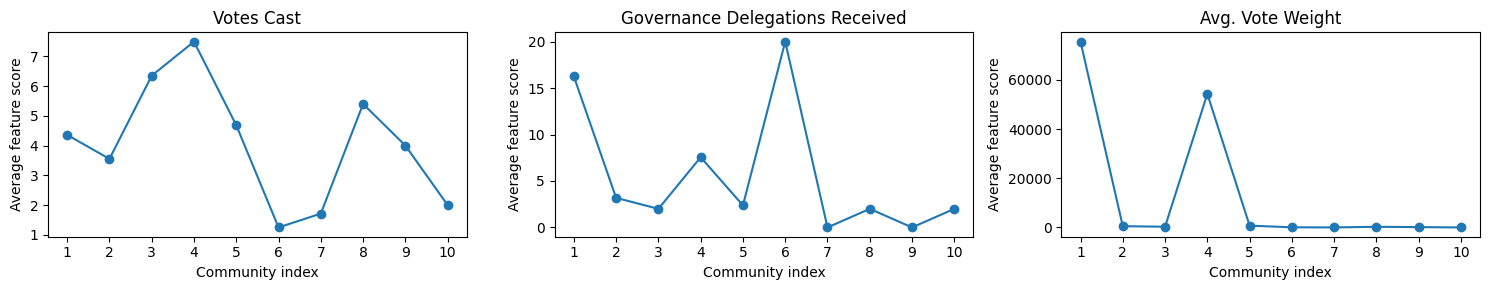

<Figure size 640x480 with 0 Axes>

In [22]:
plot_per_community(gov_mappings)

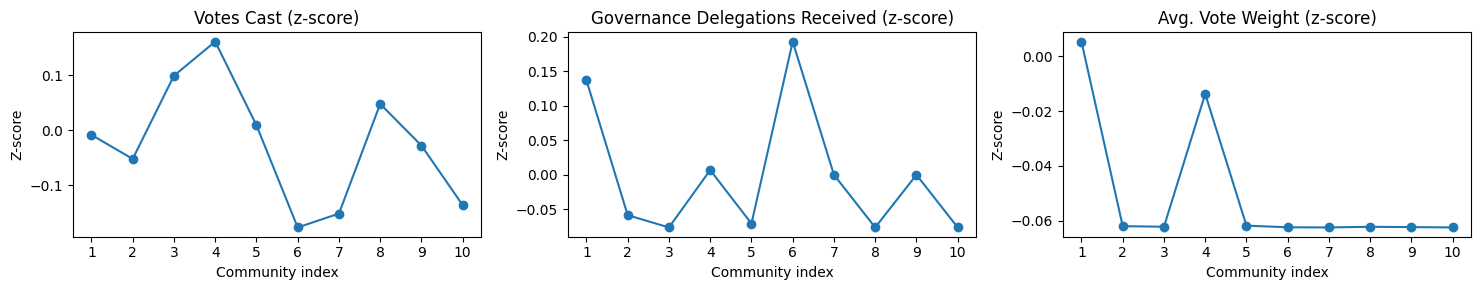

In [23]:
plot_per_community_2(gov_mappings)

#### SI influence comparison

In [ ]:
with open('data/SI/aave/SI_5_extracted_seeds_avg_infected.pkl', 'rb') as f:
    SI_5_extracted = pickle.load(f)
    
with open('data/SI/aave/SI_2_extracted_seeds_avg_infected.pkl', 'rb') as f:
    SI_2_extracted = pickle.load(f)

with open('data/SI/aave/SI_1_extracted_seeds_avg_infected.pkl', 'rb') as f:
    SI_1_extracted = pickle.load(f)
    
with open('data/SI/aave/SI_05_extracted_seeds_avg_infected.pkl', 'rb') as f:
    SI_05_extracted = pickle.load(f)
    
with open('data/SI/aave/SI_01_extracted_seeds_avg_infected.pkl', 'rb') as f:
    SI_01_extracted = pickle.load(f)
    
with open('data/SI/aave/SI_001_extracted_seeds_avg_infected.pkl', 'rb') as f:
    SI_001_extracted = pickle.load(f)

In [4]:
def plot_influence_multiple_runs(influence_data_list, beta_labels):
    num_runs = len(influence_data_list)
    num_communities = len(top_communities)

    community_scores = [defaultdict(list) for _ in range(num_runs)]

    for run_idx, influence_data in enumerate(influence_data_list):
        influence_scores = {entry['seed']: entry['avg_infected'] for entry in influence_data if entry['seed'] in all_proposers_voters_delegators_in_G_aave}
        for comm_id, community in enumerate(top_communities):
            for node_idx in community:
                node_id = G_aave_count_igraph_largest_wcc.vs[node_idx]['name']
                if node_id in influence_scores:
                    community_scores[run_idx][comm_id].append(influence_scores[node_id])

    fig, axs = plt.subplots(1, num_runs, figsize=(5 * num_runs, 3))
    if num_runs == 1:
        axs = [axs]
    for i in range(num_runs):
        avg_infs = [
            np.mean(community_scores[i][cid]) if community_scores[i][cid] else 0
            for cid in range(num_communities)
        ]
        axs[i].plot(range(num_communities), avg_infs, marker='o', label=f"β={beta_labels[i]}")
        axs[i].set_title(f"β={beta_labels[i]}")
        axs[i].set_xlabel("Community index")
        axs[i].set_ylabel("Average infected nodes")
        axs[i].set_xticks(range(num_communities))
        axs[i].set_xticklabels([f"{i+1}" for i in range(num_communities)])
        # axs[i].grid(True)
        # axs[i].legend()
    plt.tight_layout()
    plt.show()

    fig, axs = plt.subplots(1, num_runs, figsize=(5 * num_runs, 3))
    if num_runs == 1:
        axs = [axs]

    for i in range(num_runs):
        data = [community_scores[i][cid] for cid in range(num_communities)]
        axs[i].boxplot(data, positions=range(num_communities))
        axs[i].set_title(f"β={beta_labels[i]}")
        axs[i].set_xlabel("Community index")
        axs[i].set_ylabel("Average infected nodes")
        axs[i].set_xticks(range(num_communities))
        axs[i].set_xticklabels([f"{i+1}" for i in range(num_communities)])

    plt.tight_layout()
    plt.show()

    # fig, axs = plt.subplots(1, num_runs, figsize=(6 * num_runs, 5))
    # if num_runs == 1:
    #     axs = [axs]

    # for i in range(num_runs):
    #     data = [community_scores[i][cid] for cid in range(num_communities)]
    #     axs[i].violinplot(data, positions=range(num_communities), showmedians=True)
    #     axs[i].set_title(f"Violin plot (β={beta_labels[i]})")
    #     axs[i].set_xlabel("Community")
    #     axs[i].set_xticks(range(num_communities))
    #     axs[i].set_xticklabels([f"{cid}" for cid in range(num_communities)])
    #     axs[i].set_ylabel("Average infected nodes")

    # plt.tight_layout()
    # plt.show()

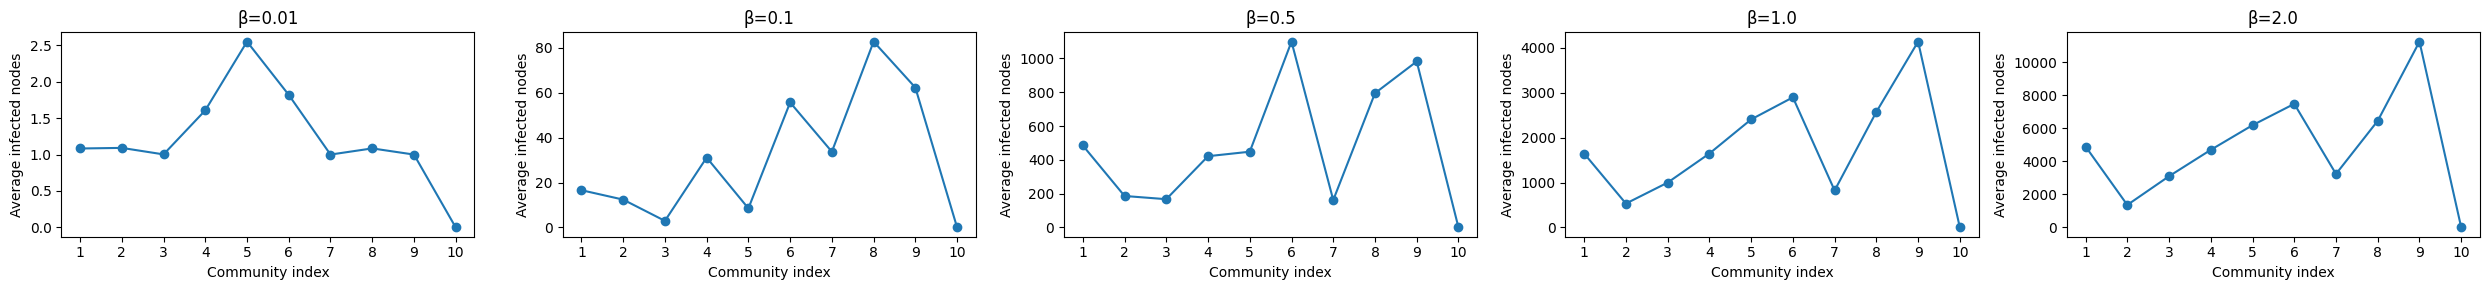

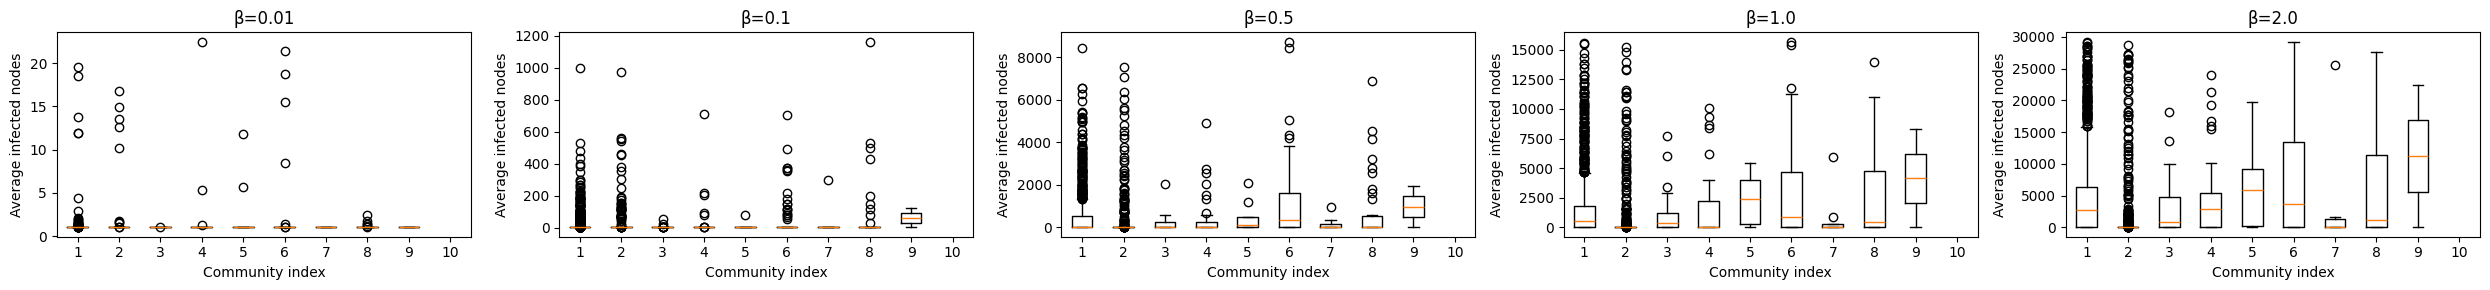

In [45]:
influence_dicts = [SI_001_extracted, SI_01_extracted, SI_05_extracted, SI_1_extracted, SI_2_extracted]#, SI_5_extracted]
labels = ['0.01', '0.1', '0.5', '1.0', '2.0']#, '5.0']

plot_influence_multiple_runs(influence_dicts, labels)

## Proposal analysis

In [ ]:
for_against_ratio = {
    proposal_id: for_votes[proposal_id] / against_votes[proposal_id] if against_votes[proposal_id] != 0 else None
    for proposal_id in for_votes
}

for i in for_against_ratio:
    if for_against_ratio[i] is not None and for_against_ratio[i] < 100:
        print(i, for_against_ratio[i])

In [ ]:
# Filter proposals where the number of votes against was greater than 100000
proposals_against_gt_100k = [
    proposal for proposal in aave_v2_proposals if float(proposal['currentNoVote']) > 100000
] + [
    proposal for proposal in aave_v3_proposals if proposal['votes'] and float(proposal['votes']['againstVotes']) > 100000
]

print("Proposals with votes against greater than 100,000:")
for proposal in proposals_against_gt_100k:
    print(proposal)

# Filter proposals where the number of voters was greater than 300
# proposals_voters_gt_300 = [
#     proposal for proposal in aave_v2_proposals if proposal['totalCurrentVoters'] > 300
# ] + [
#     proposal for proposal in aave_v3_proposals if proposal['totalCurrentVoters'] > 300
# ]

# print("\nProposals with voters greater than 300:")
# for proposal in proposals_voters_gt_300:
#     print(proposal)

In [ ]:
for p in aave_v2_proposals:
    id = p['id']
    title = p['title']
    print(f'{id}: {title}')
    
for p in aave_v3_proposals:
    id = p['id']
    title = p['proposalMetadata']['title']
    print(f'{id}: {title}')

In [59]:
CATEGORIES = {
    "Treasury & Financial Management": [
        "treasury", "funding", "gho", "liquidity", 
        "safety module", "emissions", "finance update"
    ],
    "Governance Ops & Service Providers": [
        "emission manager", "governance", "tokenlogic", 
        "chaos labs", "gauntlet", "service provider", "proposal activation"
    ],
    "Risk & Parameter Updates": [
        "risk parameter", "reserve factor", "interest rate", "borrow cap", 
        "lt/ltv", "debt ceiling", "onboard", "offboard", "deprecate"
    ],
    "Protocol/Technical Upgrades": [
        "upgrade", "activation", "maintenance", "deprecation", 
        "periphery", "adapter", "implementation", "bug"
    ],
    "Security": [
        "security", "sentinel", "emergency admin", 
        "freeze", "bug bounty"
    ],
    "Misc/Experimental": [
        "orbit program", "event", "competition", 
        "strategy", "liquidity incentive", "embassy"
    ]
}

# CATEGORIES = {
#     "Treasury & Financial Management": [
#         "treasury", "funding", "gho", "liquidity", "allowance", 
#         "transfer", "financial", "payment", "revenue"
#     ],
#     "Governance & Service Providers": [
#         "governance", "emission manager", "provider", "tokenlogic", 
#         "gauntlet", "chaos labs", "aci", "delegate", "committee"
#     ],
#     "Risk & Parameter Updates": [
#         "risk parameter", "lt/ltv", "lt reduction", "debt ceiling",
#         "reserve factor", "interest rate", "borrow cap", 
#         "supply cap", "price feed", "curve amendment"
#     ],
#     "Protocol/Technical Upgrades": [
#         "upgrade", "activation", "implementation", "periphery", 
#         "adapter", "robot", "migration", "scroll", "maintenance", 
#         "freeze", "deprecation", "bug"
#     ],
#     "Security & Emergency": [
#         "security", "sentinel", "emergency", "bounty", "admin", "incident"
#     ],
#     "Miscellaneous / Ecosystem": [
#         "orbit", "event", "competition", "embassy", 
#         "strategy", "superfest", "program", "grant"
#     ]
# }

def categorize_proposal(title):
    title_lower = title.lower()
    matched = [cat for cat, keys in CATEGORIES.items() if any(k in title_lower for k in keys)]
    return matched if matched else [""]

In [ ]:
category_dicts = defaultdict(dict)

for proposal in aave_v2_proposals:
    id = proposal['id']
    title = proposal['title']
    # if categorize_proposal(title) == ['None']:
    #     print(id, categorize_proposal(proposal['description']))
    # print(f'{id}: {categorize_proposal(title)}')
    
    categories = categorize_proposal(title)
    
    if categories == [""]:
        continue
    
    cat = categories[0]
    category_dicts[cat][proposal['id']] = {
        "timestamp": proposal['timestamp'],
        "voters": proposal['totalCurrentVoters'],
        "state": proposal['state'],
        "for_votes": proposal['currentYesVote'],
        "against_votes": proposal['currentNoVote']
    }
    
# print('')
    
for proposal in aave_v3_proposals:
    id = proposal['id']
    title = proposal['proposalMetadata']['title']
    # if categorize_proposal(title) == ['None']:
    #     print(id, categorize_proposal(proposal['proposalMetadata']['rawContent']))
    # print(f'{id}: {categorize_proposal(title)}')
    
    categories = categorize_proposal(title)
    
    if categories == [""]:
        continue
    
    cat = categories[0]
    category_dicts[cat][proposal['id']] = {
        "timestamp": int(proposal['transactions']['created']['timestamp']),
        "voters": proposal['totalCurrentVoters'],
        "state": proposal['state'],
        "for_votes": proposal['votes']['forVotes'] if proposal['votes'] else 0,
        "against_votes": proposal['votes']['againstVotes'] if proposal['votes'] else 0
    }

In [67]:
governance_service_dict = category_dicts['Governance Ops & Service Providers']
treasury_dict = category_dicts['Treasury & Financial Management']

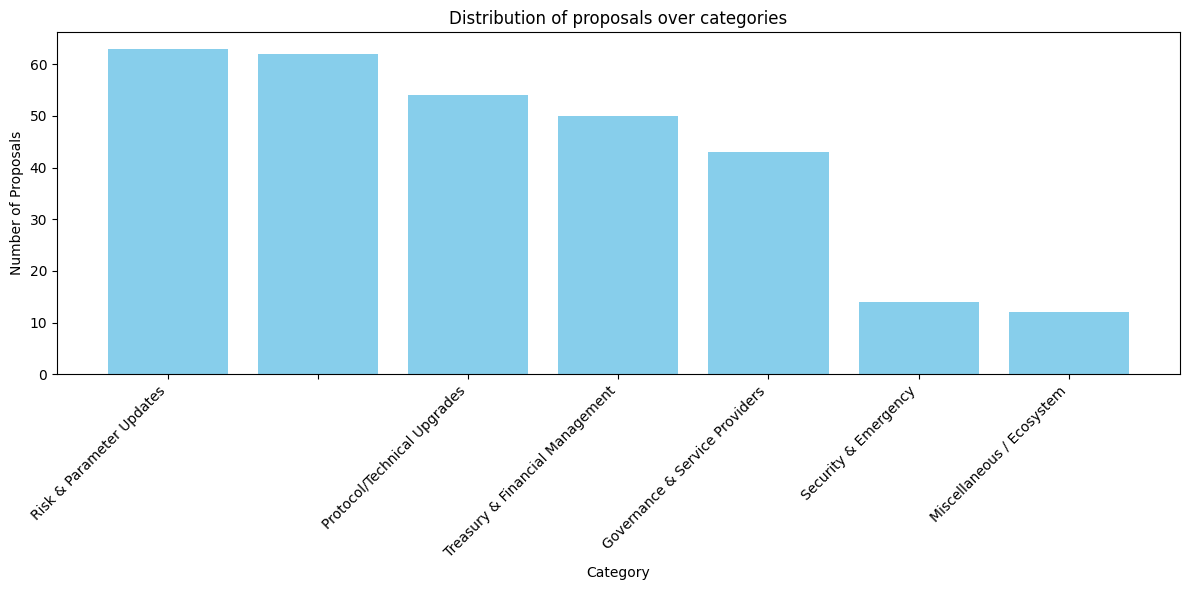

In [53]:
category_counts = Counter()
for proposal in aave_v2_proposals + aave_v3_proposals:
    title = proposal['title'] if 'title' in proposal else proposal['proposalMetadata']['title']
    categories = categorize_proposal(title)
    for category in categories:
        category_counts[category] += 1

categories, counts = zip(*sorted(category_counts.items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(12, 6))
plt.bar(categories, counts, color='skyblue')
plt.xlabel('Category')
plt.ylabel('Number of Proposals')
plt.title('Distribution of proposals over categories')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## SI

In [114]:
def normalize_weights(G):
    max_weight = max(data['weight'] for _, _, _, data in G.edges(keys=True, data=True))
    
    for _, _, _, data in G.edges(keys=True, data=True):
        data['norm_weight'] = data['weight'] / max_weight
    
    return G

def log_normalize_weights(G):
    max_weight = np.log1p(max(data['weight'] for _, _, _, data in G.edges(keys=True, data=True)))
    
    for _, _, _, data in G.edges(keys=True, data=True):
        data['norm_weight'] = np.log1p(data['weight']) / max_weight
    
    return G

### Simple SI model

In [115]:
G = copy.deepcopy(G_aave_complete)
# G_T = copy.deepcopy(G_aave_complete)

G = log_normalize_weights(G)
# G_T = normalize_weights(G_T)

In [110]:
def preprocess_out_edges(G, beta=1.0):
    out_edges = defaultdict(list)
    
    for u, v, k, d in G.edges(keys=True, data=True):
        out_edges[u].append((v, d['timestamp'], beta * d['norm_weight']))
    
    return out_edges

def simulate_SI(G, seed_node, beta=1.0, cached_edges=None):
    infected = {}
    infection_queue = []

    infected[seed_node] = 1696118400
    heapq.heappush(infection_queue, (1696118400, seed_node))

    while infection_queue:
        curr_time, node = heapq.heappop(infection_queue)
        
        if node not in cached_edges:
            continue
        
        for neighbor, ts, prob in cached_edges[node]:
        # for _, neighbor, _, data in G.out_edges(node, keys=True, data=True):
            if neighbor in infected:
                continue
            
            # ts = data['timestamp']
            # prob = beta * data['norm_weight']

            if ts >= curr_time:
                if np.random.rand() < prob:
                    infected[neighbor] = ts
                    heapq.heappush(infection_queue, (ts, neighbor))

    return infected

def run_multiple_iterations(G, num_iterations=100, beta=1.0):
    # all_nodes = list(G.nodes)
    all_nodes = list(all_proposers_voters_delegators_in_G_aave)
    infection_counts = defaultdict(list)
    infections_per_iteration = defaultdict(list)
    
    cached_edges = preprocess_out_edges(G, beta)

    for i in range(num_iterations):
        print(f"Iteration {i+1}/{num_iterations}")
        # for seed in tqdm(all_nodes, desc=f"SI iteration {i+1}"):
        for seed in all_nodes:
            infected = simulate_SI(G, seed, beta, cached_edges)
            infection_counts[seed].append(len(infected))
            infections_per_iteration[seed].append(infected)

    avg_results = [{
        'seed': node,
        'avg_infected': sum(counts) / len(counts),
        'infections_per_iteration': infections_per_iteration[node]
        # 'all_infected_counts': counts
    } for node, counts in infection_counts.items()]

    top_avg_influencers = sorted(avg_results, key=lambda x: x['avg_infected'], reverse=True)

    return top_avg_influencers

### Simulations

In [ ]:
SI_5 = run_multiple_iterations(G, num_iterations=10, beta=5.0)

with open('data/SI/aave/SI_5.pkl', 'wb') as file:
    pickle.dump(SI_5, file)

In [ ]:
SI_5_extracted = [{'seed': entry['seed'], 'avg_infected': entry['avg_infected']} for entry in SI_5]

with open('data/SI/aave/SI_5_extracted_seeds_avg_infected.pkl', 'wb') as file:
    pickle.dump(SI_5_extracted, file)

### Analysis

In [ ]:
SI_001_1_outcome = joblib.load('data/SI/aave/SI_001_1.pkl')

In [ ]:
SI_001_1_extracted = [{'seed': entry['seed'], 'avg_infected': entry['avg_infected']} for entry in SI_001_1_outcome]

In [ ]:
BIN_SIZE = timedelta(days=1)

def plot_infections(infections):
    binned_iterations = []

    for iteration in infections['infections_per_iteration']:
        bin_counts = defaultdict(int)
        for ts in iteration.values():
            t = datetime.fromtimestamp(ts)
            bin_time = datetime(t.year, t.month, t.day)
            bin_counts[bin_time] += 1
        binned_iterations.append(bin_counts)

    all_bins = sorted(set().union(*[d.keys() for d in binned_iterations]))

    counts_matrix = []
    for bins in binned_iterations:
        counts = [bins.get(t, 0) for t in all_bins]
        counts_matrix.append(counts)

    counts_matrix = np.array(counts_matrix)

    mean_counts = counts_matrix.mean(axis=0)
    std_counts = counts_matrix.std(axis=0)
    cumulative_mean = np.cumsum(mean_counts)

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(all_bins, mean_counts, label='Mean infection rate')
    plt.fill_between(all_bins, mean_counts - std_counts, mean_counts + std_counts, alpha=0.2, label='Standard deviation')
    # plt.title('Average infection rate over time')
    plt.xlabel('Date')
    plt.ylabel('Infections')
    # plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(all_bins, cumulative_mean, label='Mean cumulative')
    # plt.title('Average cumulative infections over time')
    plt.xlabel('Date')
    plt.ylabel('Cumulative infections')
    # plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
for i in SI_001_1_outcome[:10]:
    plot_infections(i)

In [ ]:
BIN_SIZE = timedelta(days=1)

def plot_infections_average(infections_list):
    all_binned_counts = []

    for infections in infections_list:
        for iteration in infections['infections_per_iteration']:
            bin_counts = defaultdict(int)
            for ts in iteration.values():
                t = datetime.fromtimestamp(ts)
                bin_time = datetime(t.year, t.month, t.day)
                bin_counts[bin_time] += 1
            all_binned_counts.append(bin_counts)

    all_bins = sorted(set().union(*[d.keys() for d in all_binned_counts]))

    counts_matrix = []
    for bin_counts in all_binned_counts:
        counts = [bin_counts.get(t, 0) for t in all_bins]
        counts_matrix.append(counts)

    counts_matrix = np.array(counts_matrix)
    mean_counts = counts_matrix.mean(axis=0)
    std_counts = counts_matrix.std(axis=0)
    cumulative_mean = np.cumsum(mean_counts)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(all_bins, mean_counts, label='Mean infection rate')
    plt.fill_between(all_bins, mean_counts - std_counts, mean_counts + std_counts, alpha=0.2, label='Standard deviation')
    # plt.title('Average infection rate over time')
    plt.xlabel('Date')
    plt.ylabel('Infections')
    # plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(all_bins, cumulative_mean, label='Mean cumulative')
    # plt.title('Average cumulative infections over time')
    plt.xlabel('Date')
    plt.ylabel('Cumulative infections')
    # plt.legend()

    plt.tight_layout()
    plt.show()

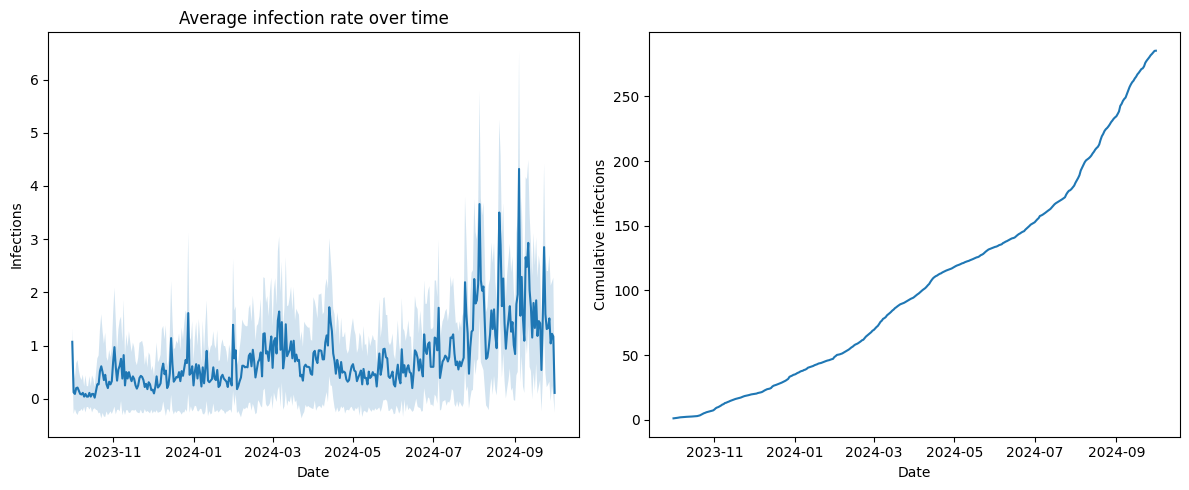

In [ ]:
plot_infections_average(SI_001_1_outcome[:10])

In [ ]:
SI_001_outcome = joblib.load('data/SI/aave/SI_001_extracted_seeds_avg_infected.pkl')
SI_01_outcome = joblib.load('data/SI/aave/SI_01_extracted_seeds_avg_infected.pkl')
SI_05_outcome = joblib.load('data/SI/aave/SI_05_extracted_seeds_avg_infected.pkl')
SI_1_outcome = joblib.load('data/SI/aave/SI_1_extracted_seeds_avg_infected.pkl')
SI_2_outcome = joblib.load('data/SI/aave/SI_2_extracted_seeds_avg_infected.pkl')
SI_5_outcome = joblib.load('data/SI/aave/SI_5_extracted_seeds_avg_infected.pkl')

In [ ]:
avg_infected_001 = [entry['avg_infected'] for entry in SI_001_outcome]
avg_infected_01 = [entry['avg_infected'] for entry in SI_01_outcome]
avg_infected_05 = [entry['avg_infected'] for entry in SI_05_outcome]
avg_infected_1 = [entry['avg_infected'] for entry in SI_1_outcome]

# avg_infected_001_T = [entry['avg_infected'] for entry in SI_T_001_outcome]
# avg_infected_01_T = [entry['avg_infected'] for entry in SI_T_01_outcome]
# avg_infected_05_T = [entry['avg_infected'] for entry in SI_T_05_outcome]
# avg_infected_1_T = [entry['avg_infected'] for entry in SI_T_1_outcome]

In [121]:
influence_scores = {
    'β=0.01': {seed['seed']: seed['avg_infected'] for seed in SI_001_outcome if seed['seed'] in all_proposers_voters_delegators_in_G_aave},
    'β=0.1': {seed['seed']: seed['avg_infected'] for seed in SI_01_outcome if seed['seed'] in all_proposers_voters_delegators_in_G_aave},
    'β=0.5': {seed['seed']: seed['avg_infected'] for seed in SI_05_outcome if seed['seed'] in all_proposers_voters_delegators_in_G_aave},
    'β=1.0': {seed['seed']: seed['avg_infected'] for seed in SI_1_outcome if seed['seed'] in all_proposers_voters_delegators_in_G_aave},
    'β=2.0': {seed['seed']: seed['avg_infected'] for seed in SI_2_outcome if seed['seed'] in all_proposers_voters_delegators_in_G_aave},
    # '5.0': {seed['seed']: seed['avg_infected'] for seed in SI_5_outcome}
}

influence_df = pd.DataFrame(influence_scores)

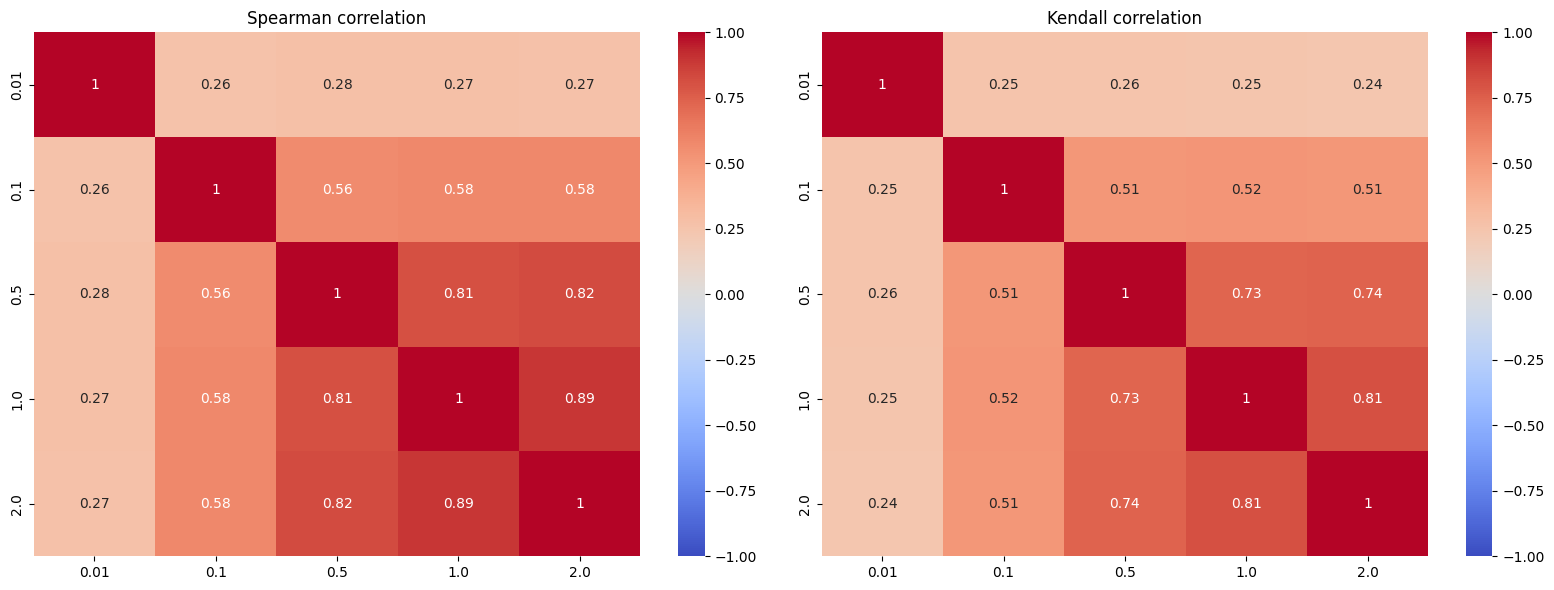

In [118]:
spearman_corr = influence_df.corr(method='spearman')
kendall_corr = influence_df.corr(method='kendall')
# pearson_corr = influence_df.corr(method='pearson')

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(spearman_corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, ax=axs[0])
axs[0].set_title("Spearman correlation")

sns.heatmap(kendall_corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, ax=axs[1])
axs[1].set_title("Kendall correlation")

plt.tight_layout()
plt.show()

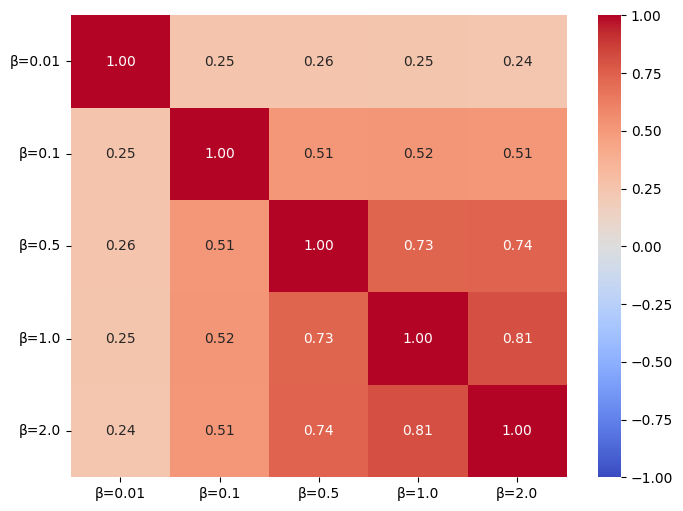

In [123]:
# spearman_corr = influence_df.corr(method='spearman')
kendall_corr = influence_df.corr(method='kendall')
# pearson_corr = influence_df.corr(method='pearson')

# plt.figure(figsize=(8, 6))
# sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', cbar=True, fmt='.2f', vmin=-1, vmax=1)
# plt.title("Spearman correlation")
# plt.show()

plt.figure(figsize=(8,6))
sns.heatmap(kendall_corr, annot=True, cmap="coolwarm", cbar=True, fmt='.2f', vmin=-1, vmax=1)
# plt.title("Kendall correlation")
plt.yticks(rotation=0)
plt.show()

In [111]:
datasets = {
    '0.01': SI_001_outcome,
    '0.1': SI_01_outcome,
    '0.5': SI_05_outcome,
    '1.0': SI_1_outcome,
    '2.0': SI_2_outcome,
    '5.0': SI_5_outcome
}

In [112]:
def hist_comparison_per_beta(datasets):
    hist_data = {}
    
    for beta, dataset in datasets.items():
        temp = [i['avg_infected'] for i in dataset if i['seed'] in all_proposers_voters_delegators_in_G_aave]
        hist_data[beta] = temp
        
    fig, axs = plt.subplots(1, 6, figsize=(48, 6))
    axs = axs.flatten()

    for ax, (title, data) in zip(axs, hist_data.items()):
        ax.hist(data, bins=30, alpha=0.7, edgecolor='black', log=True)
        ax.set_title(title)
        ax.set_xlabel('Avg. infected nodes')
        ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

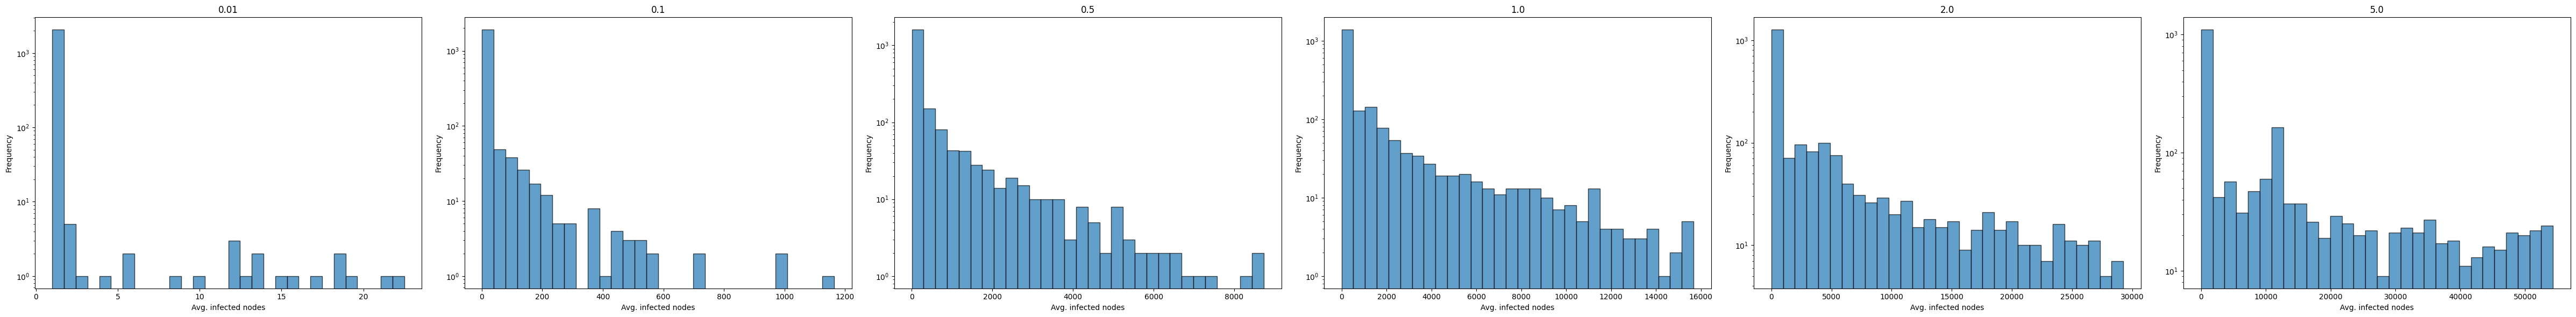

In [113]:
hist_comparison_per_beta(datasets)

In [ ]:
def hist_comparison_per_config(datasets):
    for beta, dataset in datasets.items():
        fig, axs = plt.subplots(1, 3, figsize=(24, 6))
        axs = axs.flatten()

        groups = {
            'EOA governance': [i['avg_infected'] for i in dataset if i['seed'] in EOA and i['seed'] in all_proposers_voters_delegators_in_G_aave and i['seed'] not in CEX],
            'EOA non-governance': [i['avg_infected'] for i in dataset if i['seed'] in EOA and i['seed'] not in all_proposers_voters_delegators_in_G_aave and i['seed'] not in CEX],
            # 'CA': [i['avg_infected'] for i in dataset if i['seed'] in CA],
            # 'CEX': [i['avg_infected'] for i in dataset if i['seed'] in CEX],
            'Infrastructural': [i['avg_infected'] for i in dataset if i['seed'] in CEX or i['seed'] in CA]
        }

        for ax, (title, data) in zip(axs, groups.items()):
            ax.hist(data, bins=30, alpha=0.7, edgecolor='black', log=True)
            ax.set_title(title)
            ax.set_xlabel('Avg. infected nodes')
            ax.set_ylabel('Frequency')

        fig.suptitle(f'β={beta}')#, fontsize=14)
        plt.tight_layout()
        plt.show()

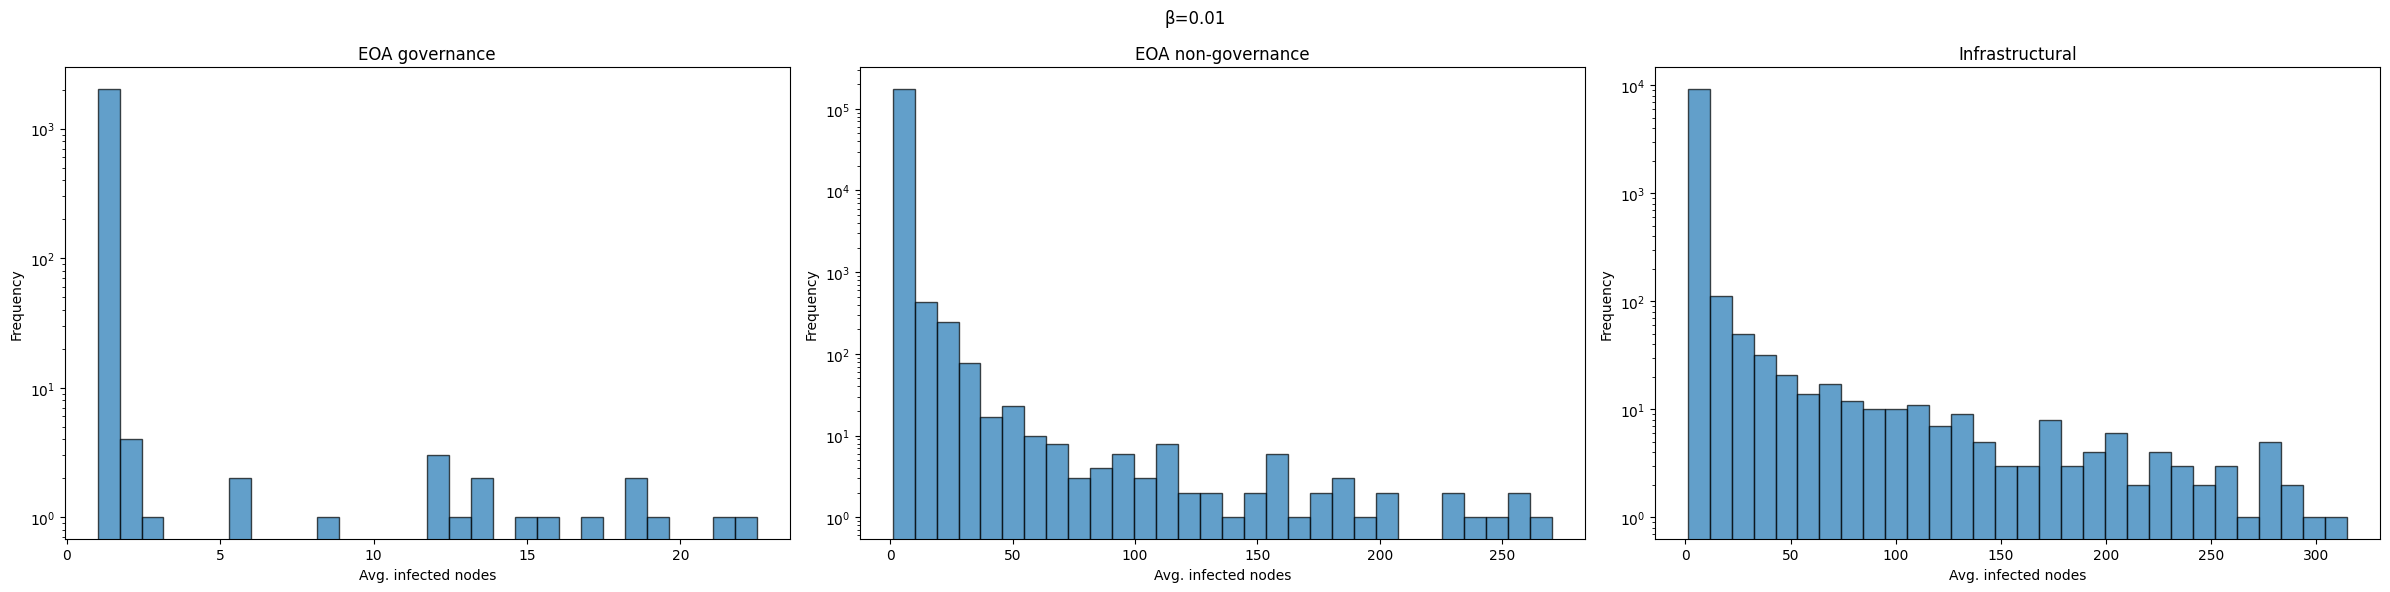

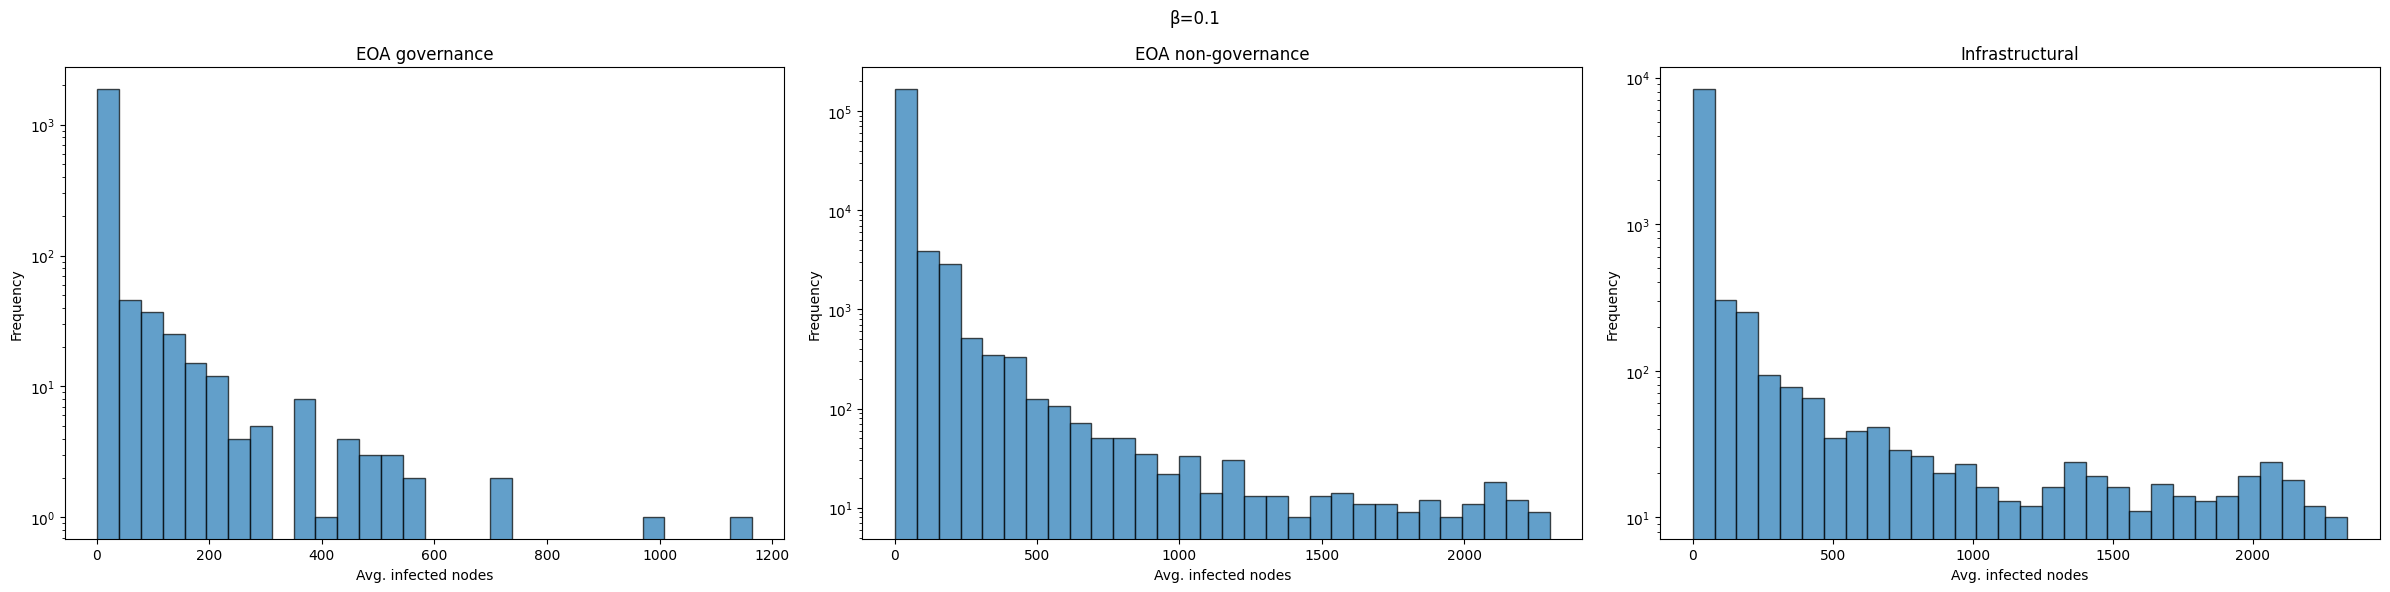

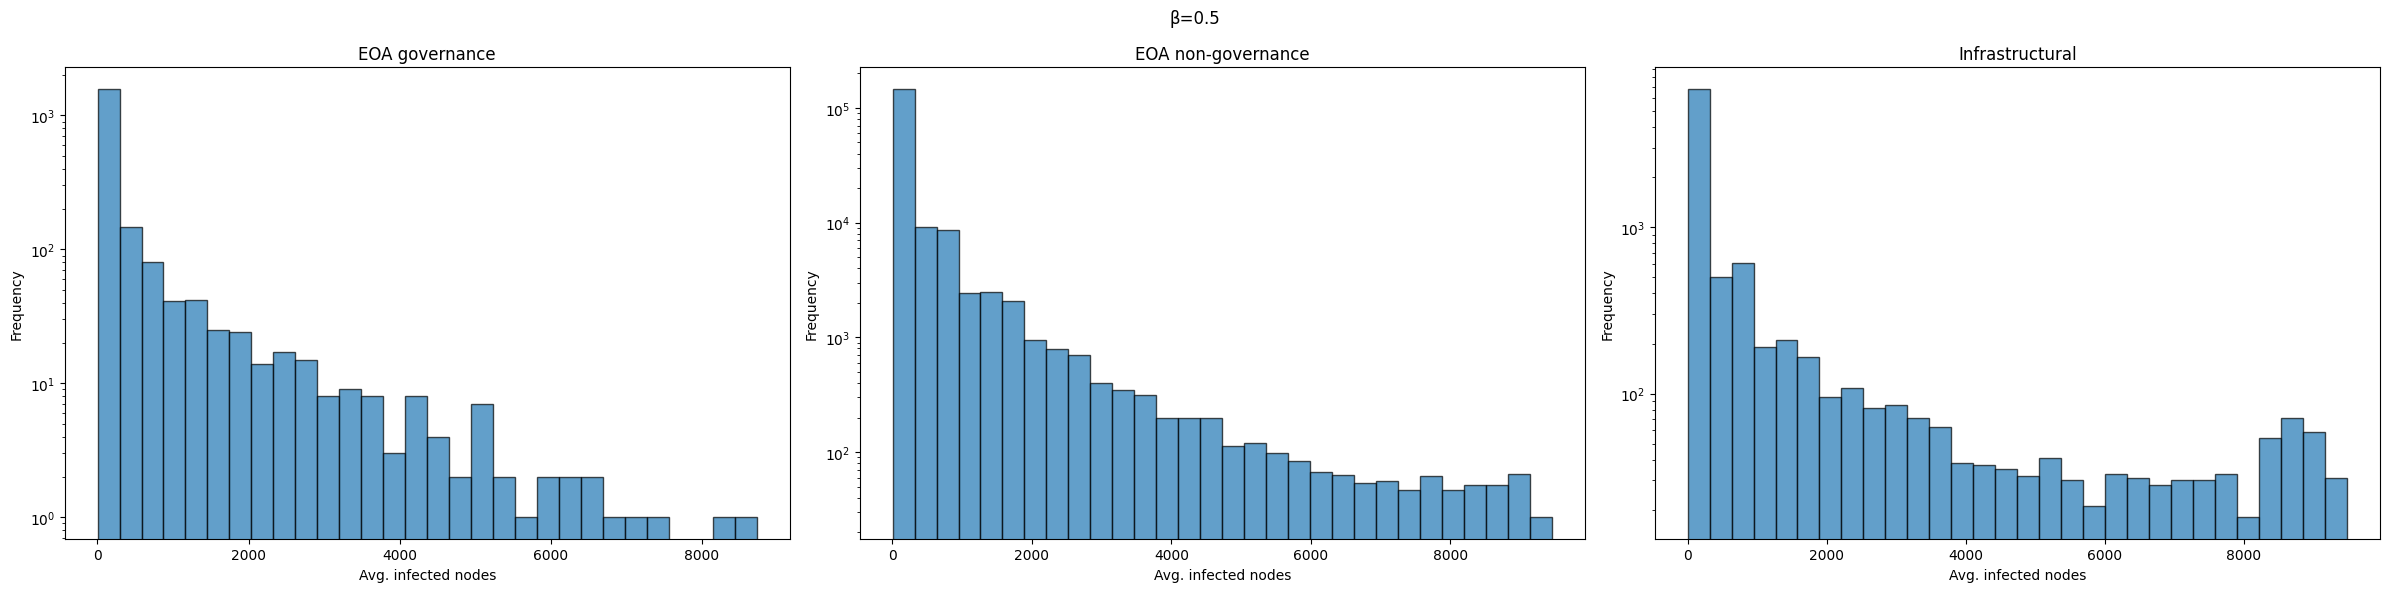

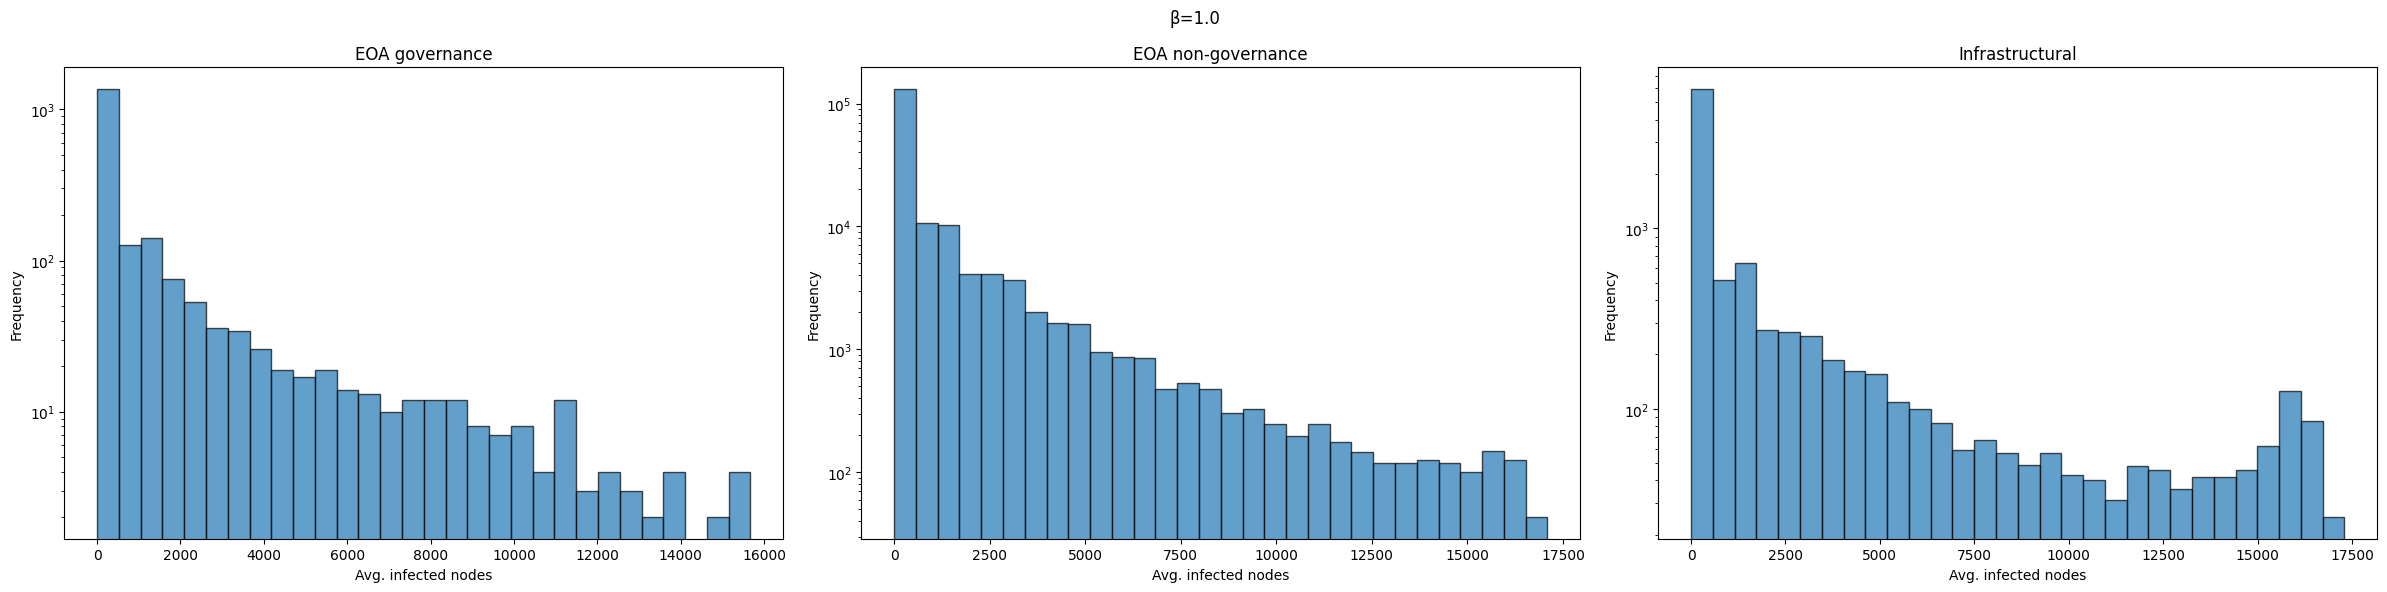

In [ ]:
hist_comparison_per_config(datasets)

### Multilayer SI model

In [ ]:
G_1 = copy.deepcopy(G_aave_complete)
G_2 = copy.deepcopy(G_aWETH_complete)

G_1 = normalize_weights(G_1)
G_2 = normalize_weights(G_2)

In [ ]:
G_1_log = copy.deepcopy(G_aave_complete)
G_2_log = copy.deepcopy(G_aWETH_complete)

G_1_log = log_normalize_weights(G_1_log)
G_2_log = log_normalize_weights(G_2_log)

In [ ]:
G_SI_combined = nx.MultiDiGraph()

for u, v, data in G_1.edges(data=True):
    G_SI_combined.add_edge((u, "gov"), (v, "gov"), **data)
    
for u, v, data in G_2.edges(data=True):
    G_SI_combined.add_edge((u, "fin"), (v, "fin"), **data)

users_in_both = set(G_1.nodes()).intersection(set(G_2.nodes()))

for user in users_in_both:
    G_SI_combined.add_edge((user, "gov"), (user, "fin"), layer_bridge=True)
    G_SI_combined.add_edge((user, "fin"), (user, "gov"), layer_bridge=True)

In [ ]:
G_SI_log = nx.MultiDiGraph()

for u, v, data in G_1_log.edges(data=True):
    G_SI_log.add_edge((u, "gov"), (v, "gov"), **data)
    
for u, v, data in G_2_log.edges(data=True):
    G_SI_log.add_edge((u, "fin"), (v, "fin"), **data)

users_in_both = set(G_1_log.nodes()).intersection(set(G_2_log.nodes()))

for user in users_in_both:
    G_SI_log.add_edge((user, "gov"), (user, "fin"), layer_bridge=True)
    G_SI_log.add_edge((user, "fin"), (user, "gov"), layer_bridge=True)

In [ ]:
def run_si_multilayer_simulation(G, seed_nodes, p_inter=0.2, weight_attr='norm_weight', timestamp_attr='timestamp', max_time=None):
    # infection_info = {node: {"time": 1696118400, "layer": node[1]} for node in seed_nodes}
    infection_info = {node: 1696118400 for node in seed_nodes}
    visited_interlayer = set()

    queue = []

    for u in seed_nodes:
        for _, v, data in G.out_edges(u, data=True):
            if data.get('layer_bridge'):
                continue
            
            t_edge = data[timestamp_attr]
            
            if max_time is None or t_edge <= max_time:
                heapq.heappush(queue, (t_edge, u, v, False))
                
        for _, v, data in G.out_edges(u, data=True):
            if data.get('layer_bridge') and v not in infection_info:
                    heapq.heappush(queue, (1696118400, u, v, True))

    while queue:
        t, u, v, is_inter = heapq.heappop(queue)
        
        if v in infection_info:
            continue

        if infection_info.get(u, float('inf')) > t:
            continue

        if is_inter:
            if v in visited_interlayer:
                continue

            if random.random() <= p_inter:
                infection_info[v] = t
                visited_interlayer.add(v)

                for _, w, data in G.out_edges(v, data=True):
                    if data.get('layer_bridge'):
                        continue
                    
                    t_edge = data[timestamp_attr]
                    
                    if max_time is not None and t_edge > max_time:
                        continue
                    
                    heapq.heappush(queue, (t_edge, v, w, False))

        else:
            # Use the edge with the earliest timestamp (choose the first if multiple)
            edge_data = G.get_edge_data(u, v)
            if not edge_data:
                continue

            p = edge_data[0].get(weight_attr, 0)
            if random.random() <= p:
                infection_info[v] = t

                # Immediately try inter-layer infection
                for _, cross_v, data in G.out_edges(v, data=True):
                    if data.get('layer_bridge') and cross_v not in infection_info:
                        heapq.heappush(queue, (t, v, cross_v, True))

                # Schedule intra-layer infections
                for _, w, data in G.out_edges(v, data=True):
                    if data.get('layer_bridge'):
                        continue
                    
                    t_edge = data[timestamp_attr]
                    
                    if max_time is not None and t_edge > max_time:
                        continue
                    
                    heapq.heappush(queue, (t_edge, v, w, False))

    return infection_info

In [ ]:
# seed_nodes = random.sample([n for n in G_SI_combined.nodes if n[1] == "gov"], 100)
seed_nodes = [(node['seed'], "gov") for node in top_spreaders_AAVE[:100]]
# seed_nodes = [(node, "gov") for node in G_1.nodes]
# seed_nodes = [("0x6980a47bee930a4584b09ee79ebe46484fbdbdd0", "gov")] #("0x28c6c06298d514db089934071355e5743bf21d60", "gov")]

# result = run_si_multilayer_simulation(G_SI_combined, seed_nodes, p_inter=0.5)
result = run_si_multilayer_simulation(G_SI_log, seed_nodes, p_inter=0.5)

len(result)

32015

#### Results

Text(0, 0.5, 'New infections')

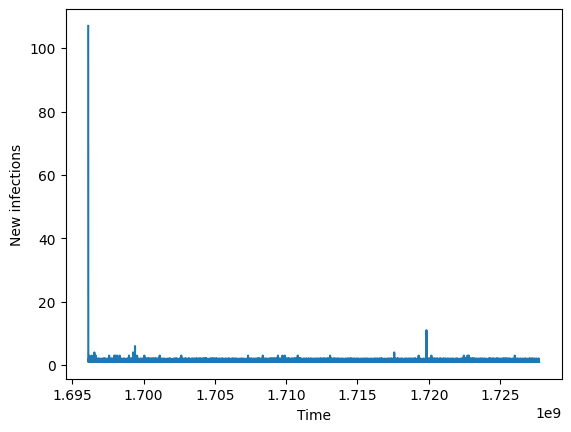

In [ ]:
times = list(result.values())
counts = Counter(times)
xs = sorted(counts)
ys = [counts[x] for x in xs]
plt.plot(xs, ys)
plt.xlabel("Time")
plt.ylabel("New infections")

In [ ]:
layer_counts = defaultdict(int)
for node in result:
    layer = node[1]
    layer_counts[layer] += 1
print(layer_counts)

defaultdict(<class 'int'>, {'gov': 18249, 'fin': 13766})


In [ ]:
def prepare_infection_df(infection_times):
    records = []
    for (user, layer), t in infection_times.items():
        records.append({"user": user, "layer": layer, "timestamp": t})
    return pd.DataFrame(records)

df_infections = prepare_infection_df(result)


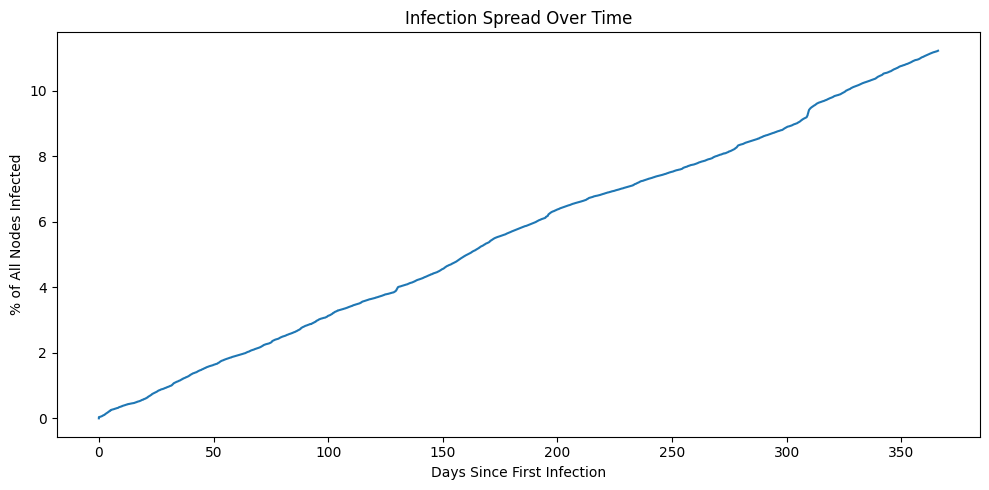

In [ ]:
def plot_infection_curve(df, total_nodes):
    df_sorted = df.sort_values("timestamp")
    t0 = df_sorted["timestamp"].min()
    df_sorted["days"] = (df_sorted["timestamp"] - t0) / 86400
    df_sorted["cumulative"] = range(1, len(df_sorted)+1)

    plt.figure(figsize=(10, 5))
    plt.plot(df_sorted["days"], df_sorted["cumulative"] / total_nodes * 100, label="Total")

    plt.xlabel("Days Since First Infection")
    plt.ylabel("% of All Nodes Infected")
    plt.title("Infection Spread Over Time")
    # plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_infection_curve(df_infections, total_nodes=G_SI_log.number_of_nodes())

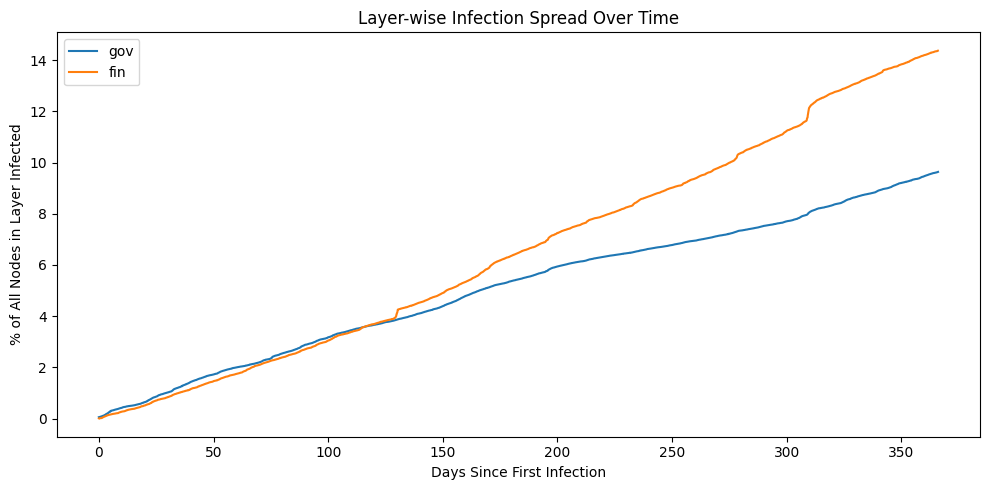

In [ ]:
def plot_layerwise_infection(df, total_node_dict):
    df = df.sort_values("timestamp")
    t0 = df["timestamp"].min()
    df["days"] = (df["timestamp"] - t0) / 86400

    df["count"] = 1
    df_grouped = df.groupby(["days", "layer"]).count().reset_index()
    df_grouped["cumulative"] = df_grouped.groupby("layer")["count"].cumsum()

    plt.figure(figsize=(10, 5))
    for layer in df["layer"].unique():
        subset = df_grouped[df_grouped["layer"] == layer]
        total_layer_nodes = total_node_dict.get(layer, 1)  # avoid division by 0
        plt.plot(subset["days"], subset["cumulative"] / total_layer_nodes * 100, label=layer)

    plt.xlabel("Days Since First Infection")
    plt.ylabel("% of All Nodes in Layer Infected")
    plt.title("Layer-wise Infection Spread Over Time")
    plt.legend()
    # plt.grid(True)
    plt.tight_layout()
    plt.show()

total_node_dict = {
    "gov": len([n for n in G_SI_log.nodes if n[1] == "gov"]),
    "fin": len([n for n in G_SI_log.nodes if n[1] == "fin"]),
}

plot_layerwise_infection(df_infections, total_node_dict)

## Temporal Random Walk

In [ ]:
def eta_minus_ranking(timestamps):
    """
    η− : newer → larger value, then normalised 0‑1
    """
    sorted_ts = sorted(timestamps, reverse=True)
    rank_map   = {ts: idx + 1 for idx, ts in enumerate(sorted_ts)}
    max_rank   = len(timestamps)
    return [(max_rank - rank_map[ts] + 1) / max_rank for ts in timestamps]

def eta_plus_linear(weights, eps=1e-9):
    """
    η+ : linear but attenuated (√) so small‑weight edges still get probability.
    """
    max_w = max(weights)# + eps
    return [math.sqrt(w / max_w) for w in weights]

In [ ]:
def temporal_random_walk_multilayer(G, start_node, steps, p_switch=0.2, alpha=0.5, weight_attr='weight', timestamp_attr='timestamp'):
    current_node = start_node
    walk = [current_node]

    for _ in range(steps):
        neighbors = list(G.successors(current_node))
        if not neighbors:
            break

        # Separate inter-layer and intra-layer edges
        intra_layer_edges = []
        inter_layer_edges = []
        for neighbor in neighbors:
            edge_data = G.get_edge_data(current_node, neighbor)
            if edge_data:
                if edge_data[0].get('layer_bridge', False):
                    inter_layer_edges.append((neighbor, edge_data[0]))
                else:
                    intra_layer_edges.append((neighbor, edge_data[0]))

        # Decide whether to switch layers or stay in the current layer
        if inter_layer_edges and random.random() < p_switch:
            # Switch layers
            next_node = random.choice(inter_layer_edges)[0]
        elif intra_layer_edges:
            # Stay in the current layer
            # Calculate probabilities based on weights and timestamps
            weights = [edge[1][weight_attr] for edge in intra_layer_edges]
            timestamps = [edge[1][timestamp_attr] for edge in intra_layer_edges]
            
            eta_t  = eta_minus_ranking(timestamps)
            P_T    = [x / sum(eta_t) for x in eta_t]
            
            eta_w  = eta_plus_linear(weights)
            P_W    = [x / sum(eta_w) for x in eta_w]
            
            P_e = [(p_t**alpha)*(p_w**(1-alpha)) for p_t,p_w in zip(P_T,P_W)]
            P_e = [p/sum(P_e) for p in P_e]      # normalise
            next_node = random.choices(intra_layer_edges, weights=P_e)[0]
        else:
            # No valid edges to follow
            break

        walk.append(next_node)
        current_node = next_node

    return walk

## Plots

### AAVE

In [ ]:
price_data = pd.read_csv('data/AAVE_daily_USD.csv', parse_dates=['snapped_at'])

price_data['date'] = price_data['snapped_at'].dt.date

aave_df['date'] = pd.to_datetime(aave_df['timestamp'], unit='s')
aave_df['date'] = aave_df['date'].dt.date

merged_data_aave = aave_df.groupby('date').size().reset_index(name='num_entries')
merged_data_aave = aave_df.groupby('date').agg(num_entries=('value', 'count'), total_value=('value', 'sum')).reset_index()
merged_data_aave = merged_data_aave.merge(price_data[['date', 'price']], on='date', how='left')
merged_data_aave['total_traded_value'] = merged_data_aave['total_value'] * merged_data_aave['price']

C:\Users\Sam\AppData\Local\Temp\ipykernel_10076\512218908.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aave_df['date'] = pd.to_datetime(aave_df['timestamp'], unit='s')
C:\Users\Sam\AppData\Local\Temp\ipykernel_10076\512218908.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aave_df['date'] = aave_df['date'].dt.date


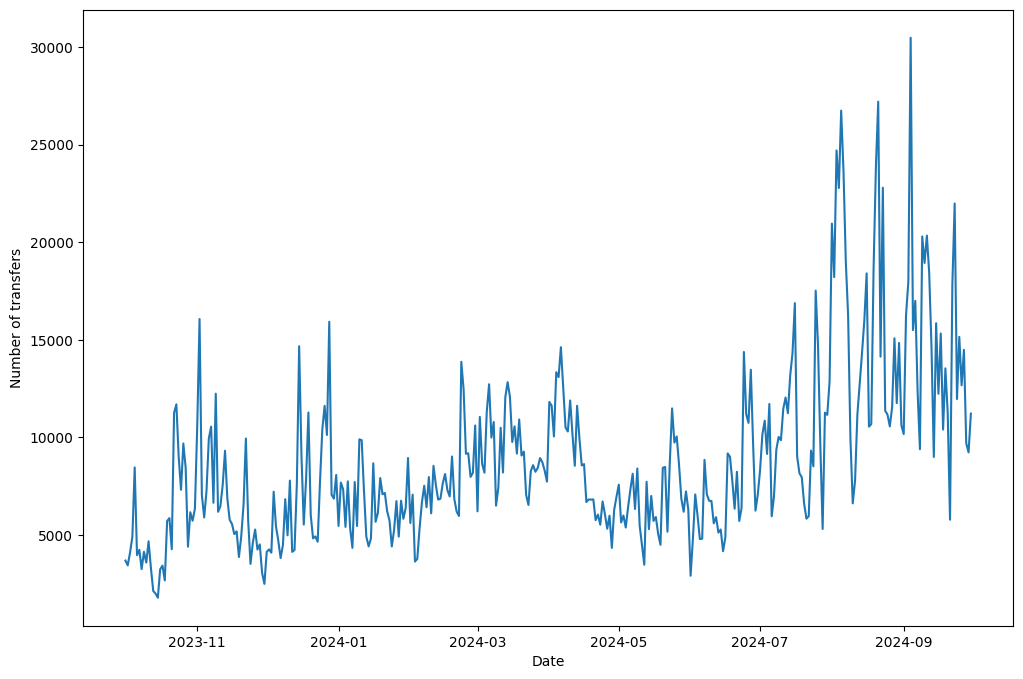

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.plot(merged_data_aave['date'], merged_data_aave['num_entries'])
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of transfers')
ax1.tick_params(axis='y')

# ax2 = ax1.twinx()
# ax2.plot(merged_data_aave['date'], merged_data_aave['price'], color='red')
# ax2.set_ylabel('Price', color='red')
# ax2.tick_params(axis='y', labelcolor='red')

# plt.title('Number of AAVE transfers per day')
plt.show()

# fig, ax1 = plt.subplots(figsize=(12, 6))

# ax1.plot(merged_data_aave['date'], merged_data_aave['total_value'])
# ax1.set_xlabel('Date')
# ax1.set_ylabel('Number of tokens')
# ax1.tick_params(axis='y')

# # ax2 = ax1.twinx()
# # ax2.plot(merged_data_aave['date'], merged_data_aave['price'], color='red')
# # ax2.set_ylabel('Price', color='red')
# # ax2.tick_params(axis='y', labelcolor='red')

# plt.title('Number of AAVE tokens transferred per day and price over time')
# plt.show()

# plt.figure(figsize=(12, 6))
# plt.plot(merged_data_aave['date'], merged_data_aave['total_traded_value'])
# plt.xlabel('Date')
# plt.ylabel('Total traded value in USD')
# plt.title('Total AAVE value traded per day')
# plt.show()

In [ ]:
aave_addresses = pd.concat([aave_df['from'], aave_df['to']])
aToken_addresses = pd.concat([aToken_df['from'], aToken_df['to']])

aave_transaction_counts = aave_addresses.value_counts()
aToken_transaction_counts = aToken_addresses.value_counts()

voters_set = set(vote_counts.keys())

aave_voters_transaction_counts = aave_transaction_counts[aave_transaction_counts.index.isin(voters_set)]
aave_non_voters_transaction_counts = aave_transaction_counts[~aave_transaction_counts.index.isin(voters_set)]

aWETH_voters_transaction_counts = aToken_transaction_counts[aToken_transaction_counts.index.isin(voters_set)]
aWETH_non_voters_transaction_counts = aToken_transaction_counts[~aToken_transaction_counts.index.isin(voters_set)]

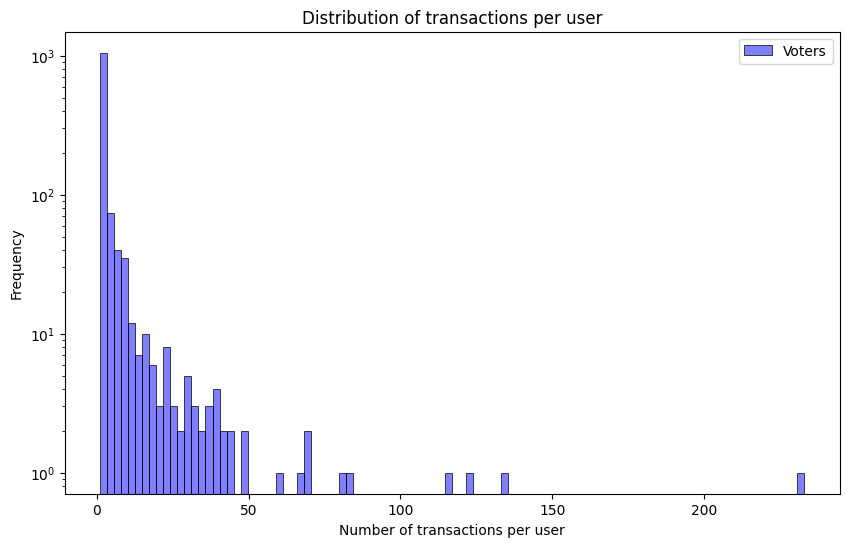

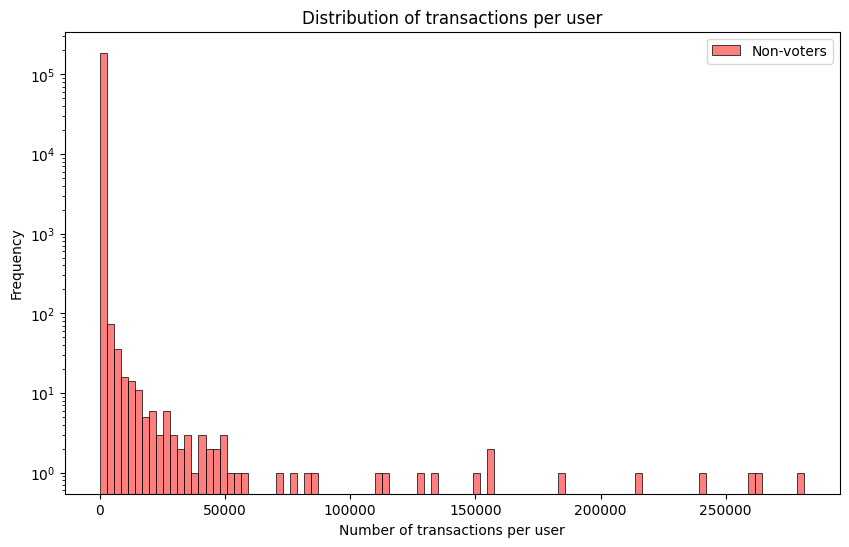

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(aave_voters_transaction_counts, bins=100, color='blue', label='Voters', alpha=0.5)
plt.yscale('log')
plt.xlabel("Number of transactions per user")
plt.ylabel("Frequency")
plt.title("Distribution of transactions per user")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(aave_non_voters_transaction_counts, bins=100, color='red', label='Non-voters', alpha=0.5)
plt.yscale('log')
plt.xlabel("Number of transactions per user")
plt.ylabel("Frequency")
plt.title("Distribution of transactions per user")
plt.legend()
plt.show()

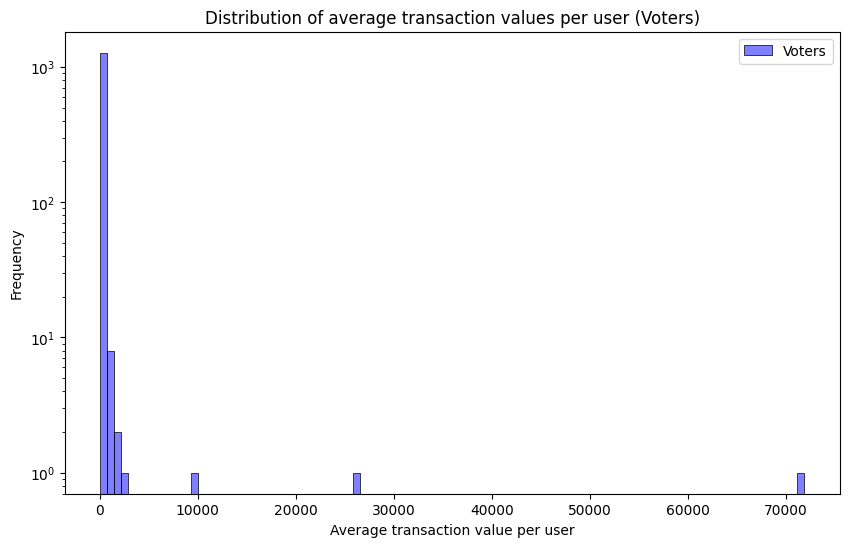

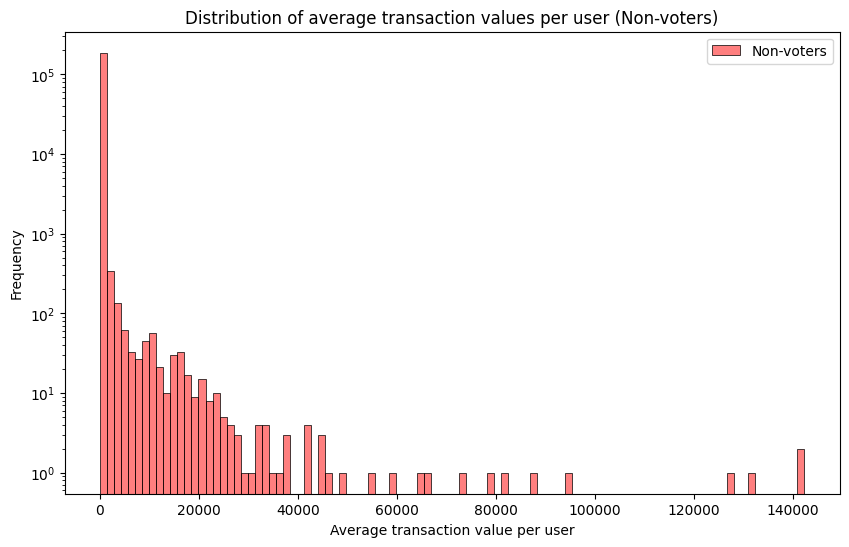

In [ ]:
aave_avg_transaction_values = aave_df.groupby('from')['value'].mean().add(
    aave_df.groupby('to')['value'].mean(), fill_value=0
) / 2

aave_voters_avg_transaction_values = aave_avg_transaction_values[aave_avg_transaction_values.index.isin(voters_set)]
aave_non_voters_avg_transaction_values = aave_avg_transaction_values[~aave_avg_transaction_values.index.isin(voters_set)]

plt.figure(figsize=(10, 6))
sns.histplot(aave_voters_avg_transaction_values, bins=100, color='blue', label='Voters', alpha=0.5)
plt.yscale('log')
plt.xlabel("Average transaction value per user")
plt.ylabel("Frequency")
plt.title("Distribution of average transaction values per user (Voters)")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(aave_non_voters_avg_transaction_values, bins=100, color='red', label='Non-voters', alpha=0.5)
plt.yscale('log')
plt.xlabel("Average transaction value per user")
plt.ylabel("Frequency")
plt.title("Distribution of average transaction values per user (Non-voters)")
plt.legend()
plt.show()

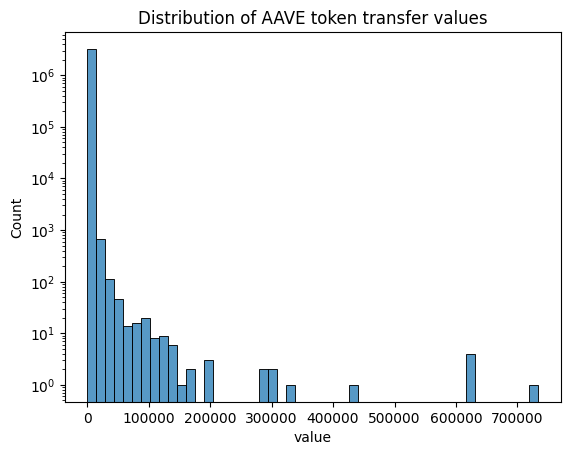

In [ ]:
sns.histplot(aave_df['value'], bins=50)#, log_scale=(True, False))
plt.yscale('log')
plt.title('Distribution of AAVE token transfer values')
plt.show()

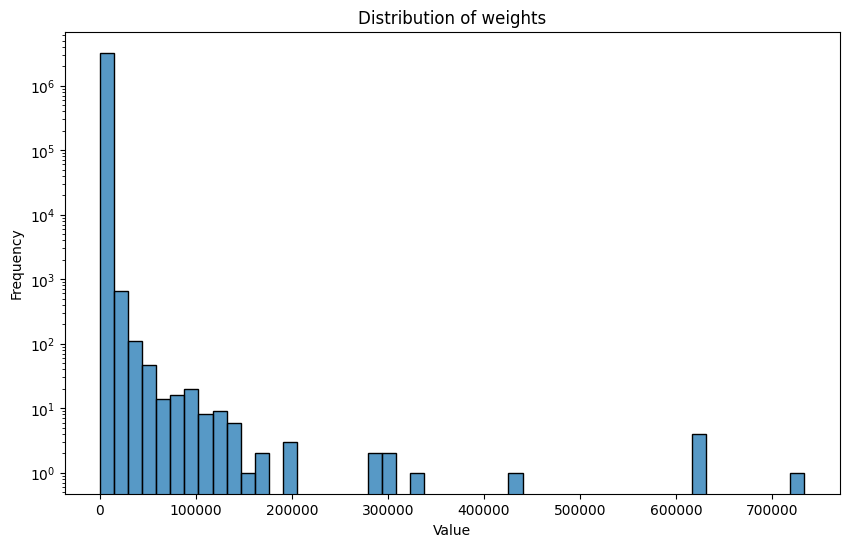

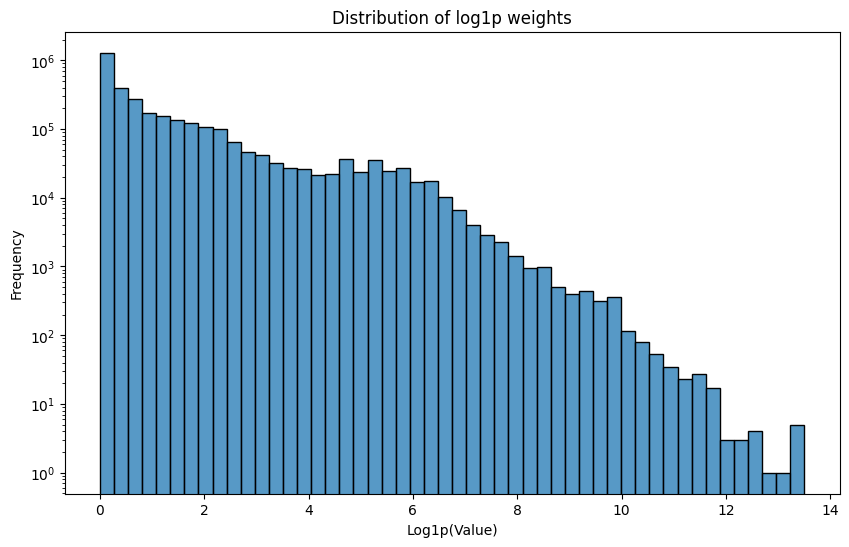

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(aave_df['value'], bins=50, edgecolor='black')
plt.yscale('log')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of weights')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(aave_df['value']), bins=50)
plt.yscale('log')
plt.xlabel('Log1p(Value)')
plt.ylabel('Frequency')
plt.title('Distribution of log1p weights')
plt.show()

### aWETH

In [ ]:
price_data = pd.read_csv('data/WETH_daily_USD.csv', parse_dates=['snapped_at'])

price_data['date'] = price_data['snapped_at'].dt.date

aToken_df['date'] = pd.to_datetime(aToken_df['timestamp'], unit='s')
aToken_df['date'] = aToken_df['date'].dt.date

merged_data_WETH = aToken_df.groupby('date').size().reset_index(name='num_entries')
merged_data_WETH = aToken_df.groupby('date').agg(num_entries=('value', 'count'), total_value=('value', 'sum')).reset_index()
merged_data_WETH = merged_data_WETH.merge(price_data[['date', 'price']], on='date', how='left')
merged_data_WETH['total_traded_value'] = merged_data_WETH['total_value'] * merged_data_WETH['price']

C:\Users\Sam\AppData\Local\Temp\ipykernel_3340\3857162676.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aToken_df['date'] = pd.to_datetime(aToken_df['timestamp'], unit='s')
C:\Users\Sam\AppData\Local\Temp\ipykernel_3340\3857162676.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aToken_df['date'] = aToken_df['date'].dt.date


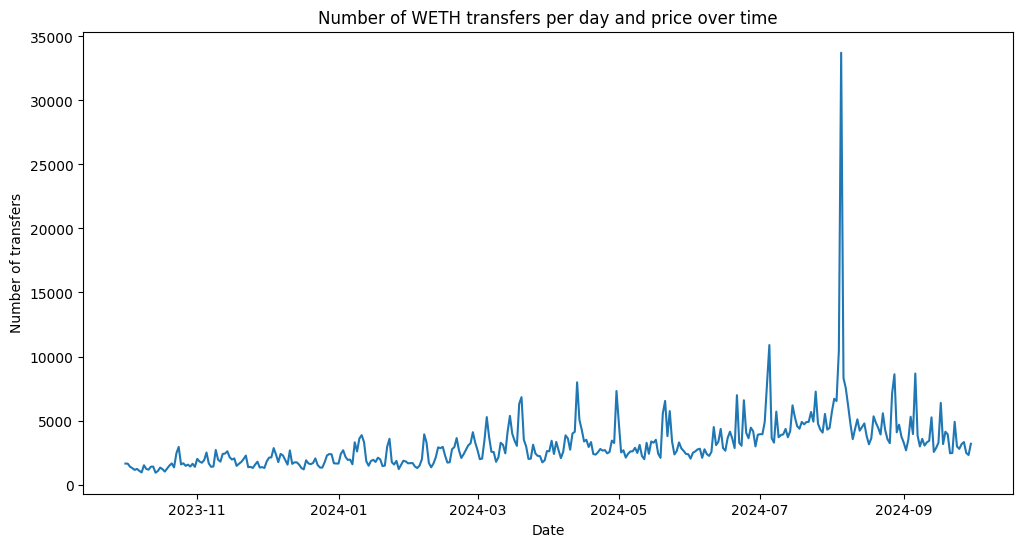

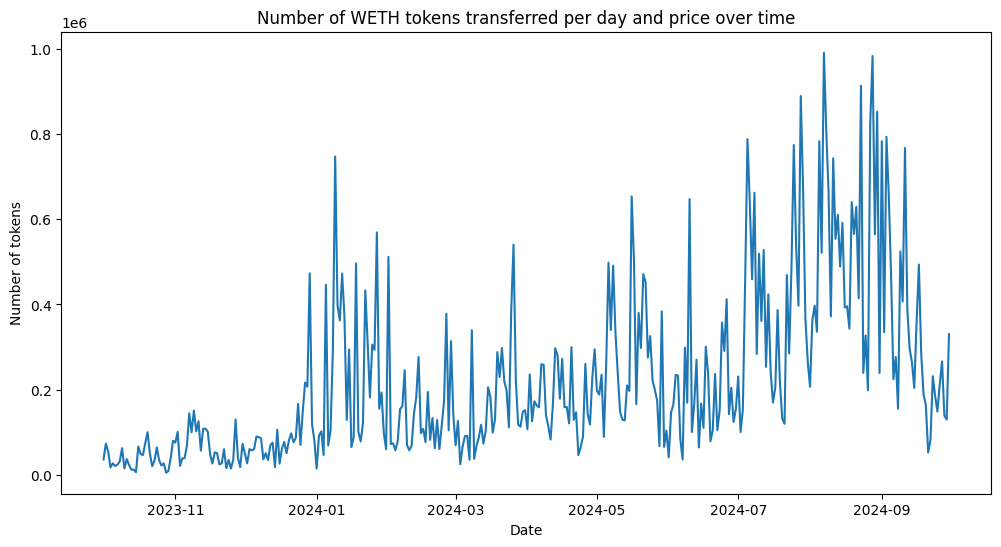

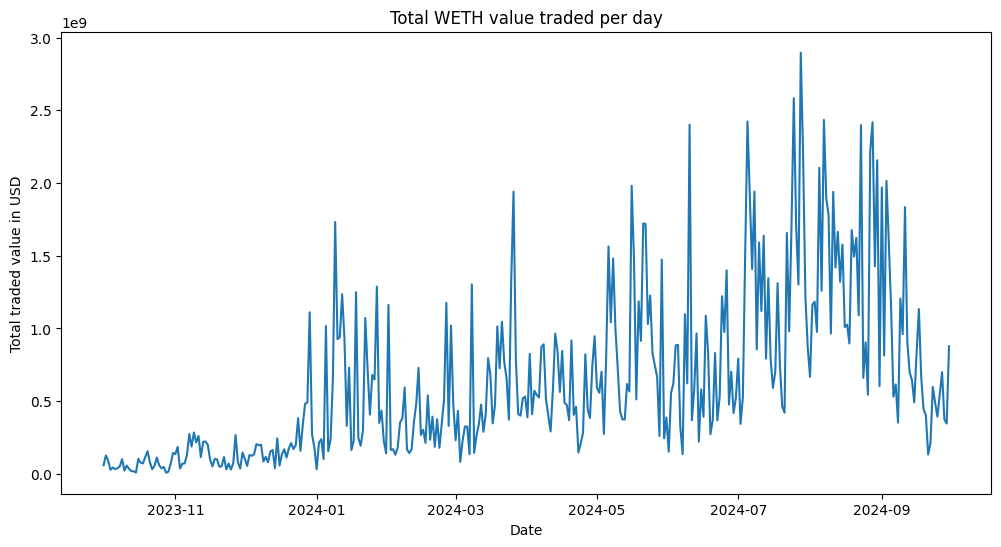

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(merged_data_WETH['date'], merged_data_WETH['num_entries'])
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of transfers')
ax1.tick_params(axis='y')

# ax2 = ax1.twinx()
# ax2.plot(merged_data_WETH['date'], merged_data_WETH['price'], color='red')
# ax2.set_ylabel('Price', color='red')
# ax2.tick_params(axis='y', labelcolor='red')

plt.title('Number of WETH transfers per day and price over time')
plt.show()

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(merged_data_WETH['date'], merged_data_WETH['total_value'])
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of tokens')
ax1.tick_params(axis='y')

# ax2 = ax1.twinx()
# ax2.plot(merged_data_WETH['date'], merged_data_WETH['price'], color='red')
# ax2.set_ylabel('Price', color='red')
# ax2.tick_params(axis='y', labelcolor='red')

plt.title('Number of WETH tokens transferred per day and price over time')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(merged_data_WETH['date'], merged_data_WETH['total_traded_value'])
plt.xlabel('Date')
plt.ylabel('Total traded value in USD')
plt.title('Total WETH value traded per day')
plt.show()

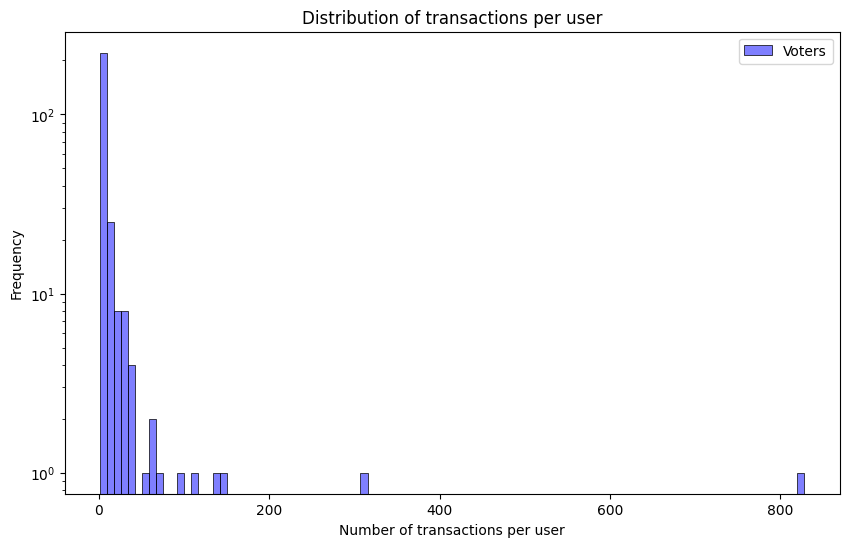

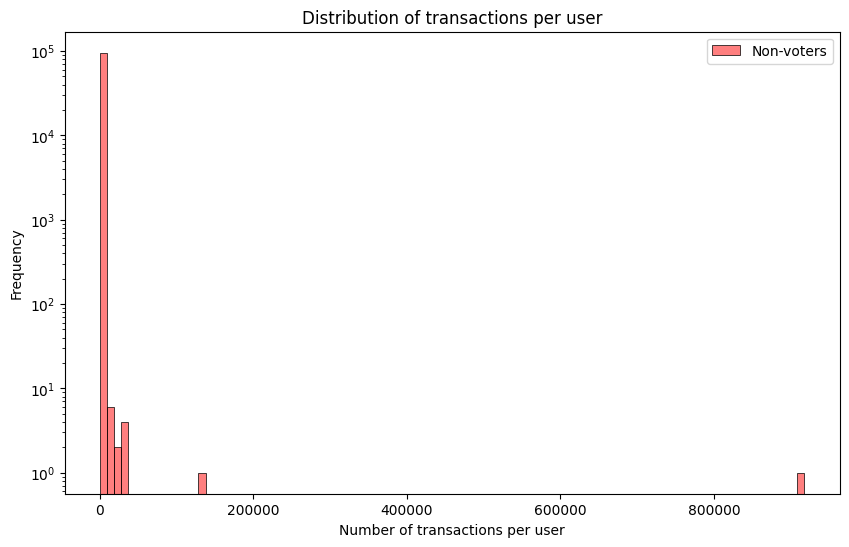

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(aWETH_voters_transaction_counts, bins=100, color='blue', label='Voters', alpha=0.5)
plt.yscale('log')
plt.xlabel("Number of transactions per user")
plt.ylabel("Frequency")
plt.title("Distribution of transactions per user")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(aWETH_non_voters_transaction_counts, bins=100, color='red', label='Non-voters', alpha=0.5)
plt.yscale('log')
plt.xlabel("Number of transactions per user")
plt.ylabel("Frequency")
plt.title("Distribution of transactions per user")
plt.legend()
plt.show()

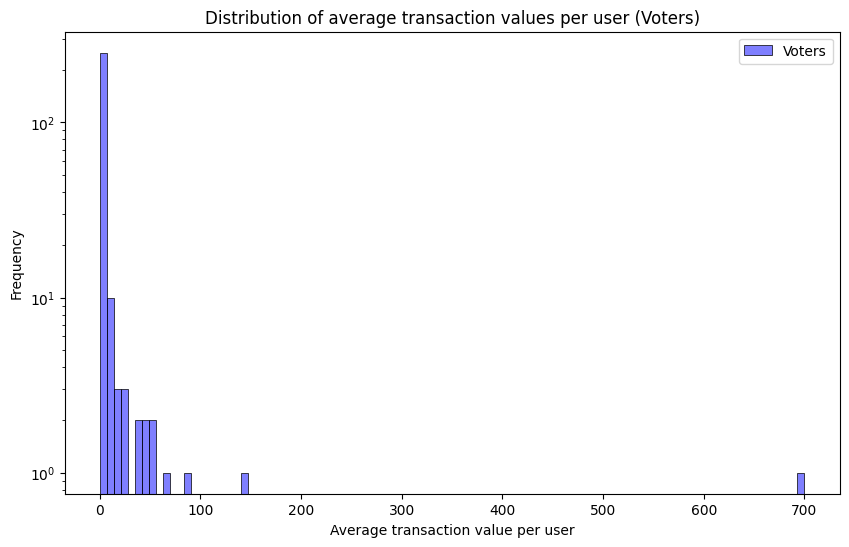

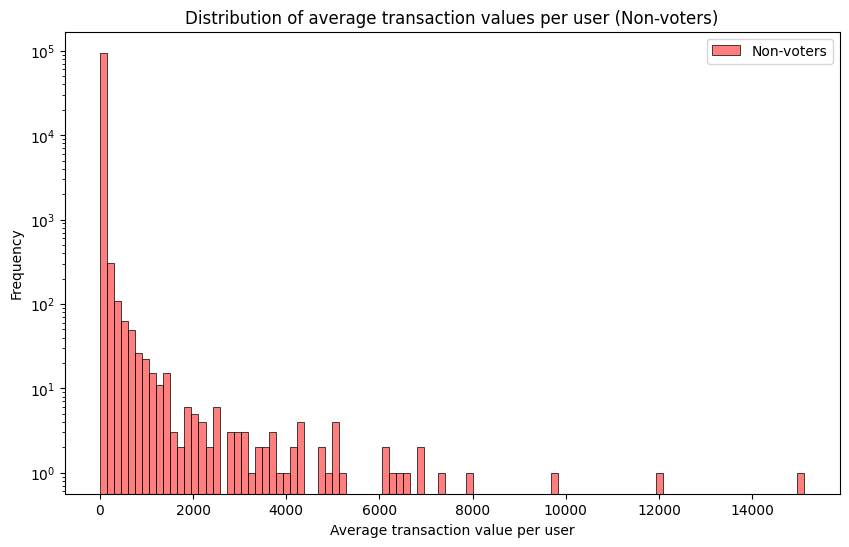

In [ ]:
aWETH_avg_transaction_values = aToken_df.groupby('from')['value'].mean().add(
    aToken_df.groupby('to')['value'].mean(), fill_value=0
) / 2

aWETH_voters_avg_transaction_values = aWETH_avg_transaction_values[aWETH_avg_transaction_values.index.isin(voters_set)]
aWETH_non_voters_avg_transaction_values = aWETH_avg_transaction_values[~aWETH_avg_transaction_values.index.isin(voters_set)]

plt.figure(figsize=(10, 6))
sns.histplot(aWETH_voters_avg_transaction_values, bins=100, color='blue', label='Voters', alpha=0.5)
plt.yscale('log')
plt.xlabel("Average transaction value per user")
plt.ylabel("Frequency")
plt.title("Distribution of average transaction values per user (Voters)")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(aWETH_non_voters_avg_transaction_values, bins=100, color='red', label='Non-voters', alpha=0.5)
plt.yscale('log')
plt.xlabel("Average transaction value per user")
plt.ylabel("Frequency")
plt.title("Distribution of average transaction values per user (Non-voters)")
plt.legend()
plt.show()

### Governance

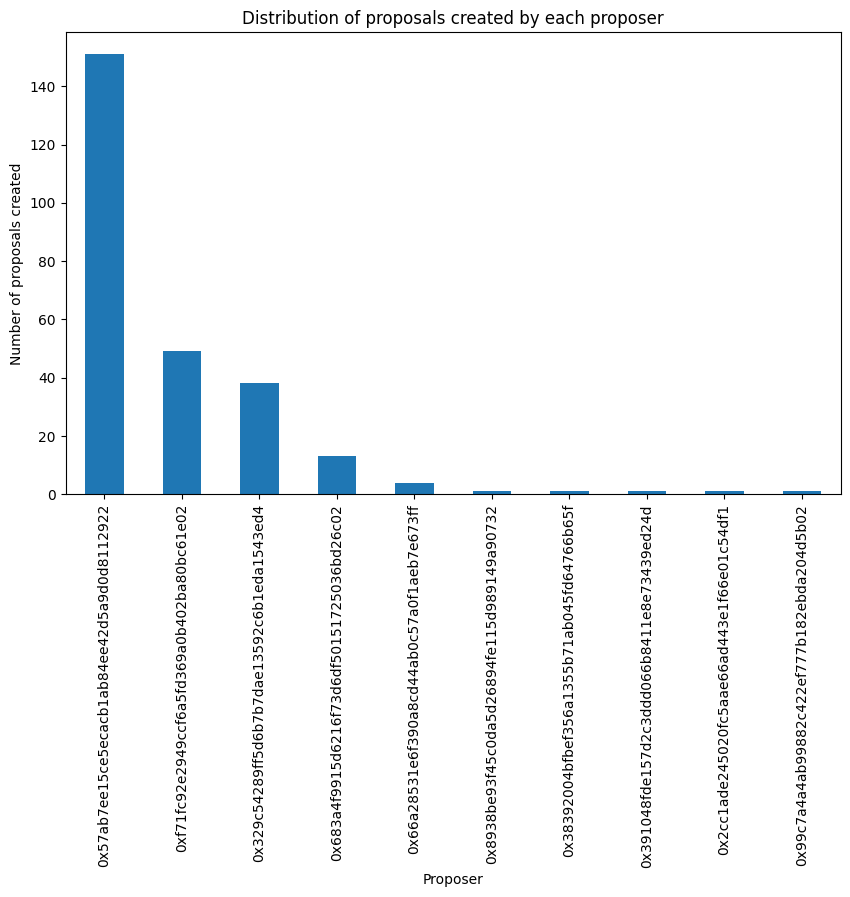

In [ ]:
proposer_counts = pd.Series([proposal['user']['id'] for proposal in aave_v2_proposals] + 
                            [proposal['creator'] for proposal in aave_v3_proposals]).value_counts()

plt.figure(figsize=(10, 6))
proposer_counts.plot(kind='bar')
plt.xlabel('Proposer')
plt.ylabel('Number of proposals created')
plt.title('Distribution of proposals created by each proposer')
plt.show()

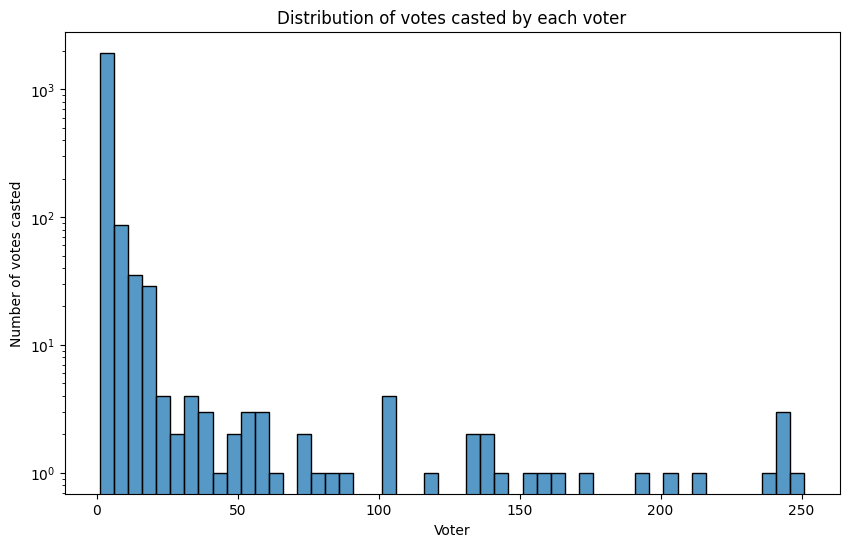

In [ ]:
voter_counts = pd.Series([vote['id'].split('-')[0] for votes in aave_v2_votes for vote in votes['votes']] + 
                         [vote['voter'].lower() for votes in aave_v3_votes for vote in votes['votes']]).value_counts()

plt.figure(figsize=(10, 6))
sns.histplot(voter_counts, bins=50)
plt.yscale('log')
plt.xlabel('Voter')
plt.ylabel('Number of votes casted')
plt.title('Distribution of votes casted by each voter')
plt.show()

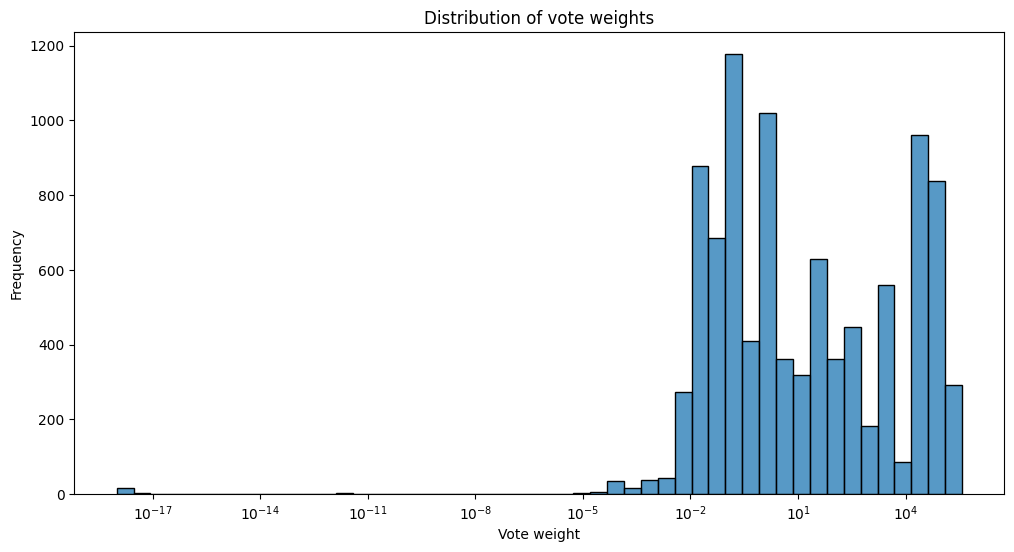

In [ ]:
vote_weights = []

for votes in aave_v2_votes:
    for vote in votes['votes']:
        vote_weights.append(float(vote['weight']))

for votes in aave_v3_votes:
    for vote in votes['votes']:
        vote_weights.append(float(vote['weight']))

plt.figure(figsize=(12, 6))
sns.histplot(vote_weights, bins=50, log_scale=(True, False))
plt.xlabel('Vote weight')
plt.ylabel('Frequency')
plt.title('Distribution of vote weights')
plt.show()

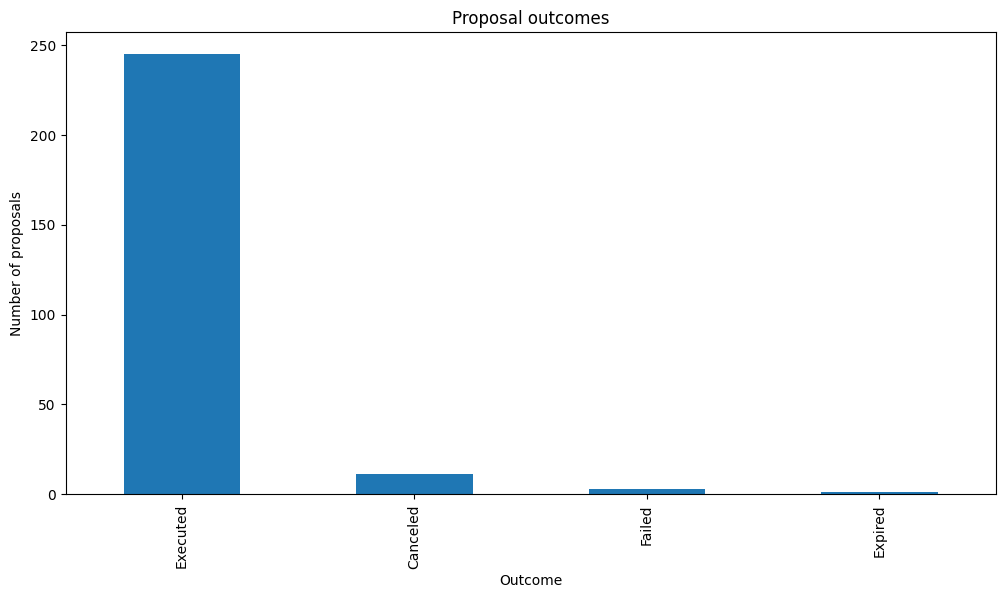

In [ ]:
proposal_outcomes = pd.Series([proposal['state'] for proposal in aave_v2_proposals + aave_v3_proposals])

plt.figure(figsize=(12, 6))
proposal_outcomes.value_counts().plot(kind='bar')
plt.xlabel('Outcome')
plt.ylabel('Number of proposals')
plt.title('Proposal outcomes')
plt.show()

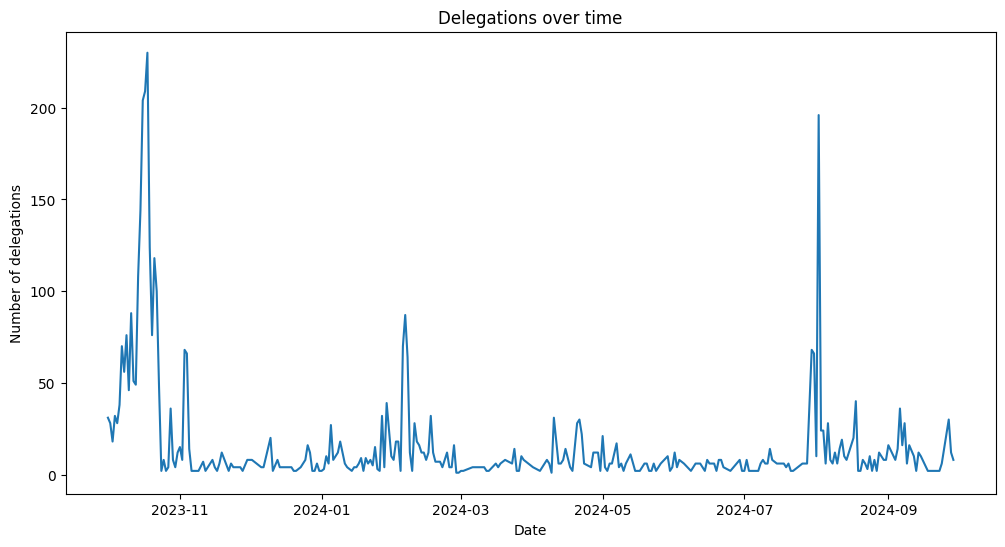

In [ ]:
delegations_df = pd.DataFrame(delegations)
delegations_df['date'] = pd.to_datetime(delegations_df['timestamp'], unit='s')
delegations_df['date'] = delegations_df['date'].dt.date
delegations_over_time = delegations_df.groupby('date').size()

plt.figure(figsize=(12, 6))
delegations_over_time.plot()
plt.xlabel('Date')
plt.ylabel('Number of delegations')
plt.title('Delegations over time')
plt.show()

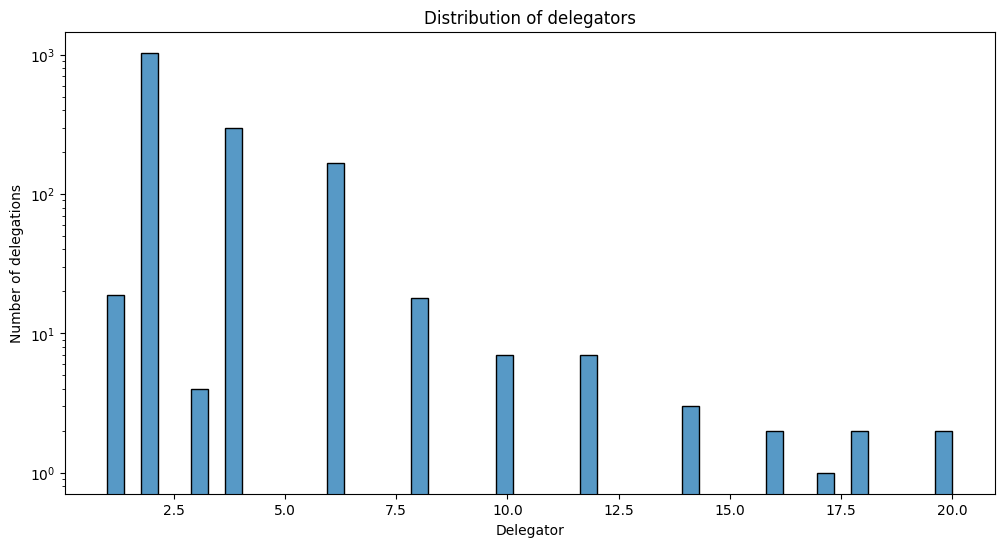

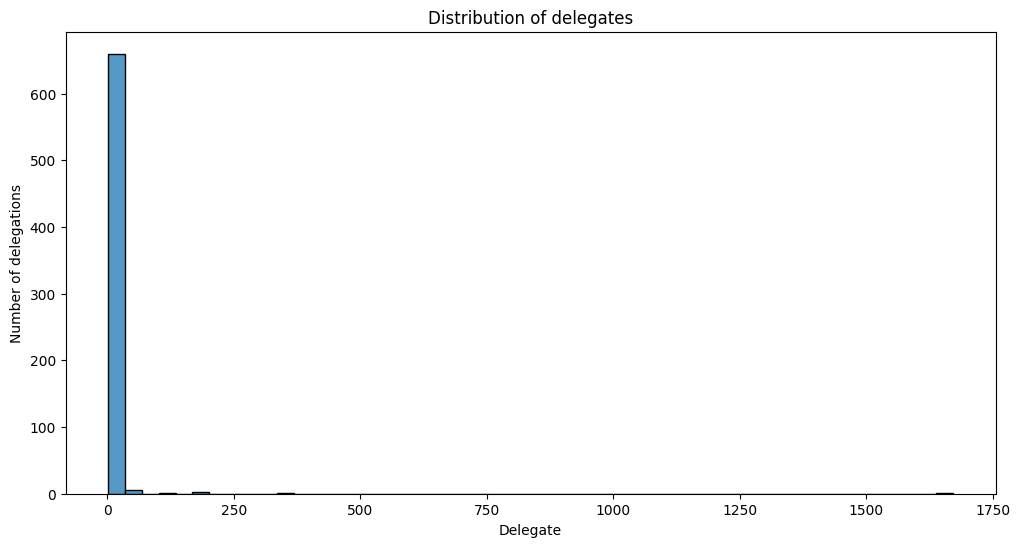

In [ ]:
delegator_counts = delegations_df['from'].value_counts()
delegate_counts = delegations_df['to'].value_counts()

plt.figure(figsize=(12, 6))
sns.histplot(delegator_counts, bins=50)
plt.yscale('log')
plt.xlabel('Delegator')
plt.ylabel('Number of delegations')
plt.title('Distribution of delegators')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(delegate_counts, bins=50)#, log_scale=(True, False))
# plt.yscale('log')
# plt.xscale('log')
plt.xlabel('Delegate')
plt.ylabel('Number of delegations')
plt.title('Distribution of delegates')
plt.show()

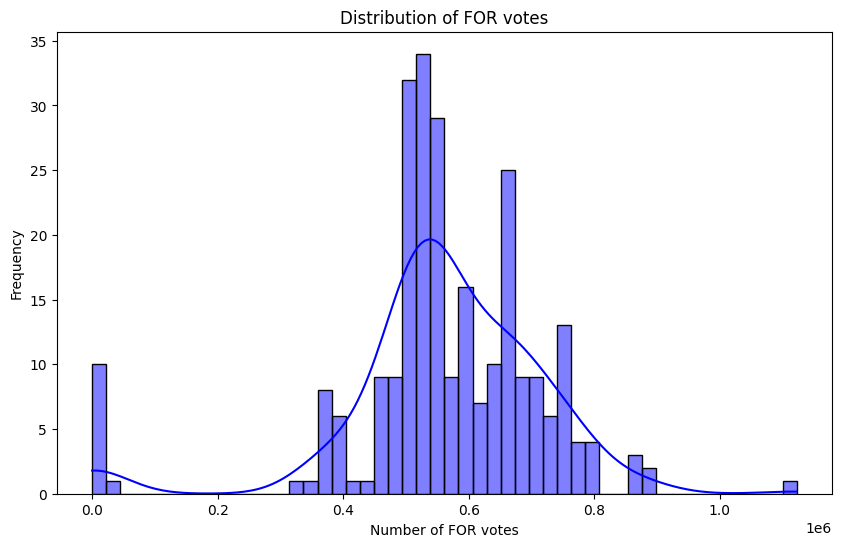

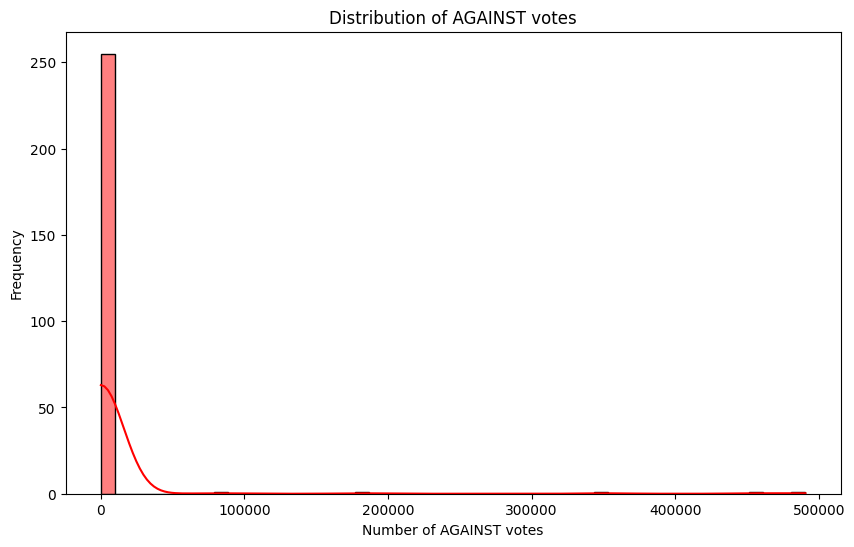

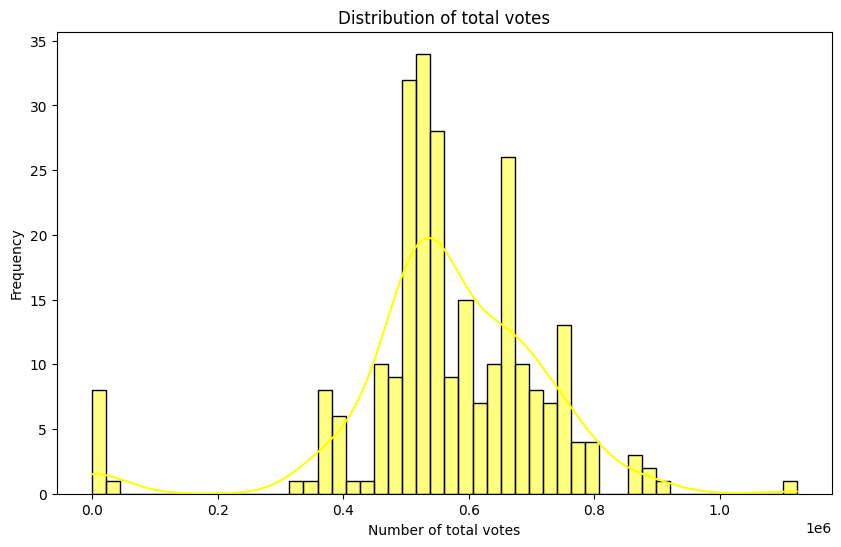

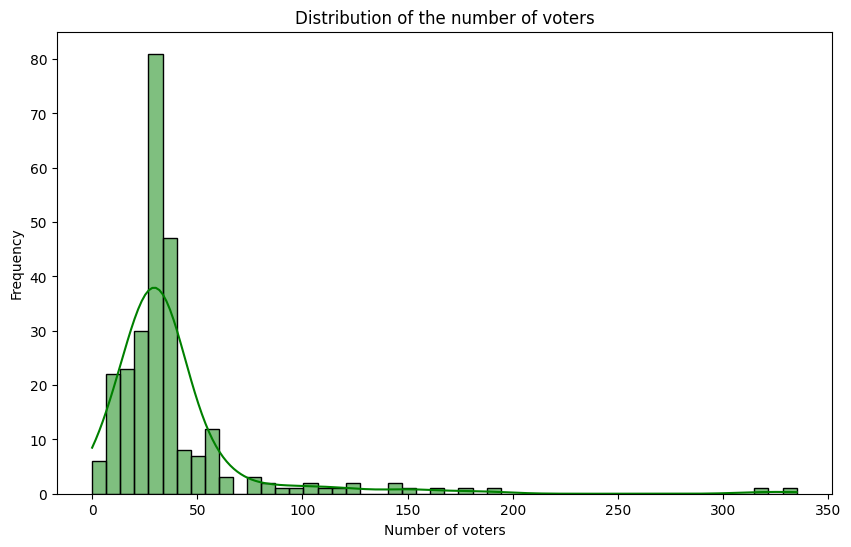

In [ ]:
for_votes = {proposal['id']: float(proposal['currentYesVote']) for proposal in aave_v2_proposals} | \
            {proposal['id']: float(proposal['votes']['forVotes']) if proposal['votes'] else 0 for proposal in aave_v3_proposals}

against_votes = {proposal['id']: float(proposal['currentNoVote']) for proposal in aave_v2_proposals} | \
                {proposal['id']: float(proposal['votes']['againstVotes']) if proposal['votes'] else 0 for proposal in aave_v3_proposals}
                
total_votes = {proposal['id']: float(proposal['currentYesVote']) + float(proposal['currentNoVote']) for proposal in aave_v2_proposals} | \
              {proposal['id']: float(proposal['votes']['forVotes']) + float(proposal['votes']['againstVotes']) if proposal['votes'] else 0 for proposal in aave_v3_proposals}

num_voters = {proposal['id']: proposal['totalCurrentVoters'] for proposal in aave_v2_proposals} | \
             {proposal['id']: proposal['totalCurrentVoters'] for proposal in aave_v3_proposals}

plt.figure(figsize=(10, 6))
sns.histplot(for_votes, bins=50, color='blue', kde=True)
plt.xlabel('Number of FOR votes')
plt.ylabel('Frequency')
plt.title('Distribution of FOR votes')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(against_votes, bins=50, color='red', kde=True)
plt.xlabel('Number of AGAINST votes')
plt.ylabel('Frequency')
plt.title('Distribution of AGAINST votes')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(total_votes, bins=50, color='yellow', kde=True)
plt.xlabel('Number of total votes')
plt.ylabel('Frequency')
plt.title('Distribution of total votes')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(num_voters, bins=50, color='green', kde=True)
plt.xlabel('Number of voters')
plt.ylabel('Frequency')
plt.title('Distribution of the number of voters')
plt.show()

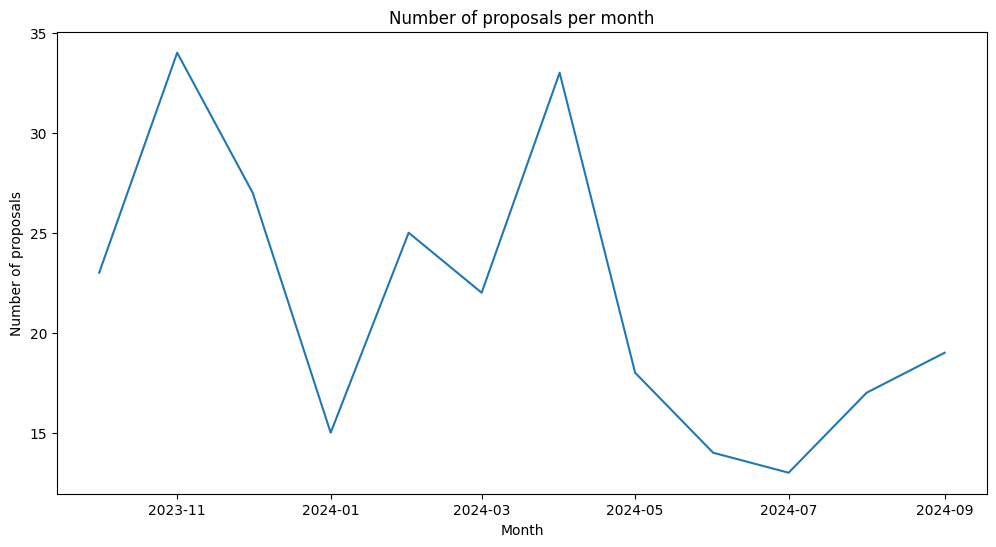

In [ ]:
all_proposal_dates = [datetime.fromtimestamp(proposal['timestamp']) for proposal in aave_v2_proposals] + \
                     [datetime.fromtimestamp(int(proposal['transactions']['created']['timestamp'])) for proposal in aave_v3_proposals]

proposal_dates_df = pd.DataFrame({'date': all_proposal_dates})
proposal_dates_df['month'] = proposal_dates_df['date'].dt.to_period('M')

proposals_per_month = proposal_dates_df.groupby('month').size().reset_index(name='count')

proposals_per_month['month'] = proposals_per_month['month'].dt.to_timestamp()

plt.figure(figsize=(12, 6))
plt.plot(proposals_per_month['month'], proposals_per_month['count'])
plt.xlabel('Month')
plt.ylabel('Number of proposals')
plt.title('Number of proposals per month')
plt.show()